# Deep Neural Network


## Import necessary libraries

In [1]:
# Import necessary libraries
import random
from time import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, precision_score, recall_score

# to suppress the warnings
import warnings
warnings.filterwarnings('ignore')

# Setting random variables to get the same results on different devices
seed = 9
tf.random.set_seed(seed)
np.random.seed(1)
random.seed(1)

## Define additional functions

In [2]:
# PLOTTING
def plot_history(history, main_title=None):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    if main_title:
        plt.suptitle(main_title, fontsize=16, y=1.1)
    plt.show()

    
def plot_combined_metrics(history1, history2, metric1, metric2, title):
    plt.figure(figsize=(12, 6))

    # Plot training & validation metric1 values for Model 1
    plt.subplot(1, 2, 1)
    plt.plot(history1.history[metric1], label=f'Training {metric1} - Model 1', linestyle='-', color='blue')
    plt.plot(history1.history[f'val_{metric1}'], label=f'Validation {metric1} - Model 1', linestyle='--', color='blue')
    
    # Plot training & validation metric2 values for Model 2
    plt.plot(history2.history[metric2], label=f'Training {metric2} - Model 2', linestyle='-', color='red')
    plt.plot(history2.history[f'val_{metric2}'], label=f'Validation {metric2} - Model 2', linestyle='--', color='red')

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(metric1)
    plt.legend(loc='upper left')

    # Plot training & validation metric2 values for Model 1
    plt.subplot(1, 2, 2)
    plt.plot(history1.history[metric2], label=f'Training {metric2} - Model 1', linestyle='-', color='blue')
    plt.plot(history1.history[f'val_{metric2}'], label=f'Validation {metric2} - Model 1', linestyle='--', color='blue')
    
    # Plot training & validation metric1 values for Model 2
    plt.plot(history2.history[metric1], label=f'Training {metric1} - Model 2', linestyle='-', color='red')
    plt.plot(history2.history[f'val_{metric1}'], label=f'Validation {metric1} - Model 2', linestyle='--', color='red')

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(metric2)
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(c_matrix, labels):
    """
    Print confusion matrix with sns.heatmap
    """
    ax = sns.heatmap(c_matrix, annot=True, linewidth=1.5, fmt='d',
                     xticklabels=labels,
                     yticklabels=labels,
                     cbar=False, cmap='Blues')

    ax.set_xlabel("Prediction")
    ax.set_ylabel("Actual")
    plt.show()

    
def plot_confusion_matrix_alt(c_matrix, labels):
    """
    sns.heatmap didn't show all values, so this is malual heatmap,
    that works properly.
    """
    
    fig, ax = plt.subplots()
    cax = ax.matshow(c_matrix, cmap='Blues')
    # Add annotations
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i==j:
                color='white'
            else:
                color='black'
            ax.text(j, i, c_matrix[i, j], va='center', ha='center', color=color, fontsize=12)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    plt.show()

## Data loading and preprocessing
The goal of this step is to check our data, normalise and split it for training and validation.

In [3]:
df = pd.read_csv('data_clean.csv')
df.head()
# shuffle dataset
df = shuffle(df, random_state=seed)

In [4]:
# Checking class imbalance

def balance_classes(df, target_column: str='CAFV', random_state:int=42):
    """
    Balance data to make class ratio 1:1.
    """
    # Shuffle the DataFrame
    df_shuffled = shuffle(df, random_state=random_state)

    # Identify the majority and minority classes
    majority_class = df_shuffled[target_column].value_counts().idxmax()
    minority_class = df_shuffled[target_column].value_counts().idxmin()

    # Count instances of each class
    majority_count = df_shuffled[target_column].value_counts()[majority_class]
    minority_count = df_shuffled[target_column].value_counts()[minority_class]

    # Determine the number of instances to keep for each class
    instances_to_keep = min(majority_count, minority_count)

    # Filter the DataFrame to keep the balanced classes
    df_balanced = pd.concat([
        df_shuffled[df_shuffled[target_column] == majority_class].head(instances_to_keep),
        df_shuffled[df_shuffled[target_column] == minority_class]
    ])
    return df_balanced


ratio_check=df.CAFV.value_counts()[0]/df.CAFV.value_counts()[1]
print("Ratio between the classes:", ratio_check)
# df.CAFV.value_counts()

if ratio_check > 1.51:
    print('Changed class balance')
    df = balance_classes(df)

Ratio between the classes: 1.4468515861629205


In [5]:
## Preprocessing
# Define features and target variable
X = df.drop('CAFV', axis=1)
y = df['CAFV']
X.shape, y.shape

((153491, 9), (153491,))

## Testing the model architecture and hyperparameters

In [6]:
# Defining a function for finding best model and hyperparameters

def find_best_arch(parameters, X_data, y_data):
    """
    Compares different model architectures with different hyperparameters.
    Creates 'dnn-models-results.csv' with results of training and plotting accuracy 
    and loss charts for each iteration.
    
    :param dict parameters: Dictionary of parameters, including models and optimizers.
    :param X_data: Independent variables.
    :param y_data: Dependent variable.
    
    :return dict summ_history: Dictionary with id of trial as keys
            and a History object of model with a record of metrics values as values.
    """
    tf.random.set_seed(seed)
    np.random.seed(1)
    random.seed(1)
    
    # Set no of epochs
    epochs=20
    # To store results
    columns = ['unique_id', 'Model No', 'Trial number', 'Optimizer', 'Batch Size', 'Train Accuracy', 'Test Accuracy', 'Time', 'Test size']
    results_df = pd.DataFrame(columns=columns)
    results_df.set_index('unique_id')
    summ_history = {}

    trial_number=0
    # Create a neasted loop to go through parameters
    for model_number, hidden_units in enumerate(parameters['model__hidden_units']):
        
        for optimizer in parameters['model__optimizer']:
            for batch_size_trial in parameters['model__batch_size']:
                for test_size in parameters['test_size']:
                    
                    unique_id = f"{trial_number}-{model_number}-{optimizer.__class__.__name__}-{batch_size_trial}-{test_size}"
                    unique_id = unique_id.strip()
                    print(unique_id)
                    time1 = time()

                    # Split
                    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=test_size, random_state=seed)
                    # Scaling the Features
                    sc = StandardScaler()
                    X_train = sc.fit_transform(X_train)
                    X_val = sc.fit_transform(X_val)
                    
                    # Define a model arch
                    model = Sequential([
                                    Dense(hidden_units, input_dim=X_train.shape[1], activation='relu'),
                                    Dense(hidden_units, activation='relu'),
                                    Dense(1, activation='sigmoid')])
                    
                    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
                    # Trainig
                    model_history = model.fit(X_train,
                                                   y_train,
                                                   validation_data=(X_val, y_val),
                                                   batch_size=batch_size_trial,
                                                   epochs=epochs,
                                                   verbose=0)
                    time2 = time()

                    # Fetching the accuracy of the training
                    accuracy_train = model_history.history['accuracy'][-1]
                    # Defining the accuracy of the testing
                    y_pred = model.predict(X_val)

                    # Evaluate the accuracy on the test set
                    y_pred = np.where(y_pred.flatten().round(2) > 0.5, 1, 0)
                    accuracy_val = accuracy_score(y_val.to_numpy(), y_pred)

                    # printing the setting of the current iteration
                    test_print = f'Model {model_number}, {optimizer.__class__.__name__}: batch_size: {batch_size_trial} - ' \
                                 f'Accuracy: {accuracy_val}.\n{unique_id}'

                    results_df = pd.concat([results_df,
                                            pd.DataFrame(data=[[unique_id, model_number, trial_number,
                                                               optimizer.__class__.__name__,
                                                               batch_size_trial,
                                                                accuracy_train,
                                                                accuracy_val,
                                                                time2 - time1,
                                                                test_size]],
                                                          columns=columns)],
                                           ignore_index=True)

                    print(unique_id)
                    plot_history(model_history, test_print)
                    summ_history[unique_id] = model_history
                    trial_number += 1
                
    results_df.sort_values(by='Test Accuracy', ascending=True)
    results_df.to_csv('dnn-models-test-results.csv', index=False)
    return summ_history

0-0-Adam-100-0.1


2023-11-26 03:52:39.403555: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


480/480 [==============================] - 0s 259us/step
0-0-Adam-100-0.1


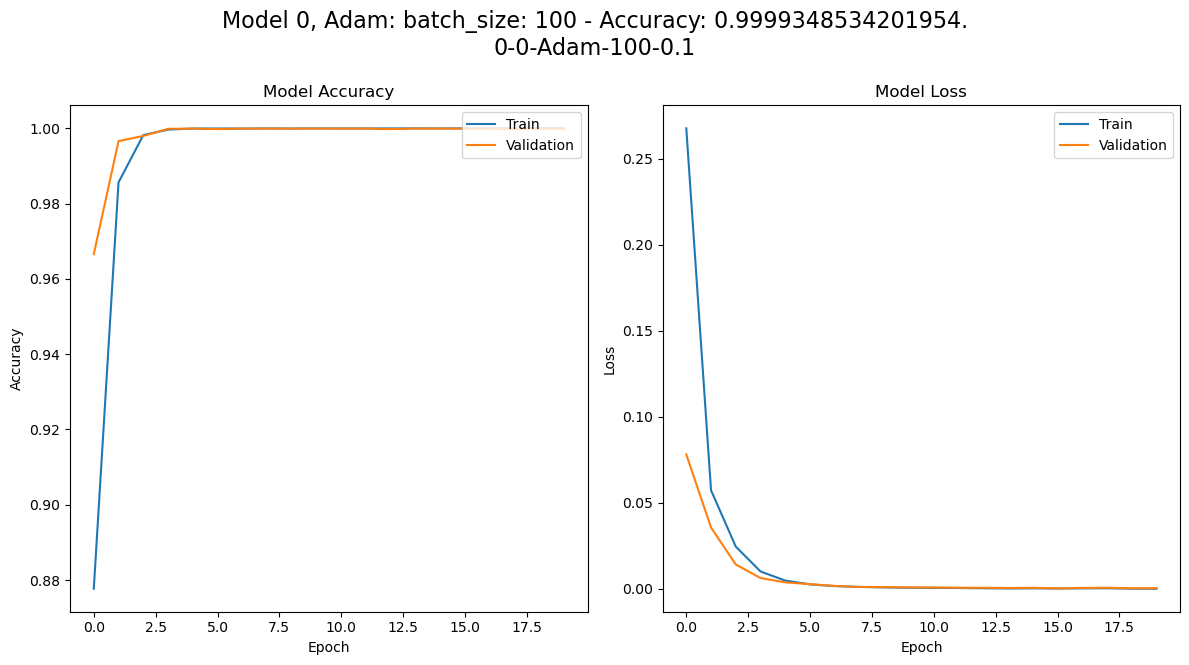

1-0-Adam-100-0.2
960/960 [==============================] - 0s 267us/step
1-0-Adam-100-0.2


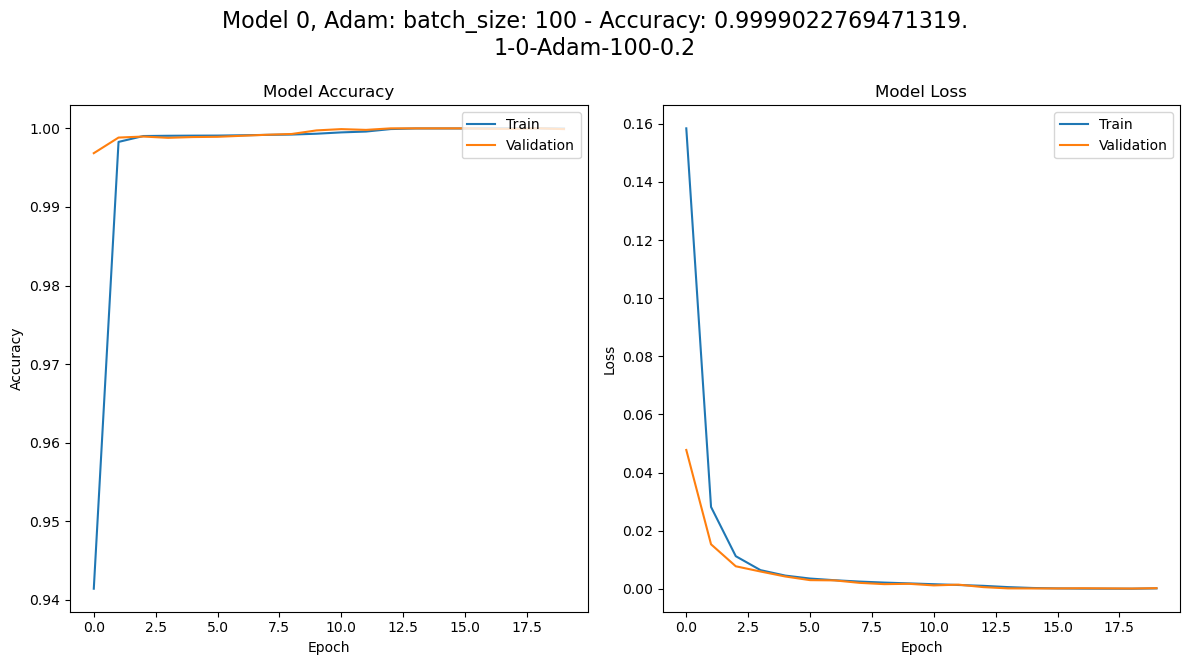

2-0-Adam-100-0.3
1439/1439 [==============================] - 0s 251us/step
2-0-Adam-100-0.3


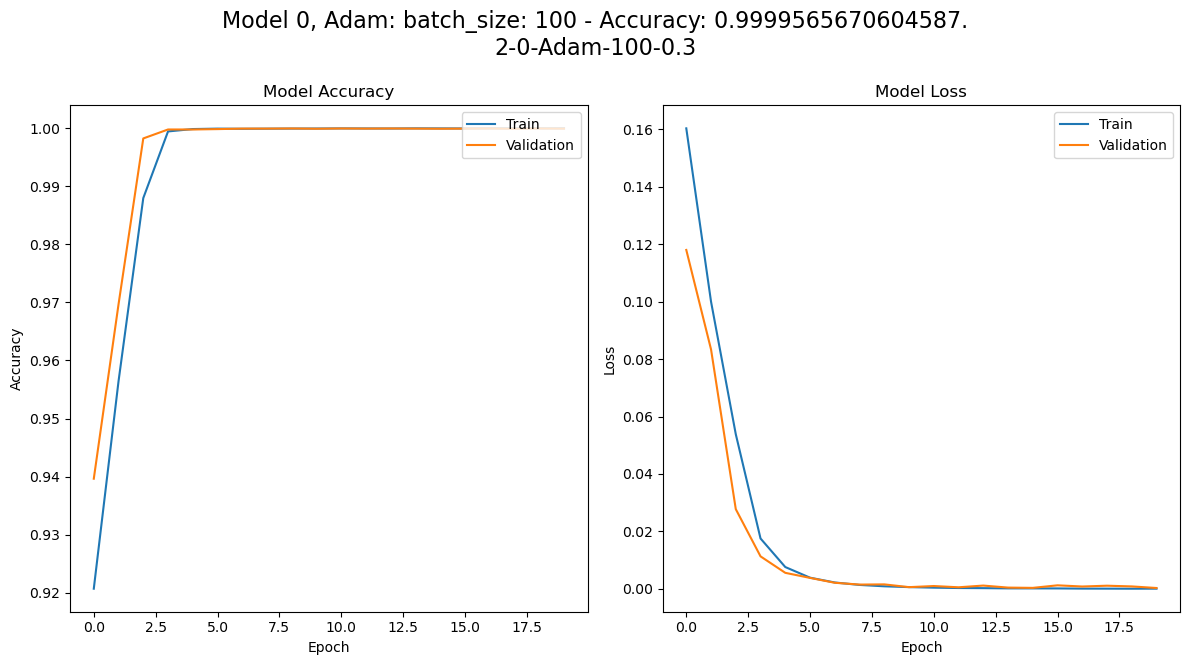

3-0-Adam-50-0.1
480/480 [==============================] - 0s 265us/step
3-0-Adam-50-0.1


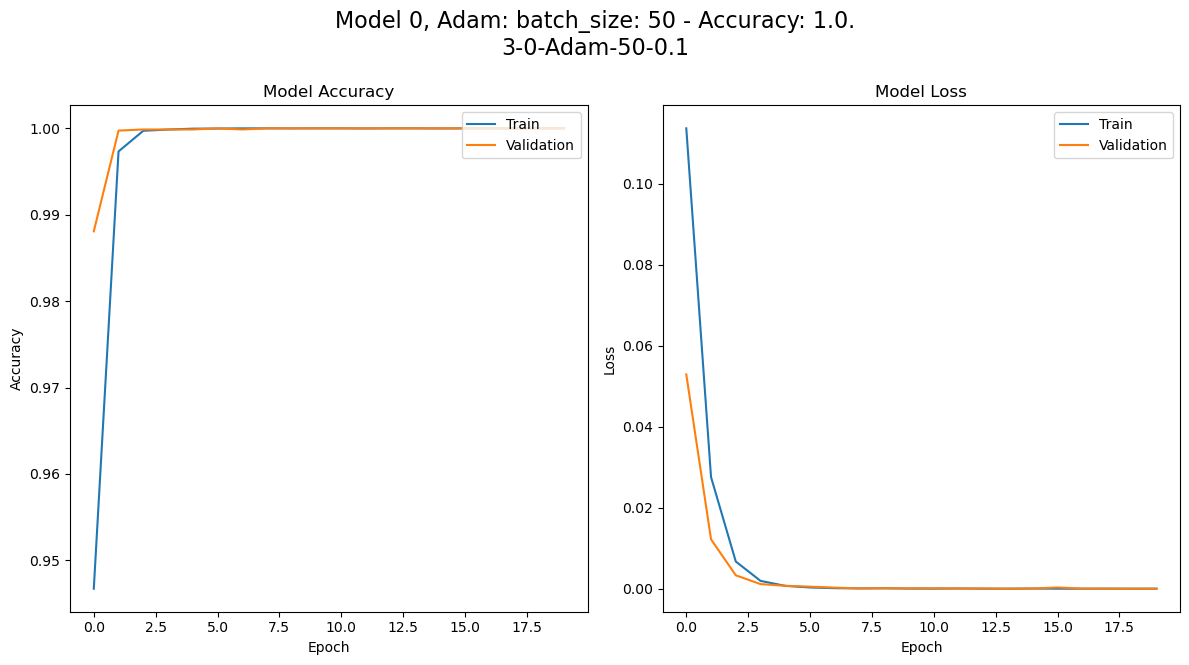

4-0-Adam-50-0.2
960/960 [==============================] - 0s 257us/step
4-0-Adam-50-0.2


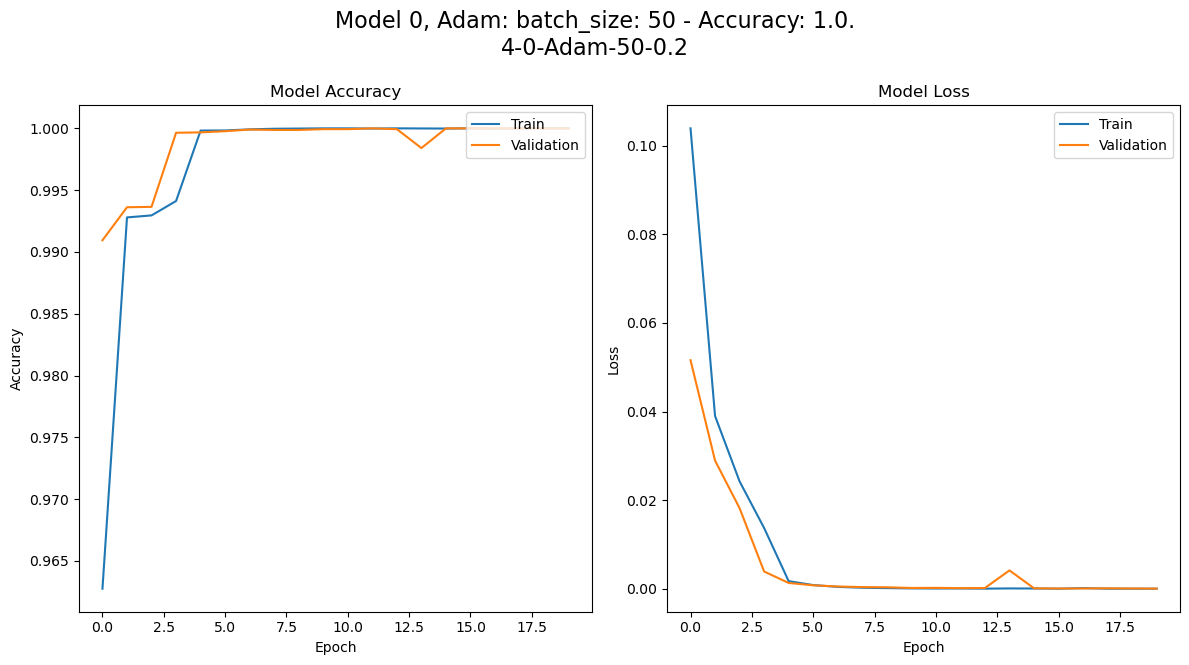

5-0-Adam-50-0.3
1439/1439 [==============================] - 0s 227us/step
5-0-Adam-50-0.3


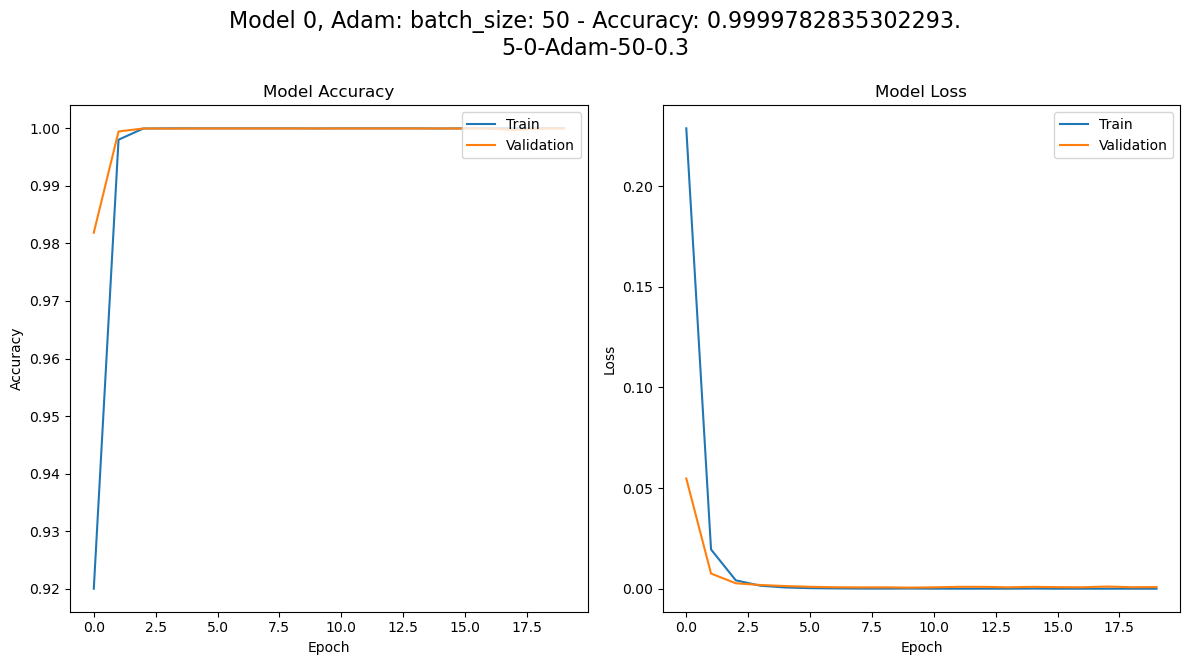

6-0-Adam-10-0.1
480/480 [==============================] - 0s 237us/step
6-0-Adam-10-0.1


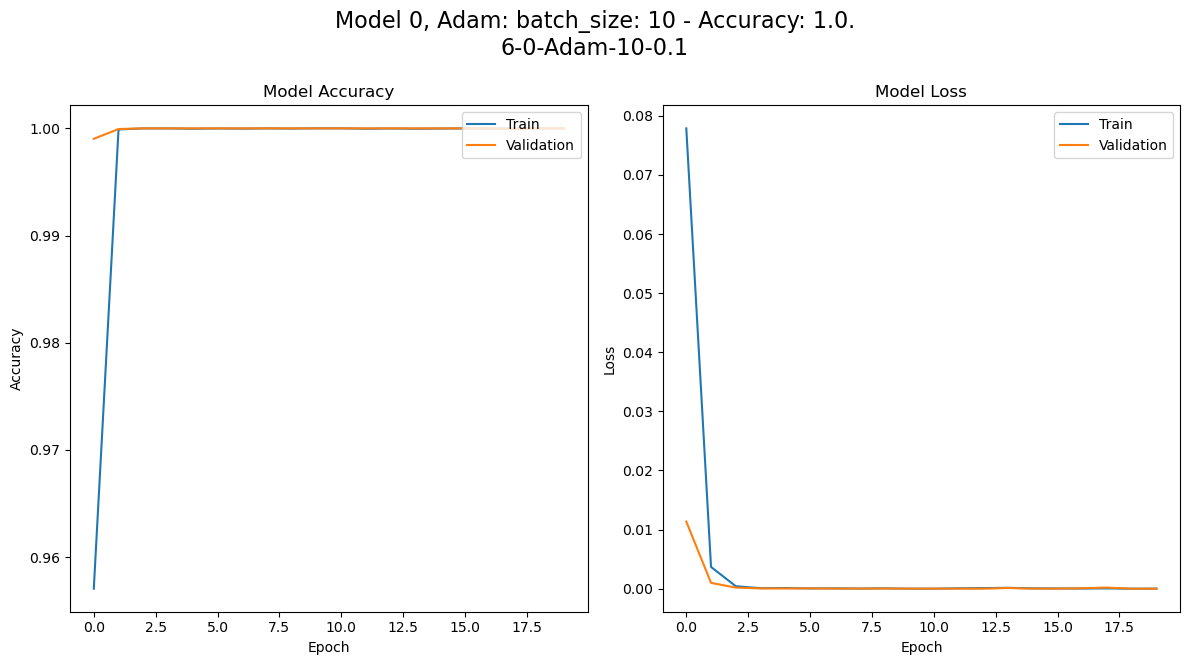

7-0-Adam-10-0.2
960/960 [==============================] - 0s 233us/step
7-0-Adam-10-0.2


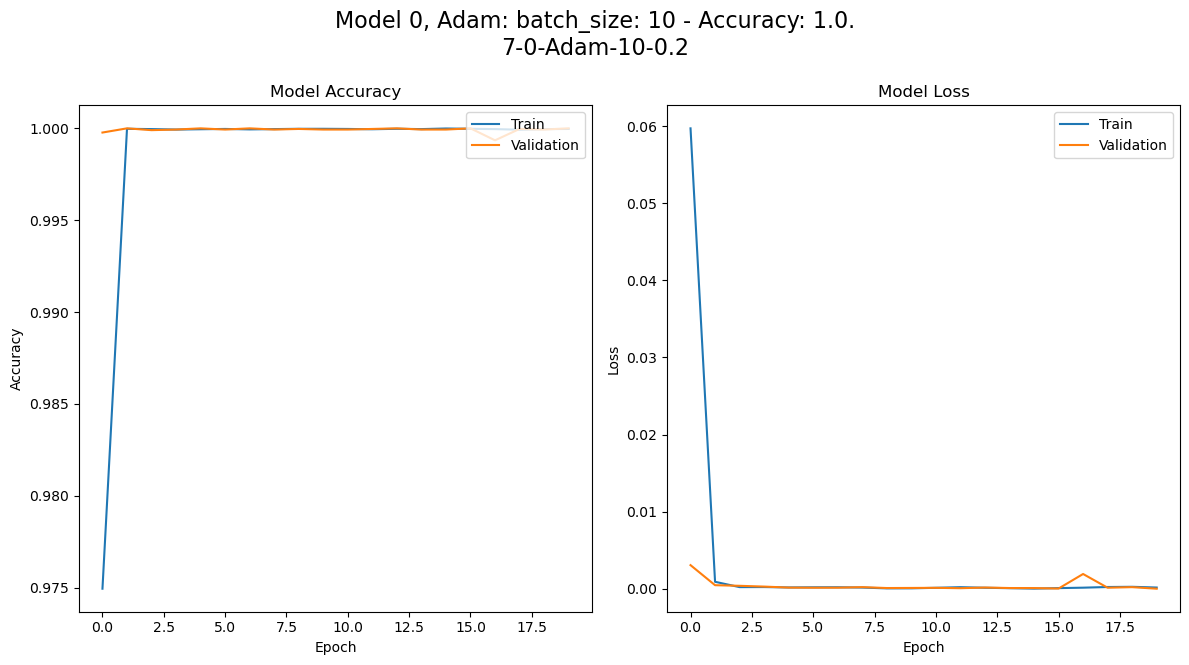

8-0-Adam-10-0.3
1439/1439 [==============================] - 0s 226us/step
8-0-Adam-10-0.3


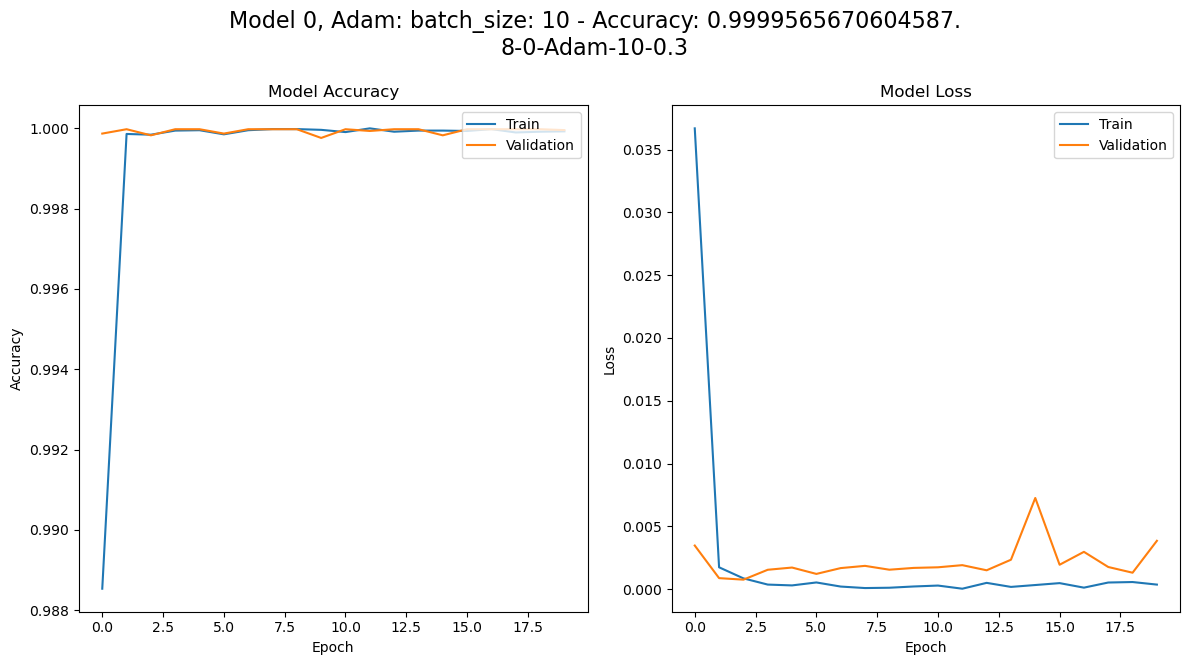

9-0-SGD-100-0.1
480/480 [==============================] - 0s 236us/step
9-0-SGD-100-0.1


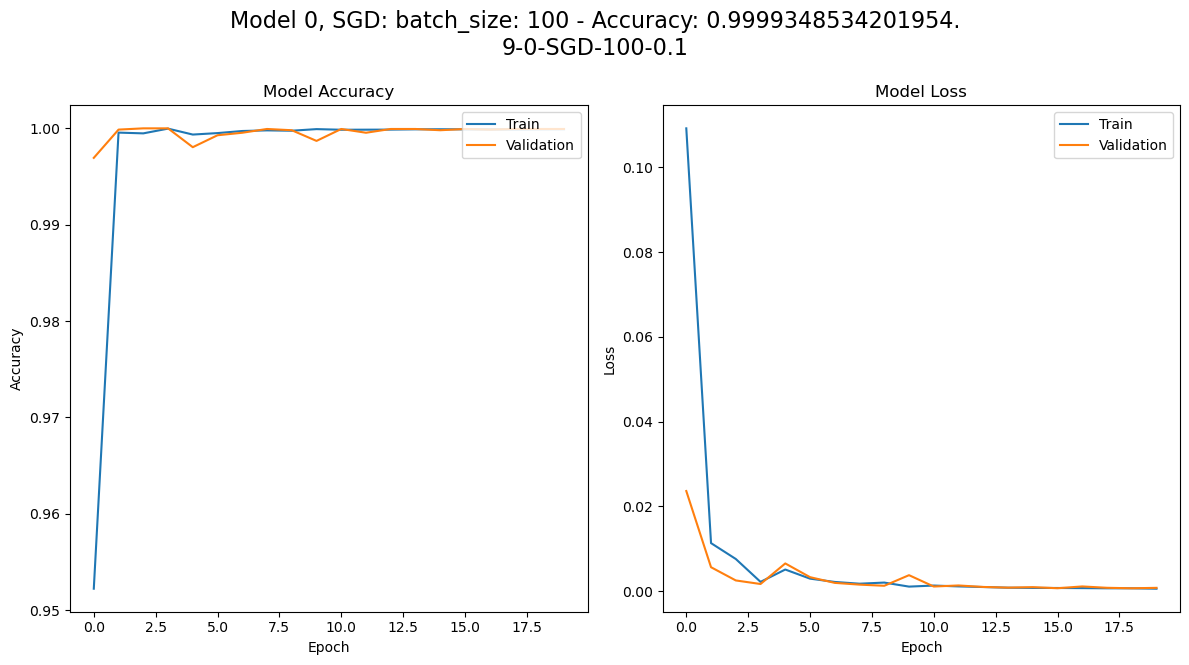

10-0-SGD-100-0.2
960/960 [==============================] - 0s 234us/step
10-0-SGD-100-0.2


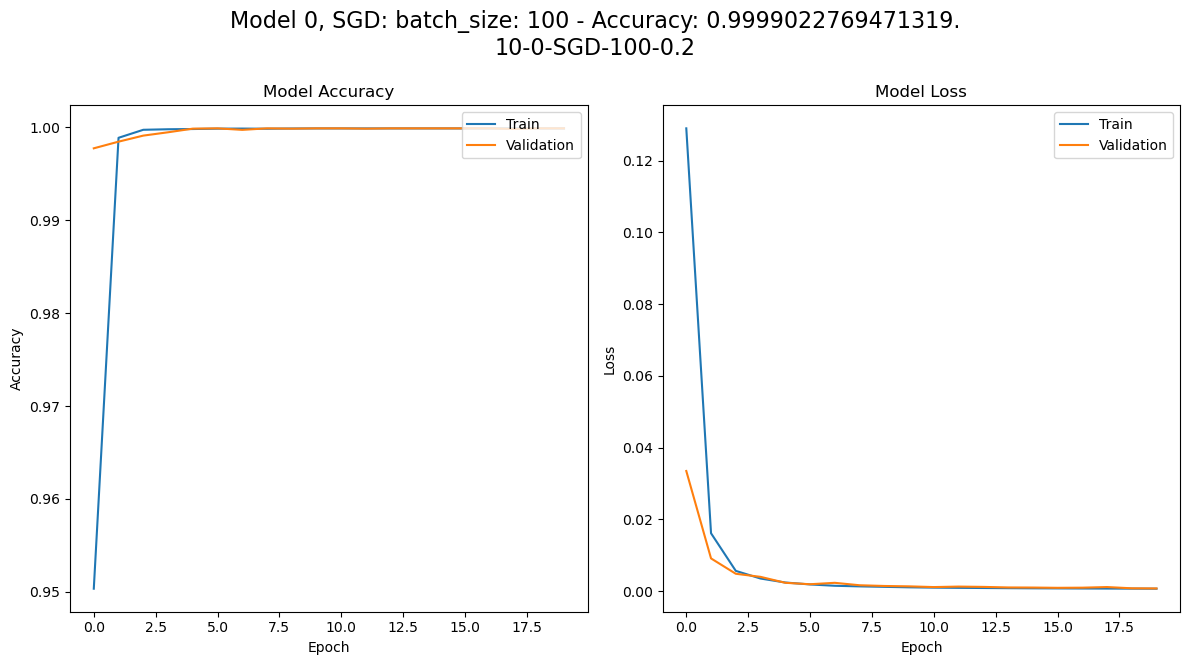

11-0-SGD-100-0.3
1439/1439 [==============================] - 0s 229us/step
11-0-SGD-100-0.3


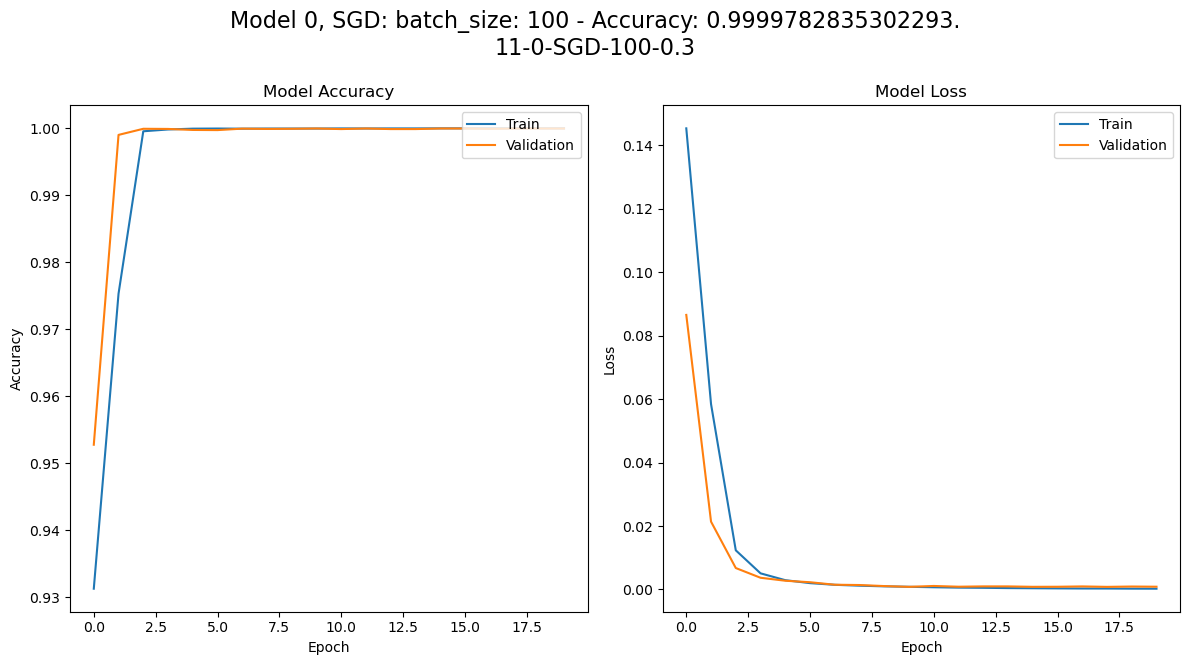

12-0-SGD-50-0.1
480/480 [==============================] - 0s 241us/step
12-0-SGD-50-0.1


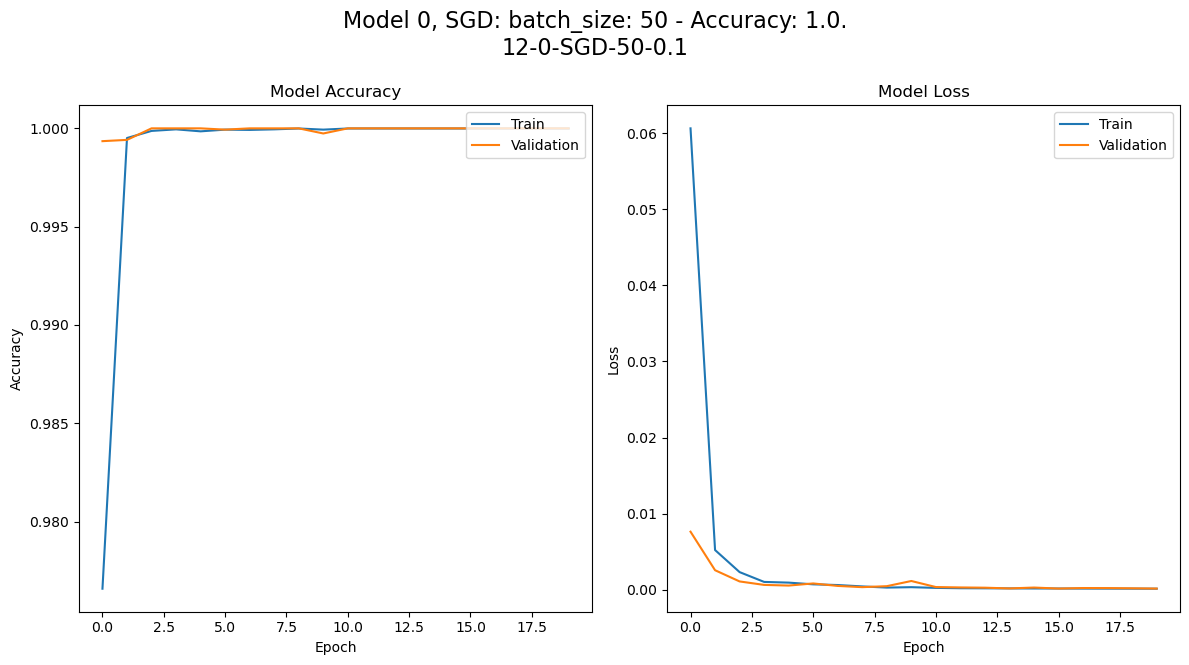

13-0-SGD-50-0.2
960/960 [==============================] - 0s 225us/step
13-0-SGD-50-0.2


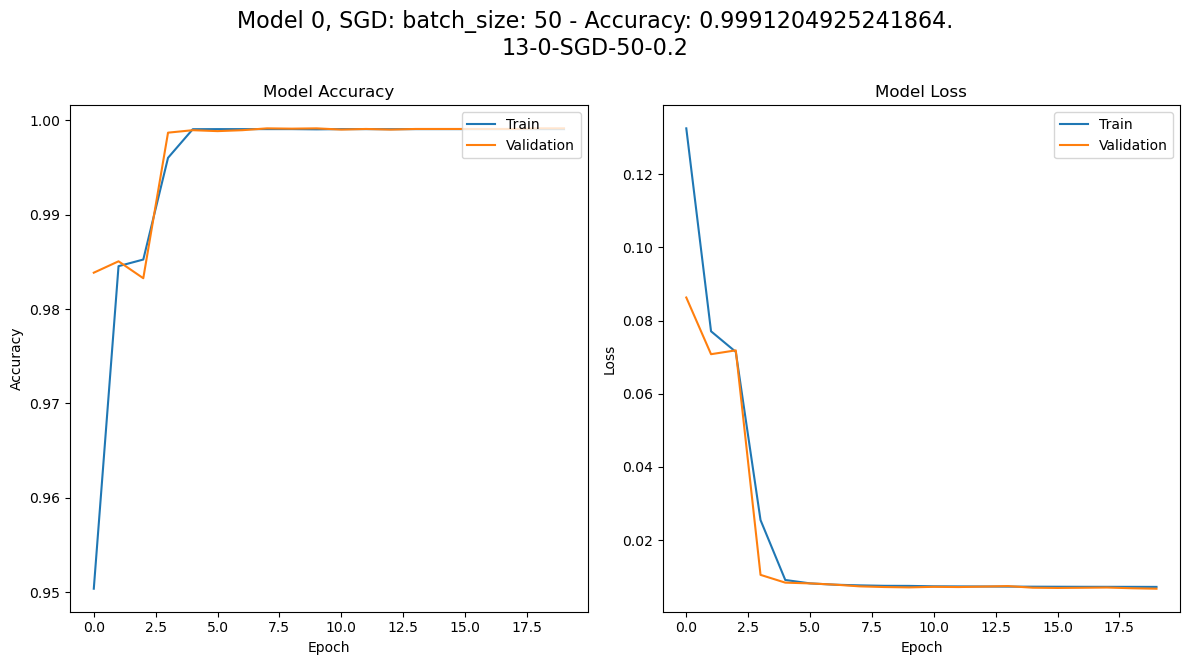

14-0-SGD-50-0.3
1439/1439 [==============================] - 0s 236us/step
14-0-SGD-50-0.3


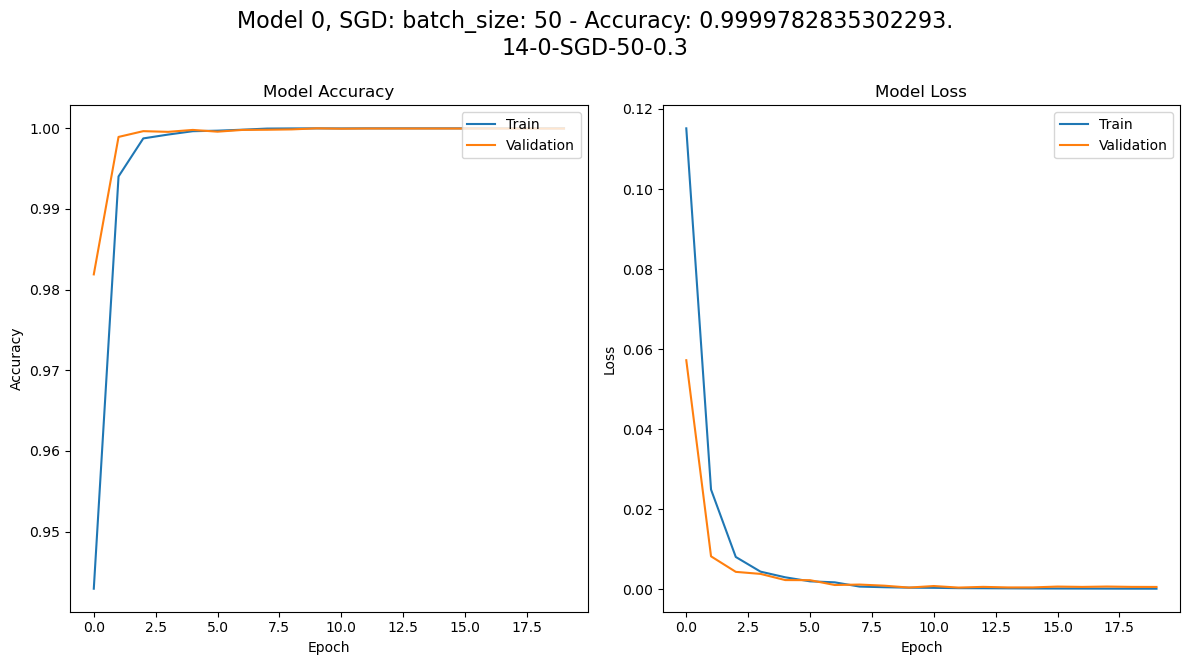

15-0-SGD-10-0.1
480/480 [==============================] - 0s 244us/step
15-0-SGD-10-0.1


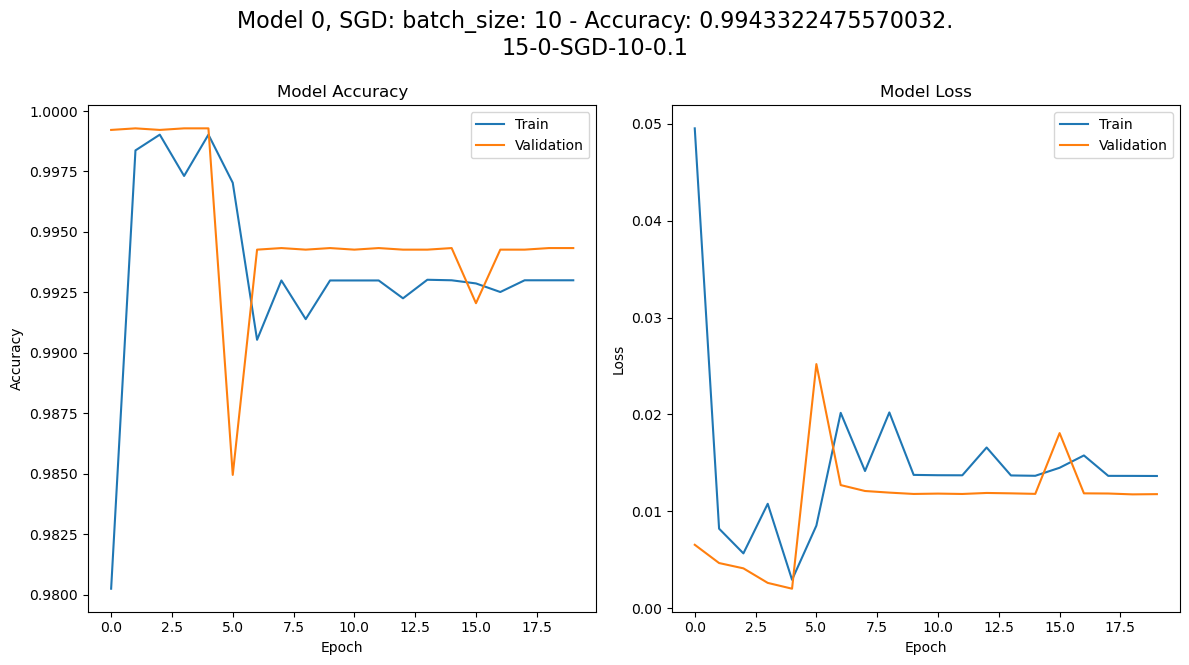

16-0-SGD-10-0.2
960/960 [==============================] - 0s 293us/step
16-0-SGD-10-0.2


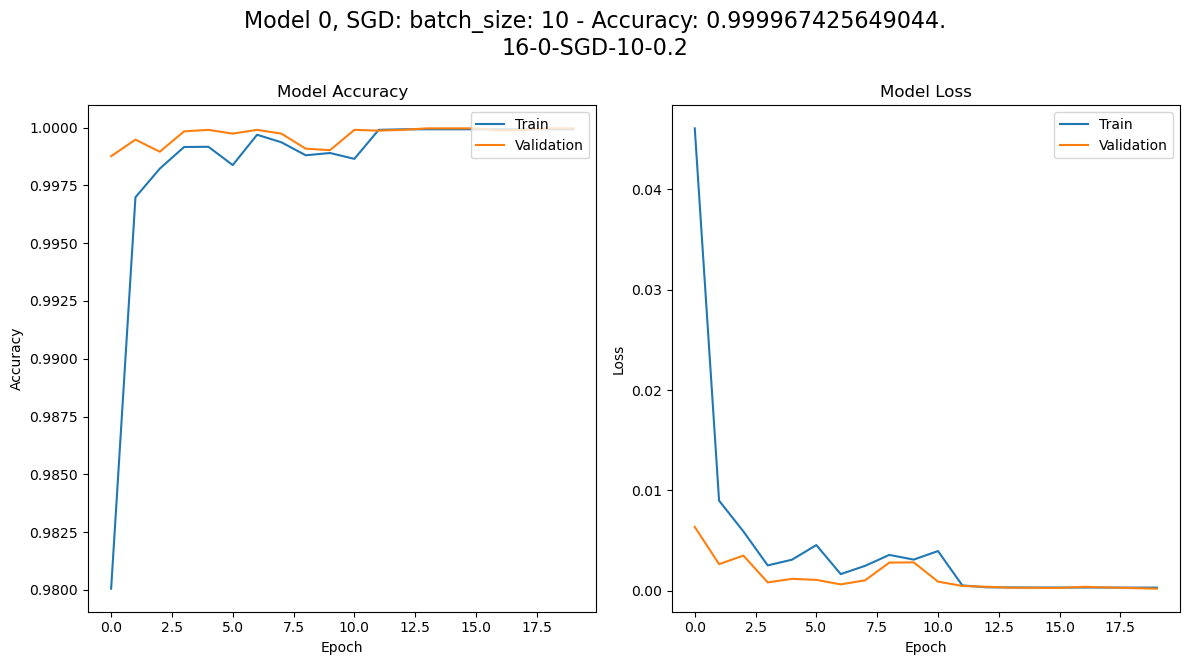

17-0-SGD-10-0.3
1439/1439 [==============================] - 0s 226us/step
17-0-SGD-10-0.3


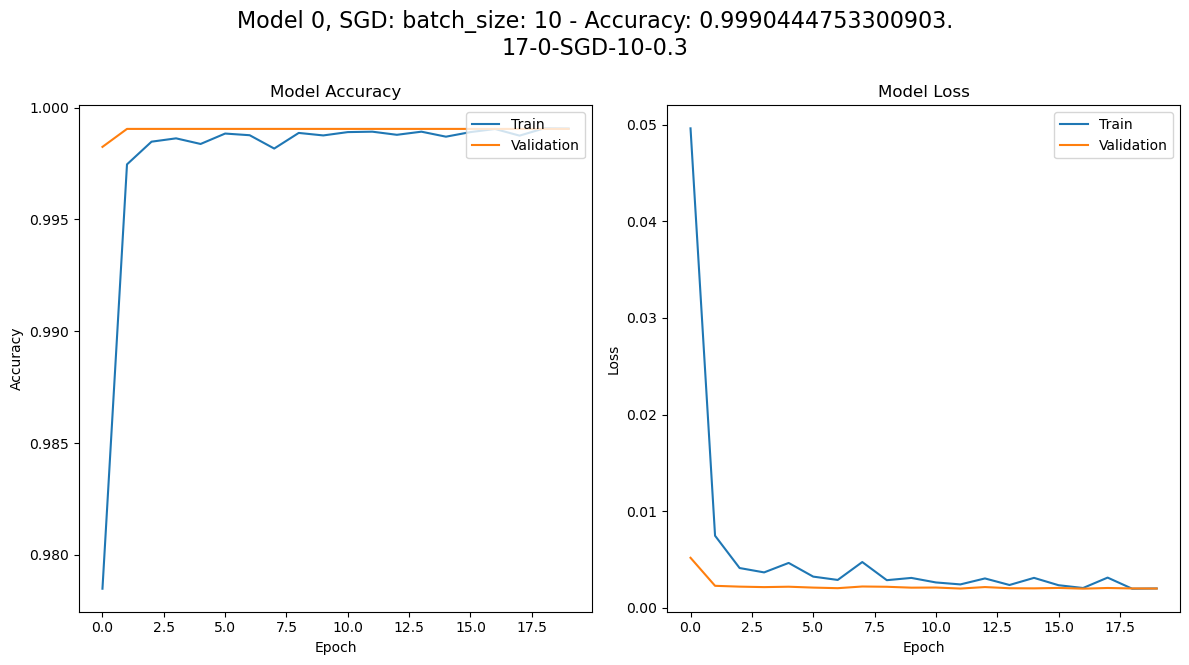

18-0-RMSprop-100-0.1
480/480 [==============================] - 0s 240us/step
18-0-RMSprop-100-0.1


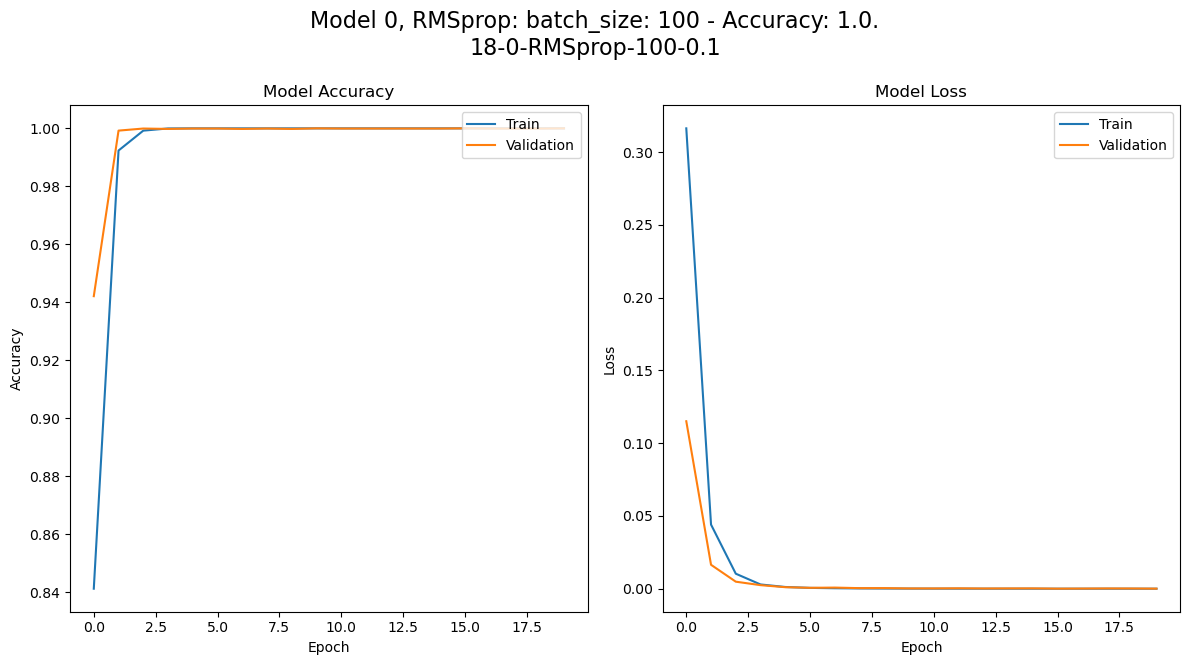

19-0-RMSprop-100-0.2
960/960 [==============================] - 0s 228us/step
19-0-RMSprop-100-0.2


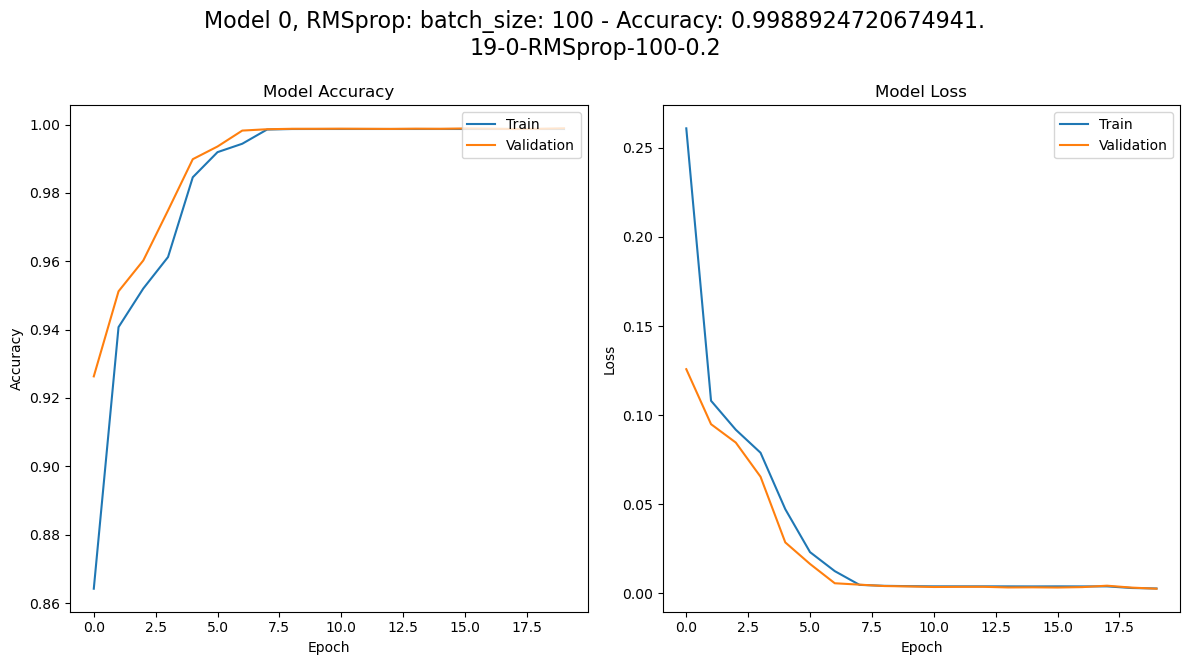

20-0-RMSprop-100-0.3
1439/1439 [==============================] - 0s 230us/step
20-0-RMSprop-100-0.3


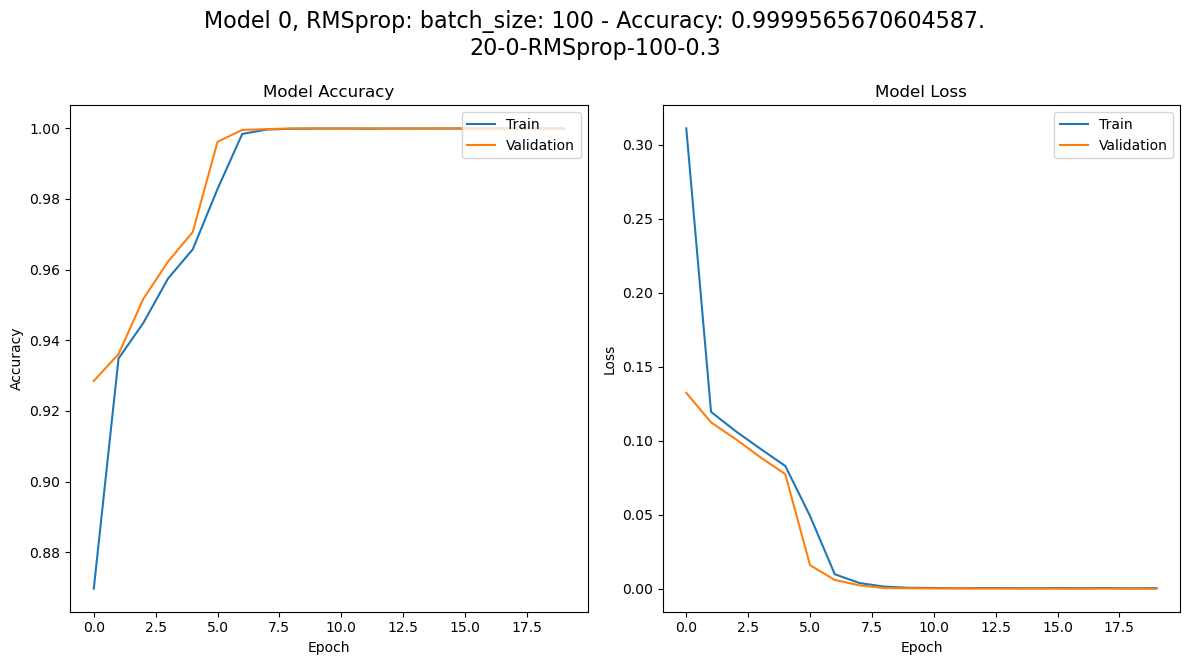

21-0-RMSprop-50-0.1
480/480 [==============================] - 0s 243us/step
21-0-RMSprop-50-0.1


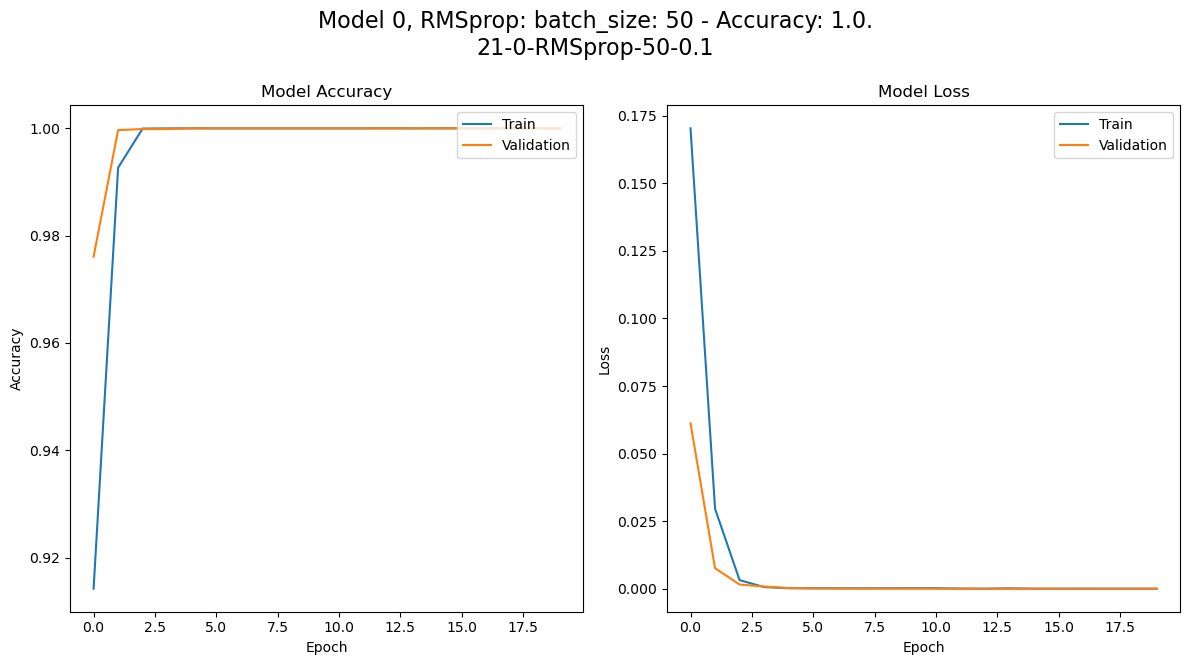

22-0-RMSprop-50-0.2
960/960 [==============================] - 0s 232us/step
22-0-RMSprop-50-0.2


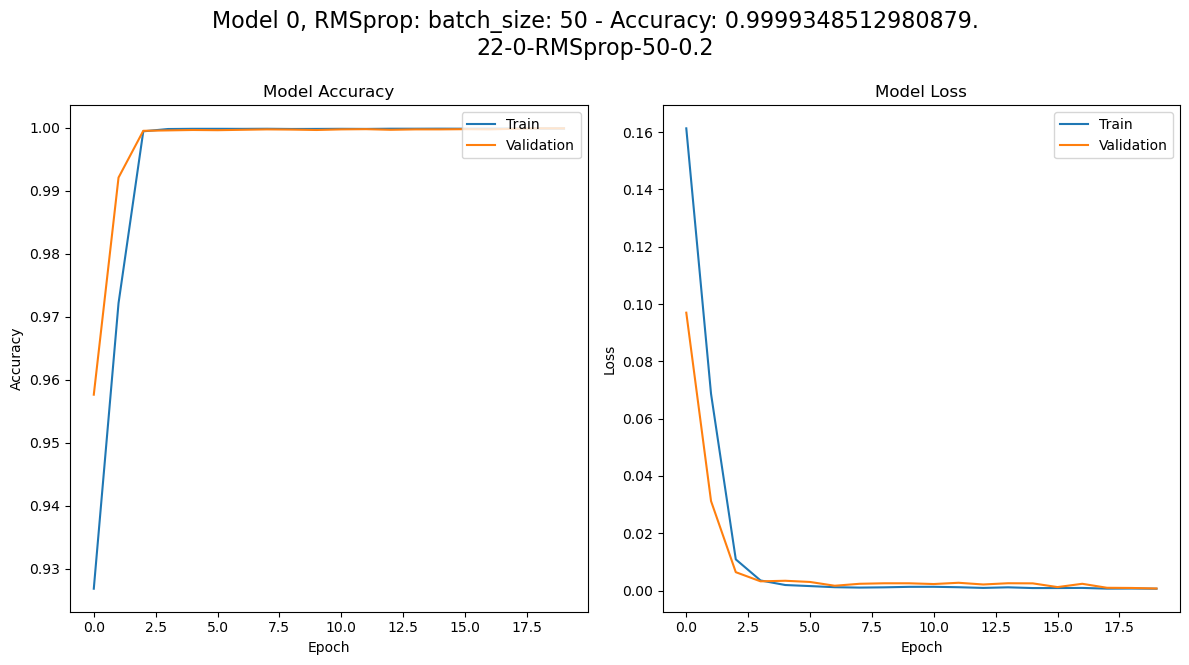

23-0-RMSprop-50-0.3
1439/1439 [==============================] - 0s 230us/step
23-0-RMSprop-50-0.3


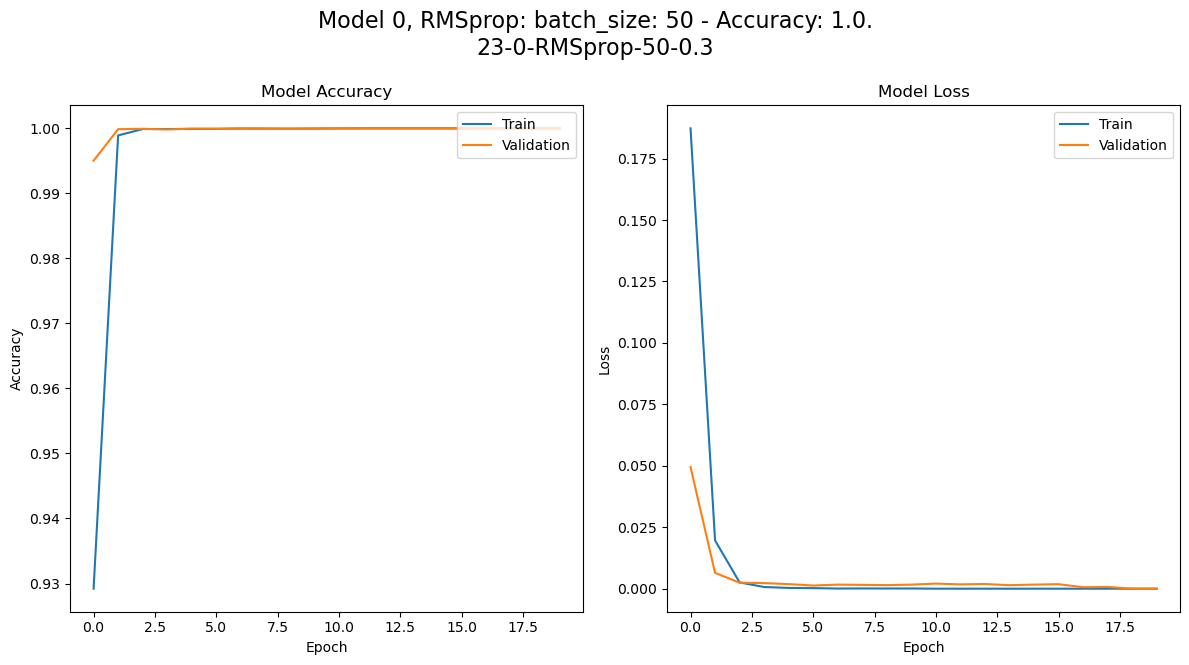

24-0-RMSprop-10-0.1
480/480 [==============================] - 0s 239us/step
24-0-RMSprop-10-0.1


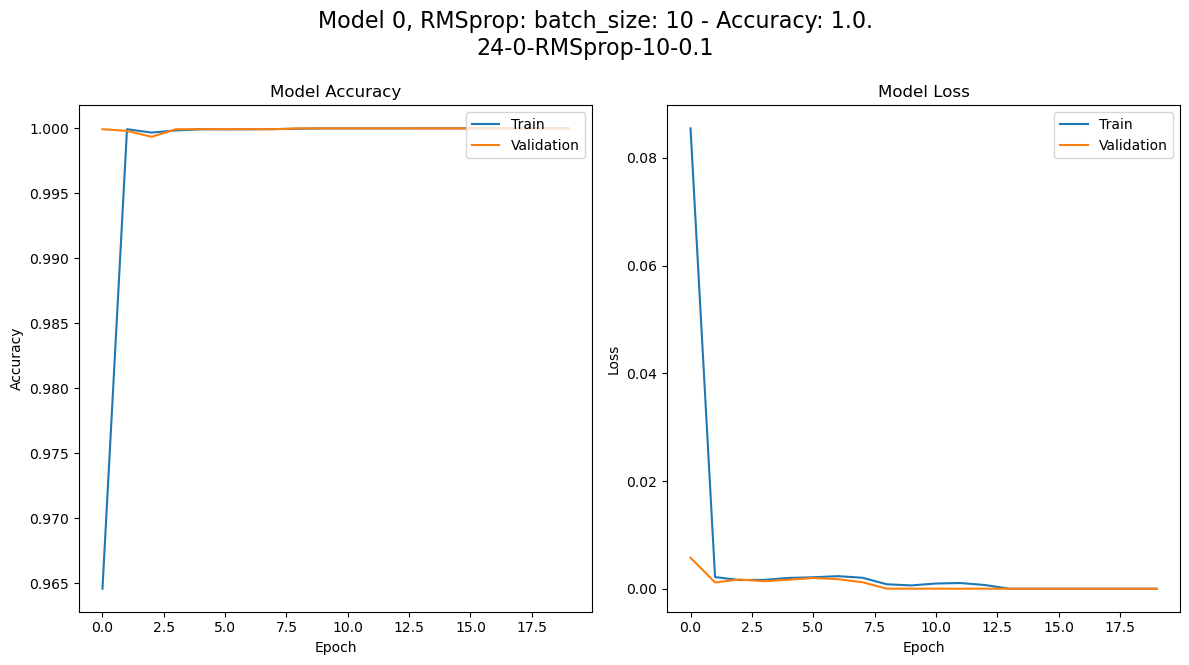

25-0-RMSprop-10-0.2
960/960 [==============================] - 0s 232us/step
25-0-RMSprop-10-0.2


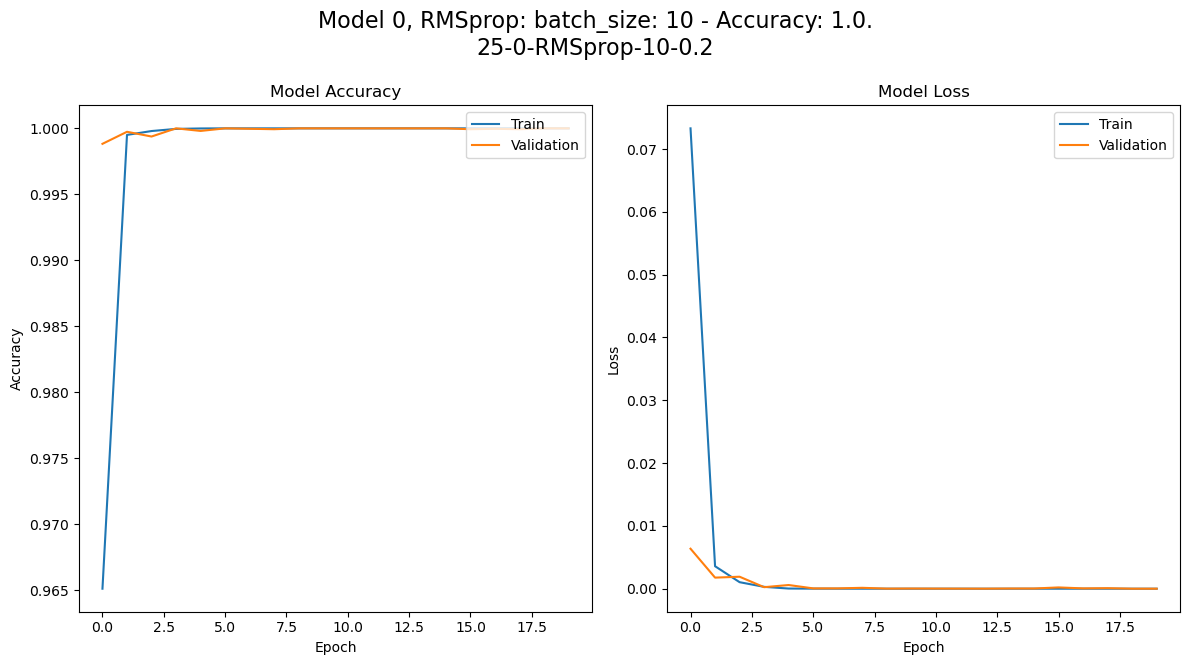

26-0-RMSprop-10-0.3
1439/1439 [==============================] - 0s 231us/step
26-0-RMSprop-10-0.3


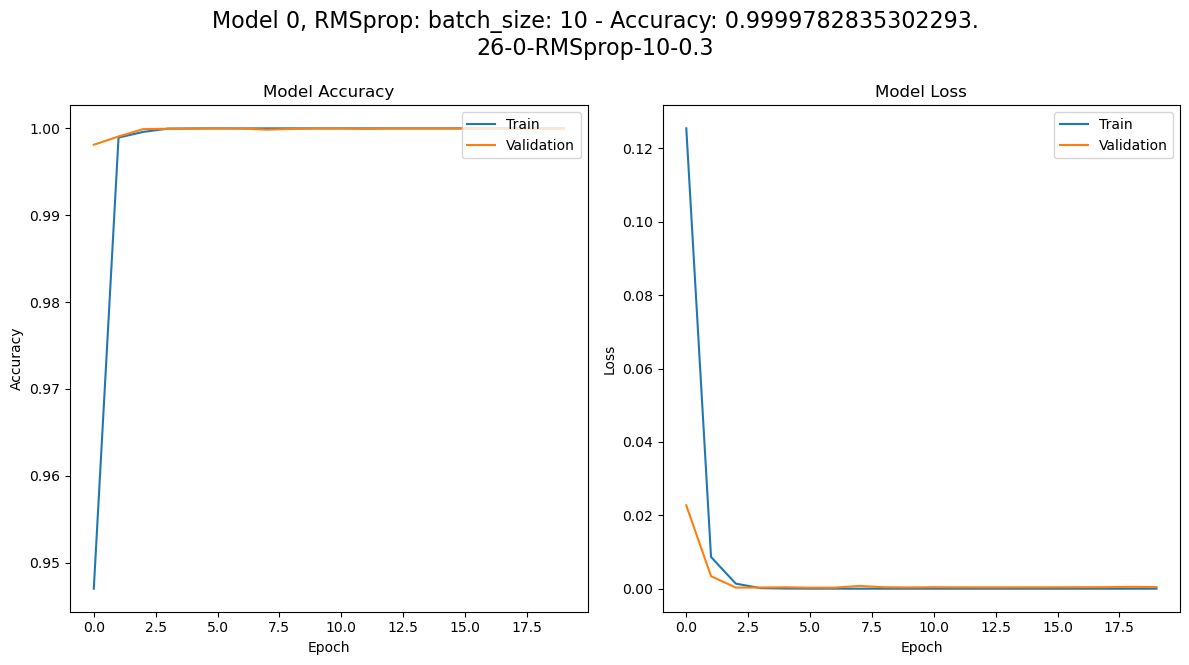

27-1-Adam-100-0.1
480/480 [==============================] - 0s 242us/step
27-1-Adam-100-0.1


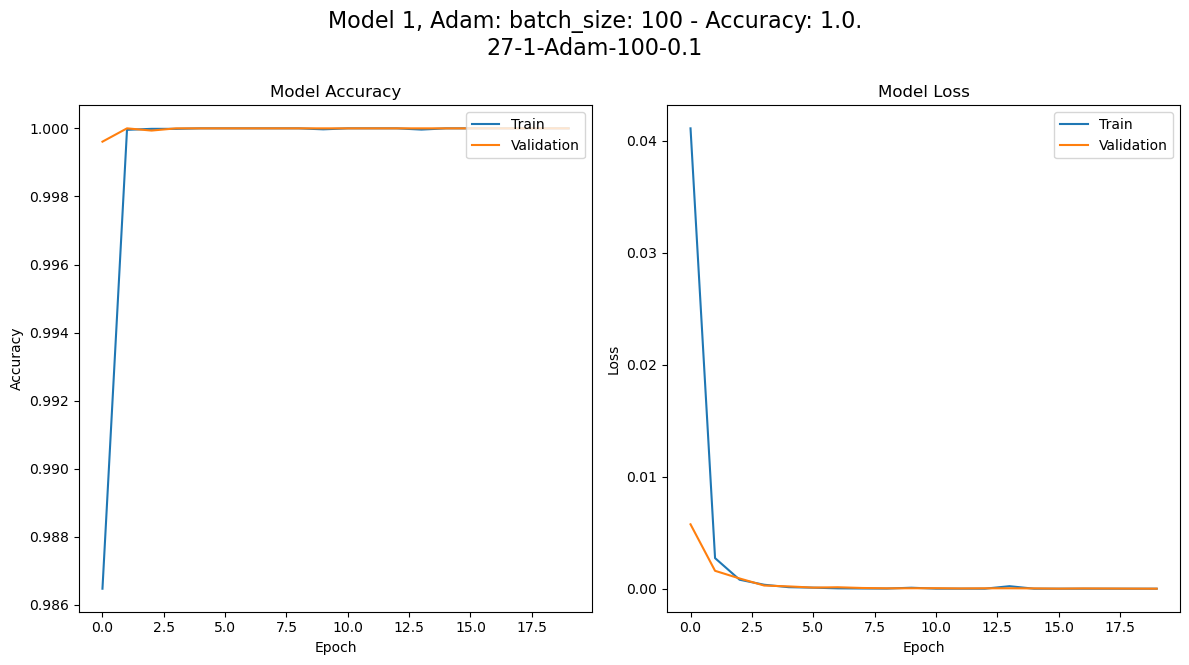

28-1-Adam-100-0.2
960/960 [==============================] - 0s 236us/step
28-1-Adam-100-0.2


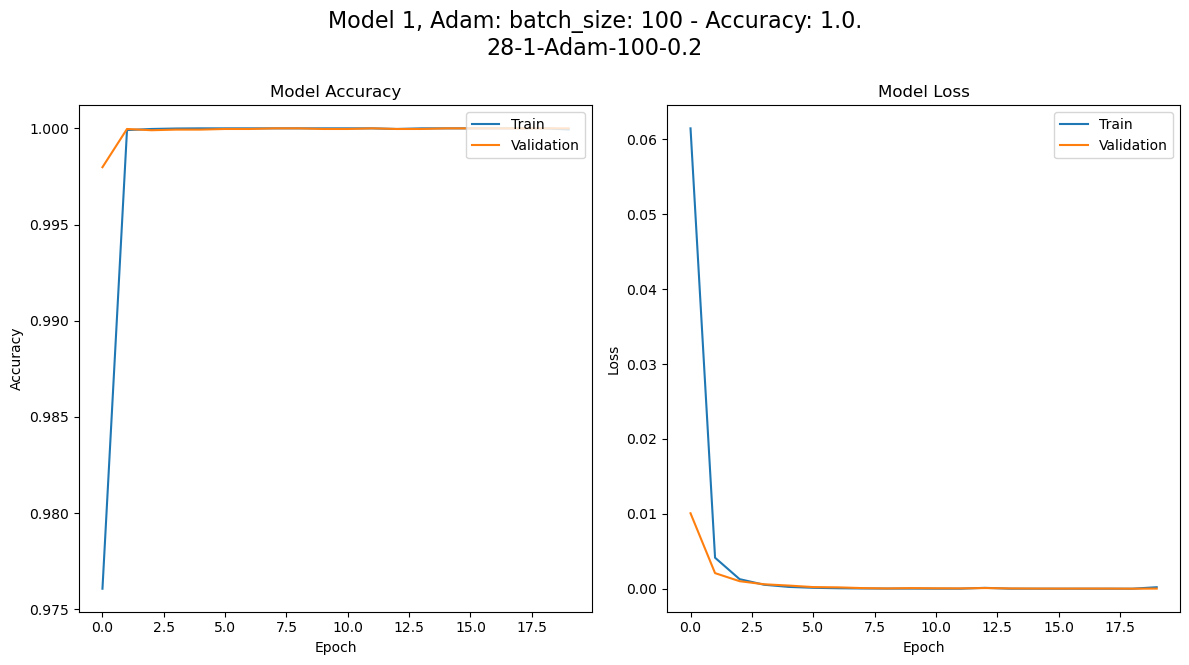

29-1-Adam-100-0.3
1439/1439 [==============================] - 0s 233us/step
29-1-Adam-100-0.3


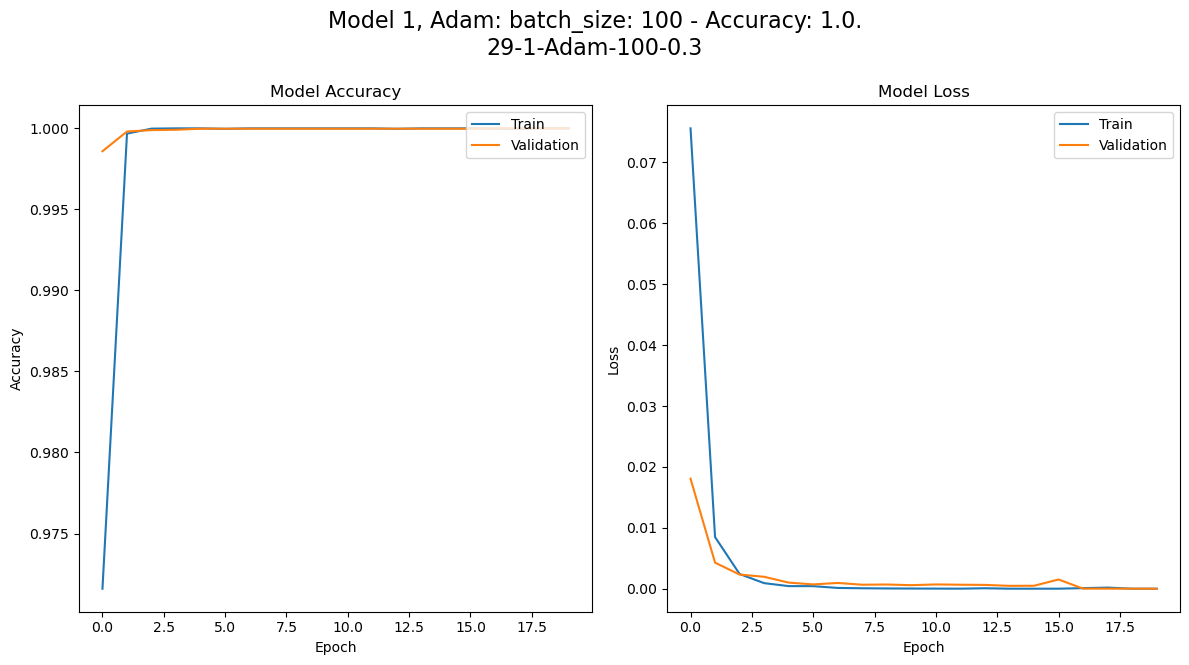

30-1-Adam-50-0.1
480/480 [==============================] - 0s 240us/step
30-1-Adam-50-0.1


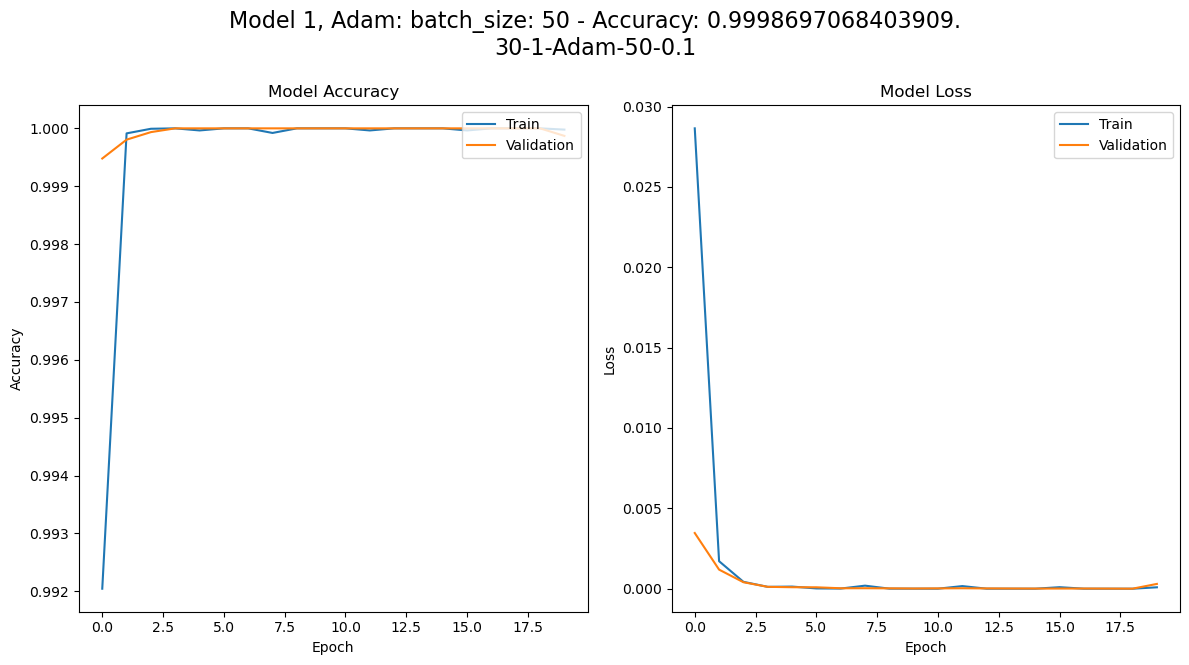

31-1-Adam-50-0.2
960/960 [==============================] - 0s 233us/step
31-1-Adam-50-0.2


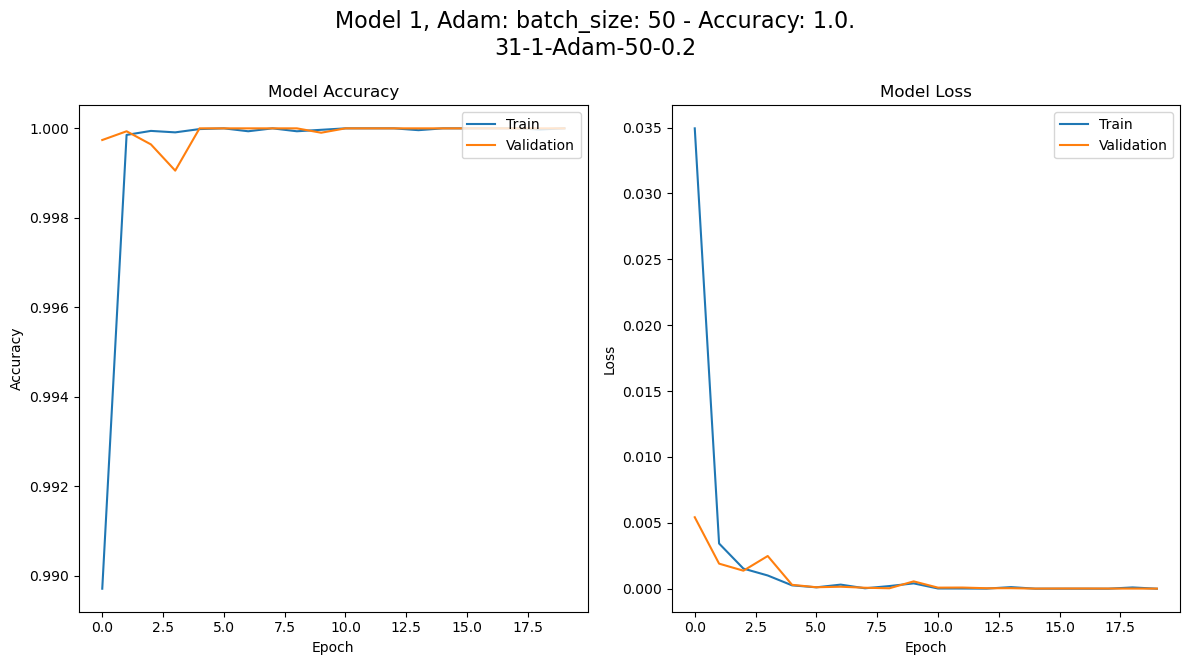

32-1-Adam-50-0.3
1439/1439 [==============================] - 0s 236us/step
32-1-Adam-50-0.3


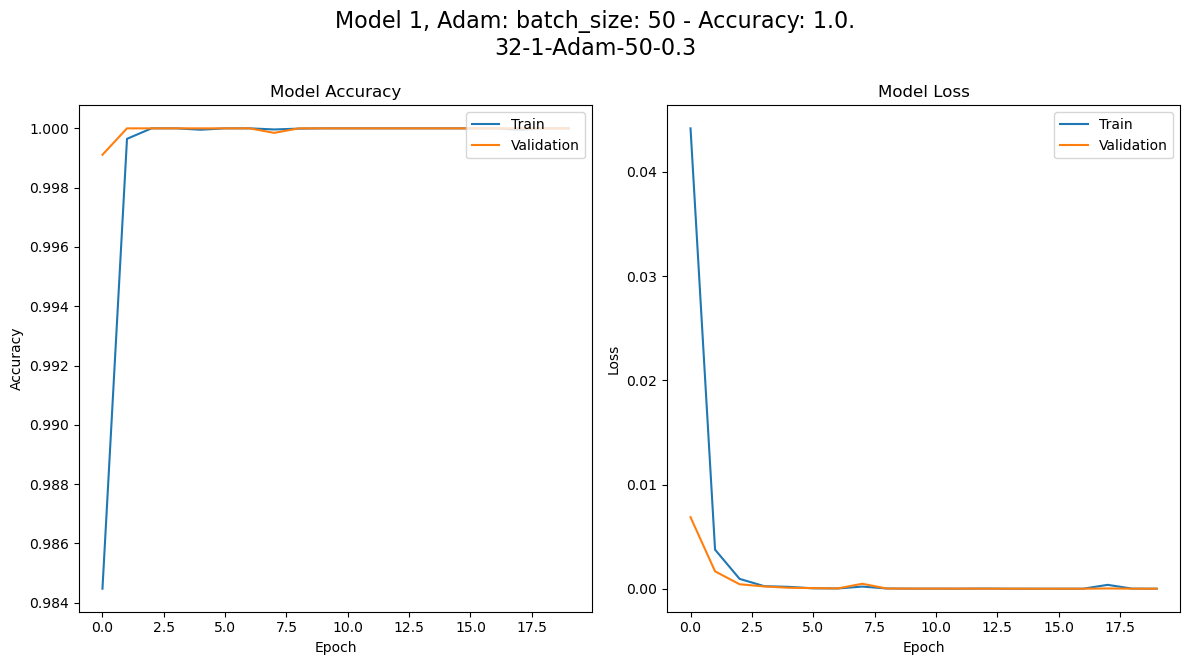

33-1-Adam-10-0.1
480/480 [==============================] - 0s 254us/step
33-1-Adam-10-0.1


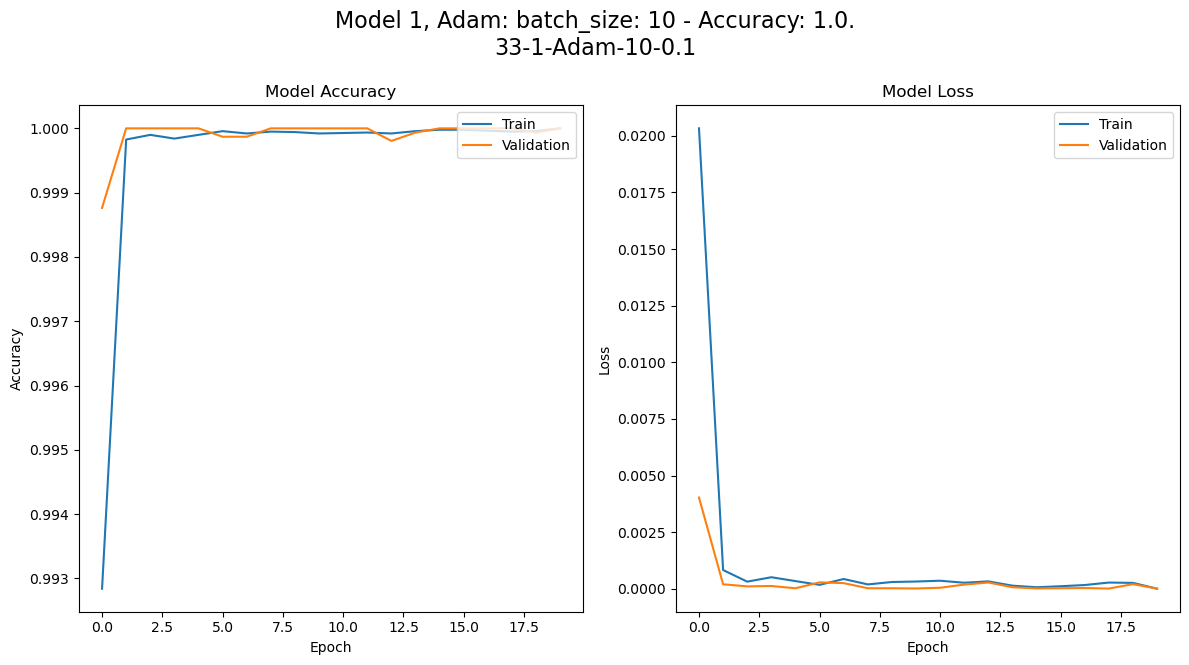

34-1-Adam-10-0.2
960/960 [==============================] - 0s 234us/step
34-1-Adam-10-0.2


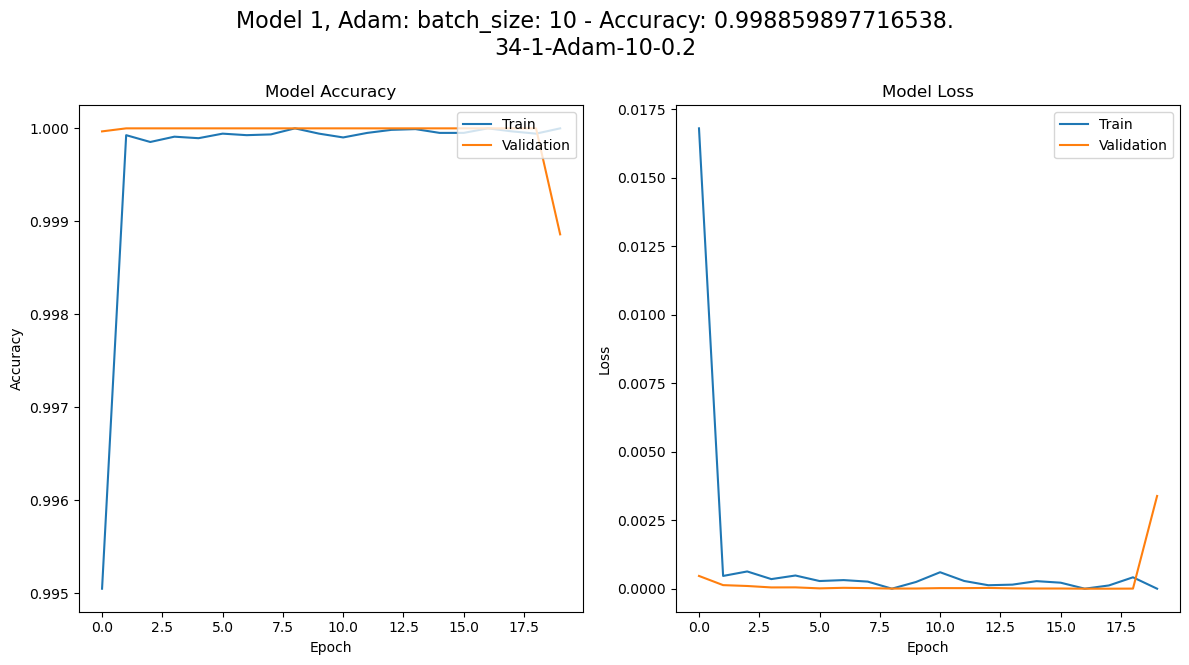

35-1-Adam-10-0.3
1439/1439 [==============================] - 0s 231us/step
35-1-Adam-10-0.3


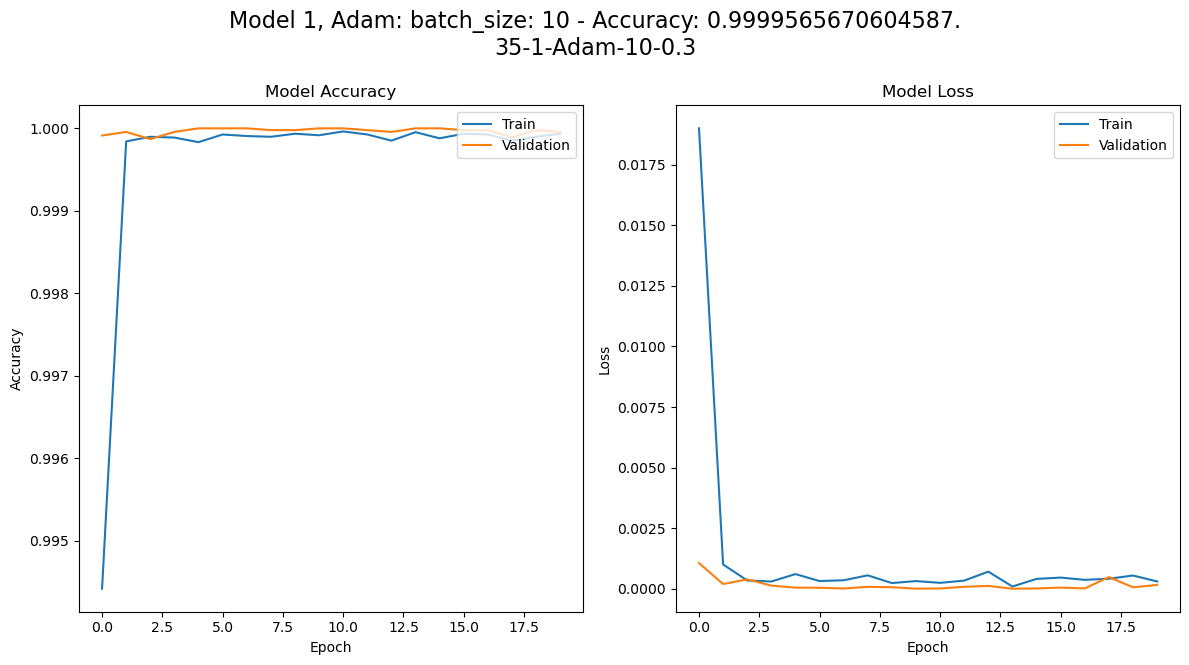

36-1-SGD-100-0.1
480/480 [==============================] - 0s 235us/step
36-1-SGD-100-0.1


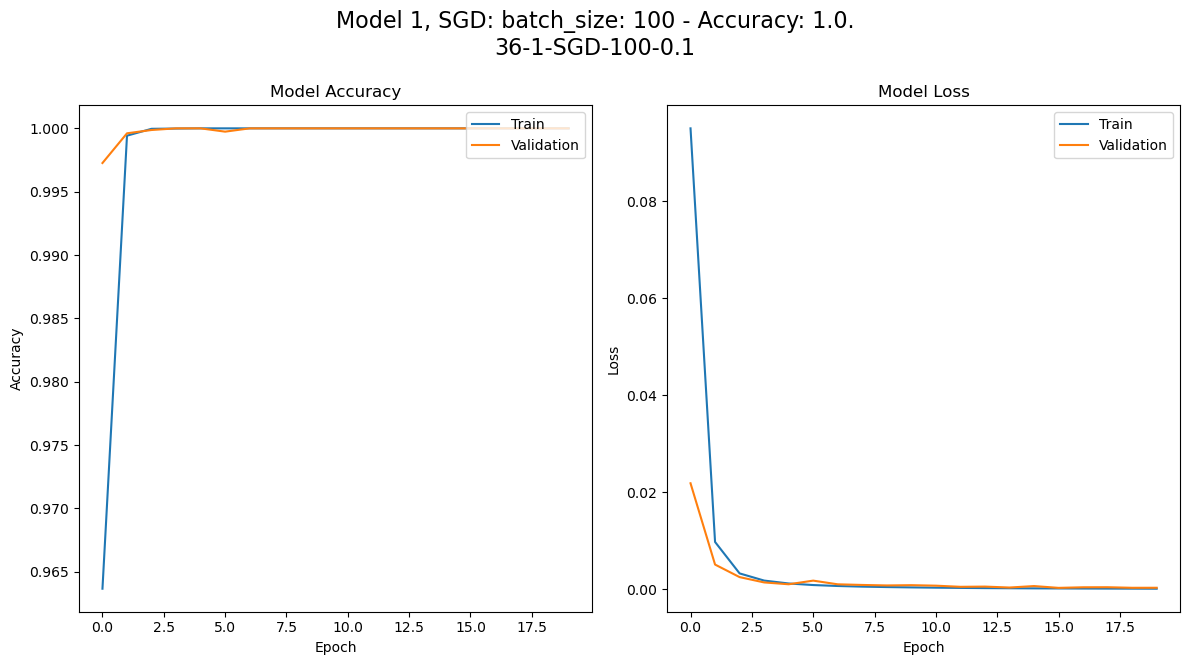

37-1-SGD-100-0.2
960/960 [==============================] - 0s 237us/step
37-1-SGD-100-0.2


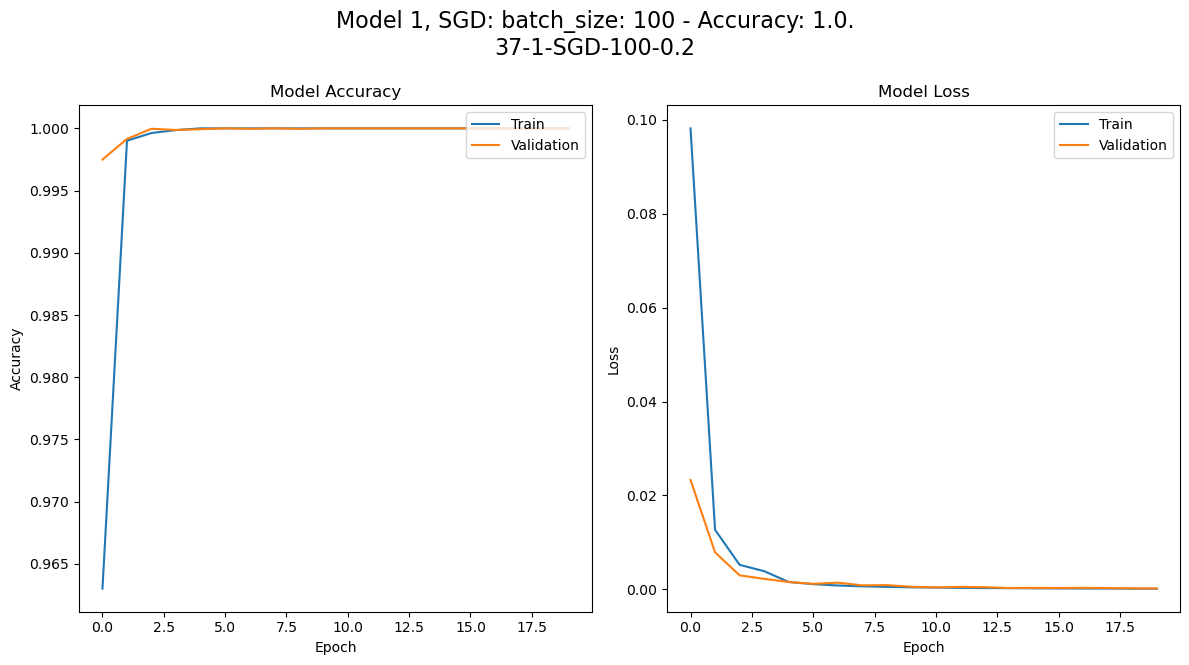

38-1-SGD-100-0.3
1439/1439 [==============================] - 0s 233us/step
38-1-SGD-100-0.3


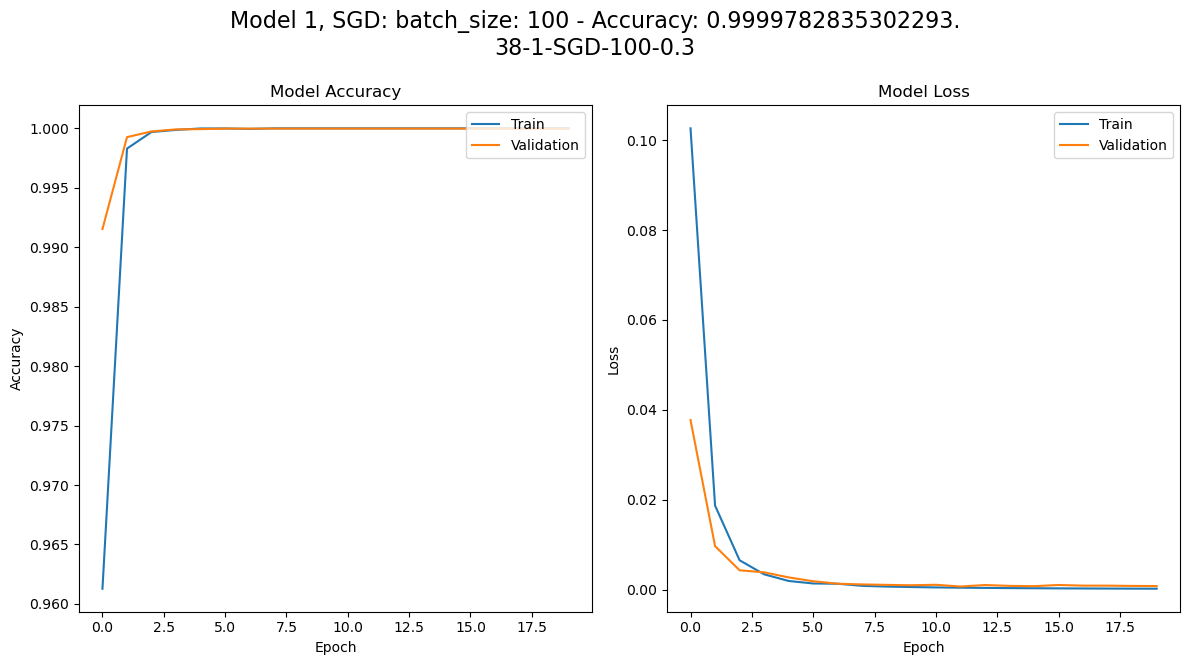

39-1-SGD-50-0.1
480/480 [==============================] - 0s 254us/step
39-1-SGD-50-0.1


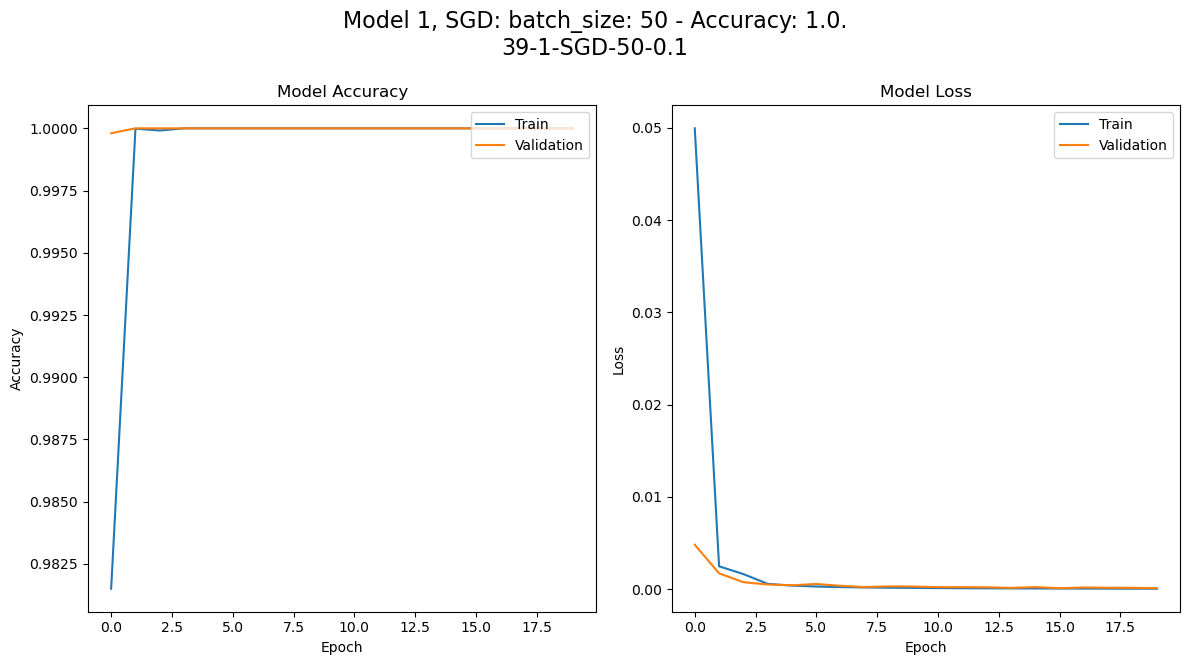

40-1-SGD-50-0.2
960/960 [==============================] - 0s 239us/step
40-1-SGD-50-0.2


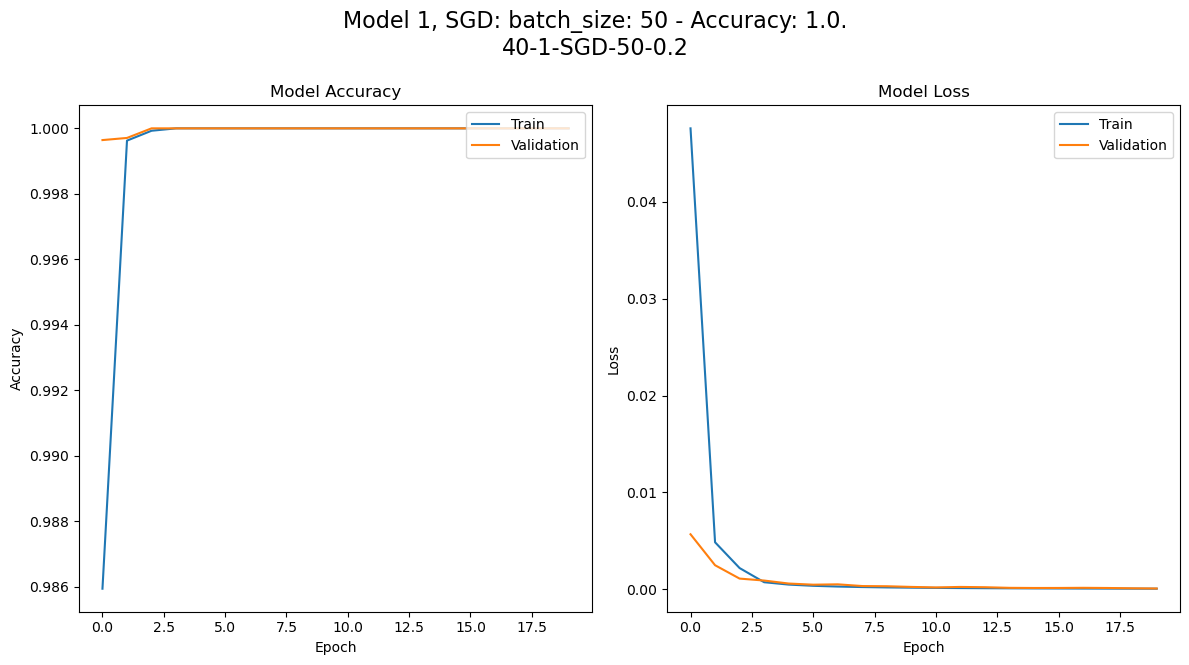

41-1-SGD-50-0.3
1439/1439 [==============================] - 0s 238us/step
41-1-SGD-50-0.3


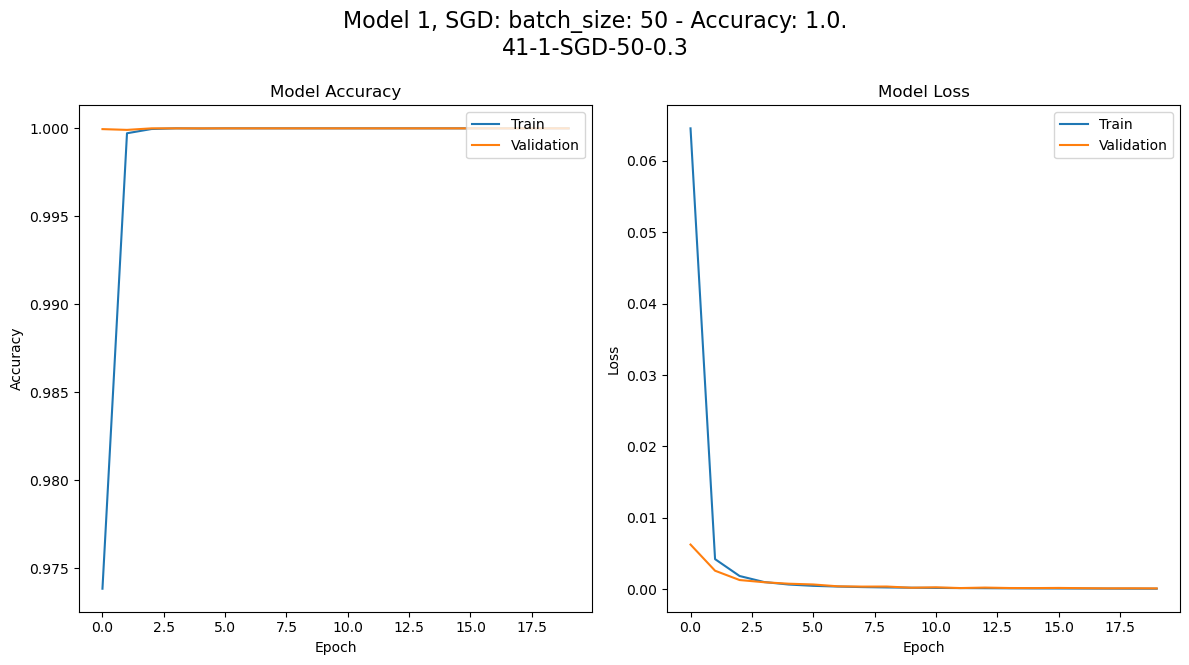

42-1-SGD-10-0.1
480/480 [==============================] - 0s 252us/step
42-1-SGD-10-0.1


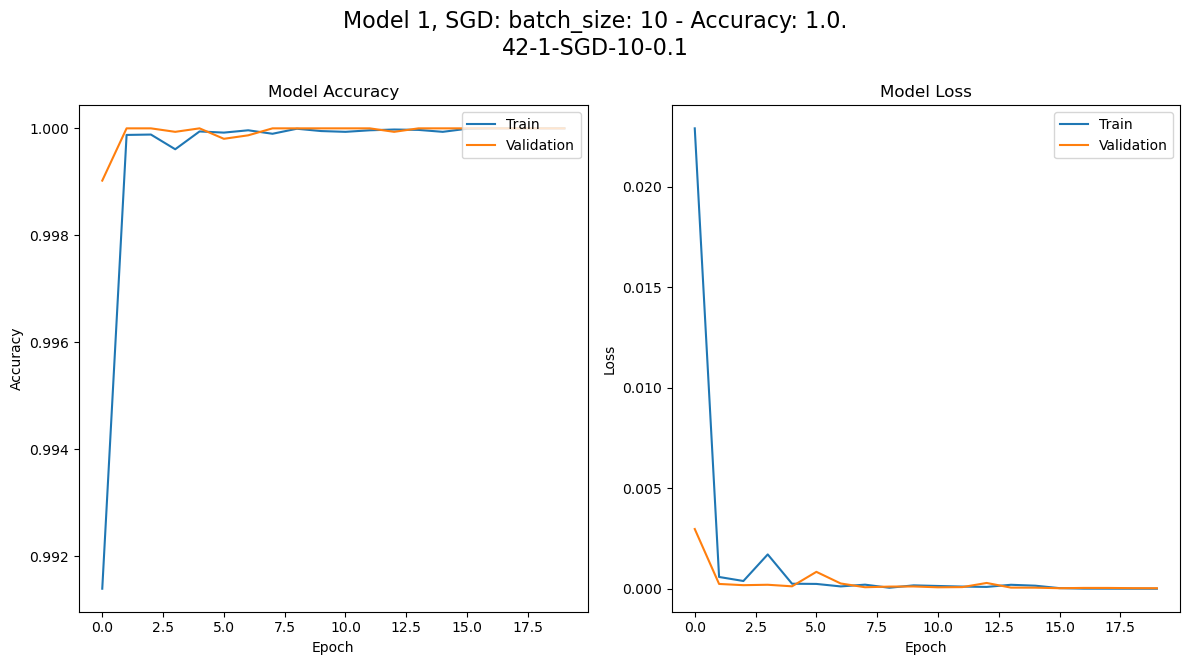

43-1-SGD-10-0.2
960/960 [==============================] - 0s 243us/step
43-1-SGD-10-0.2


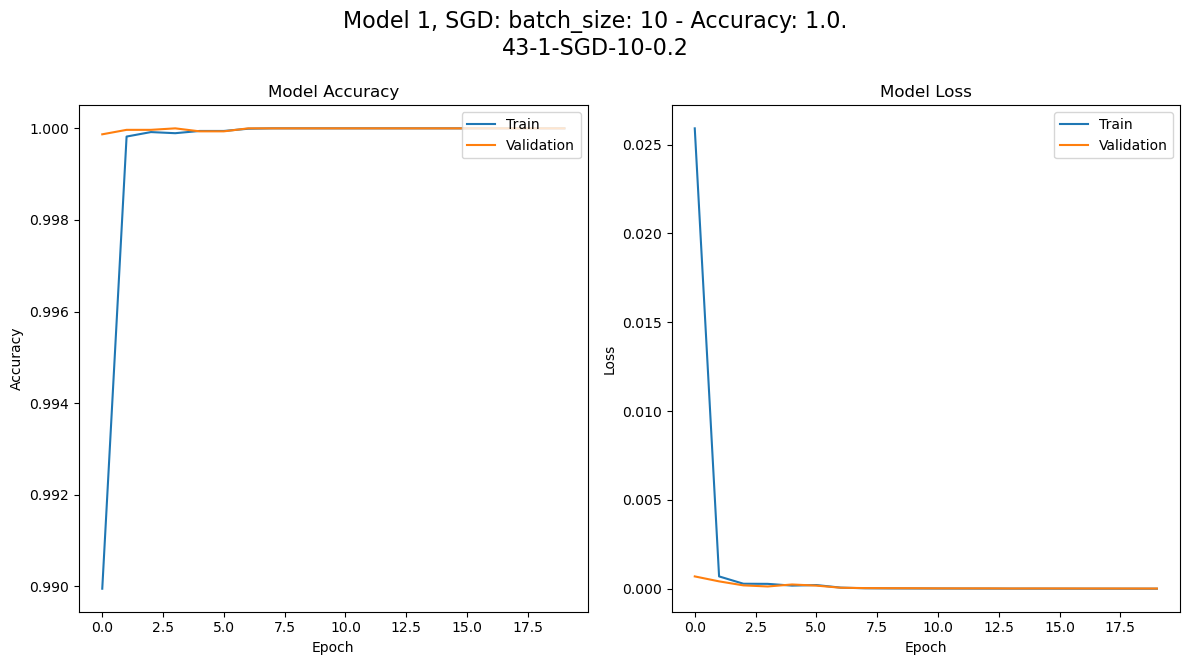

44-1-SGD-10-0.3
1439/1439 [==============================] - 0s 233us/step
44-1-SGD-10-0.3


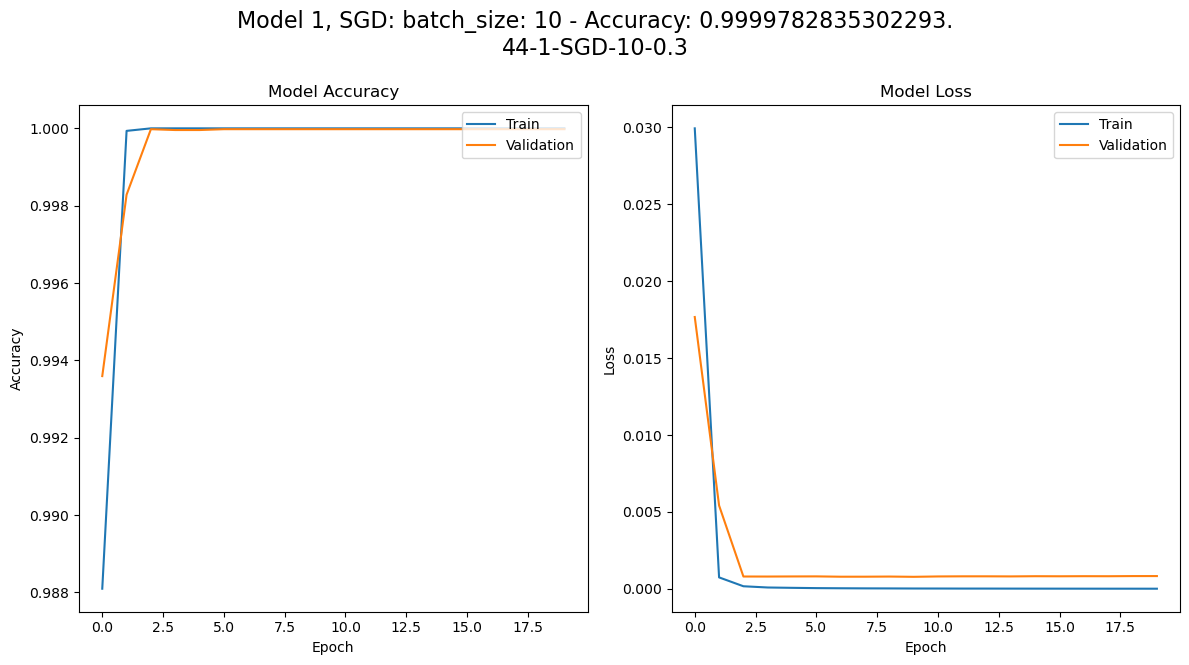

45-1-RMSprop-100-0.1
480/480 [==============================] - 0s 243us/step
45-1-RMSprop-100-0.1


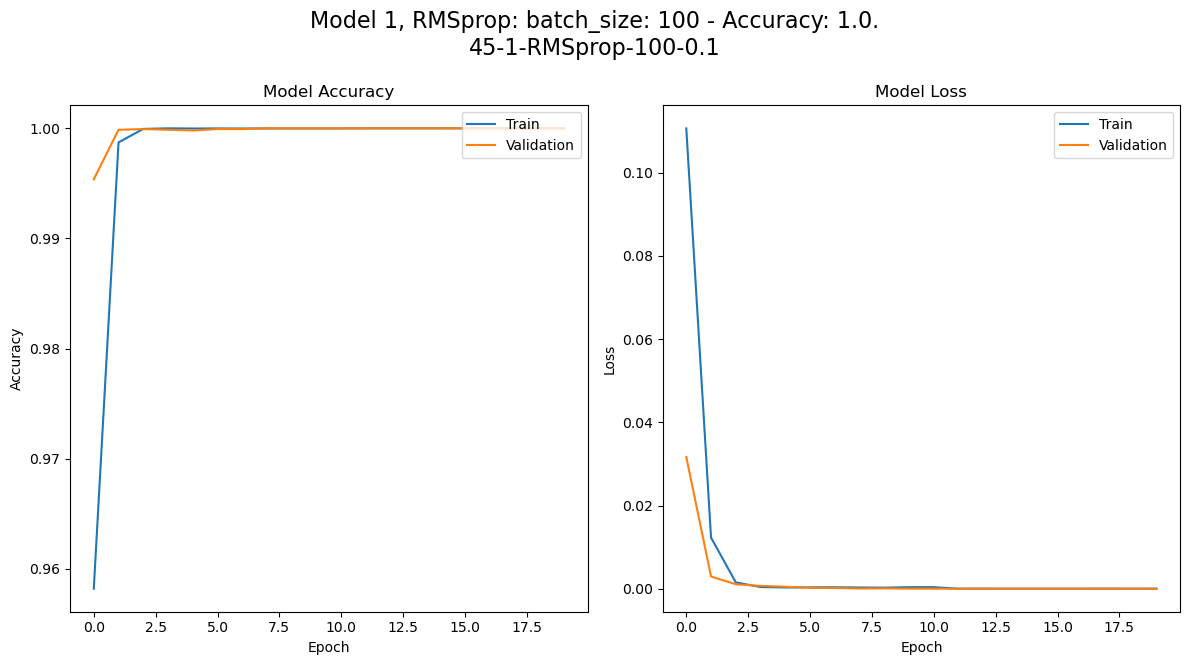

46-1-RMSprop-100-0.2
960/960 [==============================] - 0s 234us/step
46-1-RMSprop-100-0.2


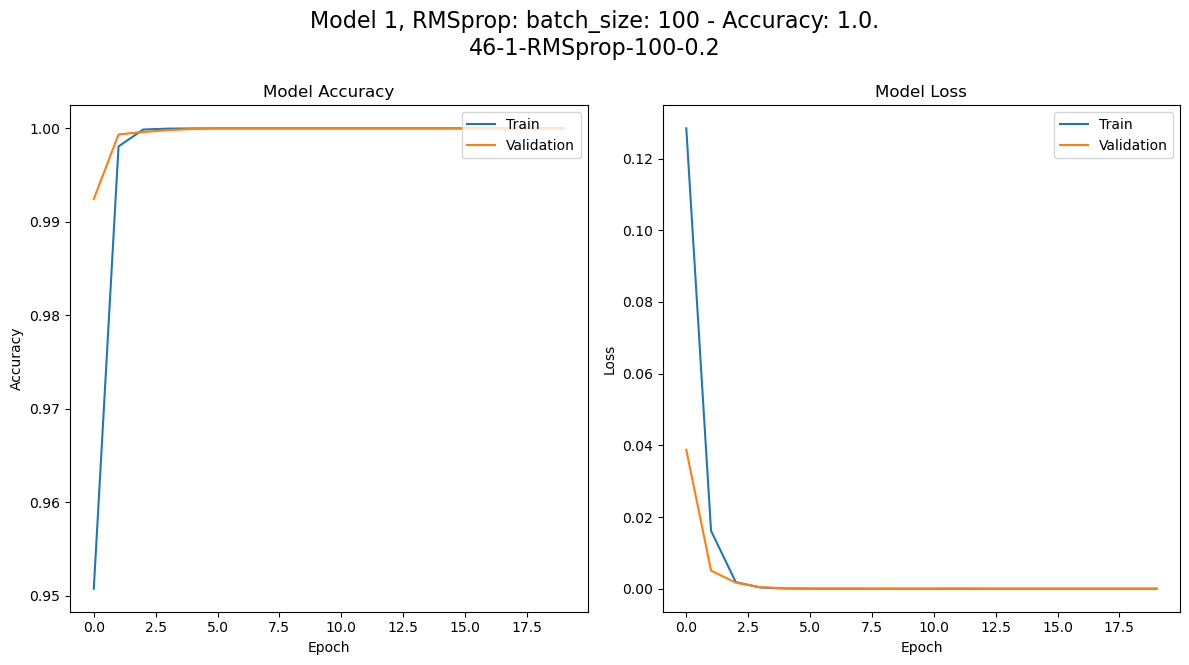

47-1-RMSprop-100-0.3
1439/1439 [==============================] - 0s 238us/step
47-1-RMSprop-100-0.3


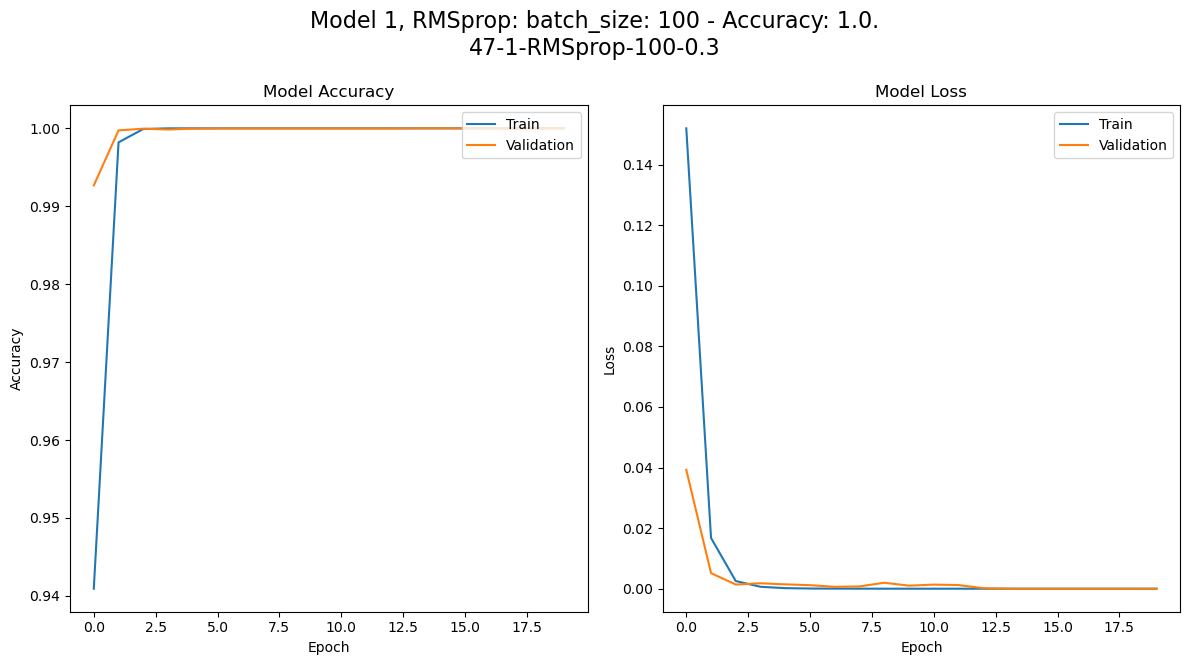

48-1-RMSprop-50-0.1
480/480 [==============================] - 0s 244us/step
48-1-RMSprop-50-0.1


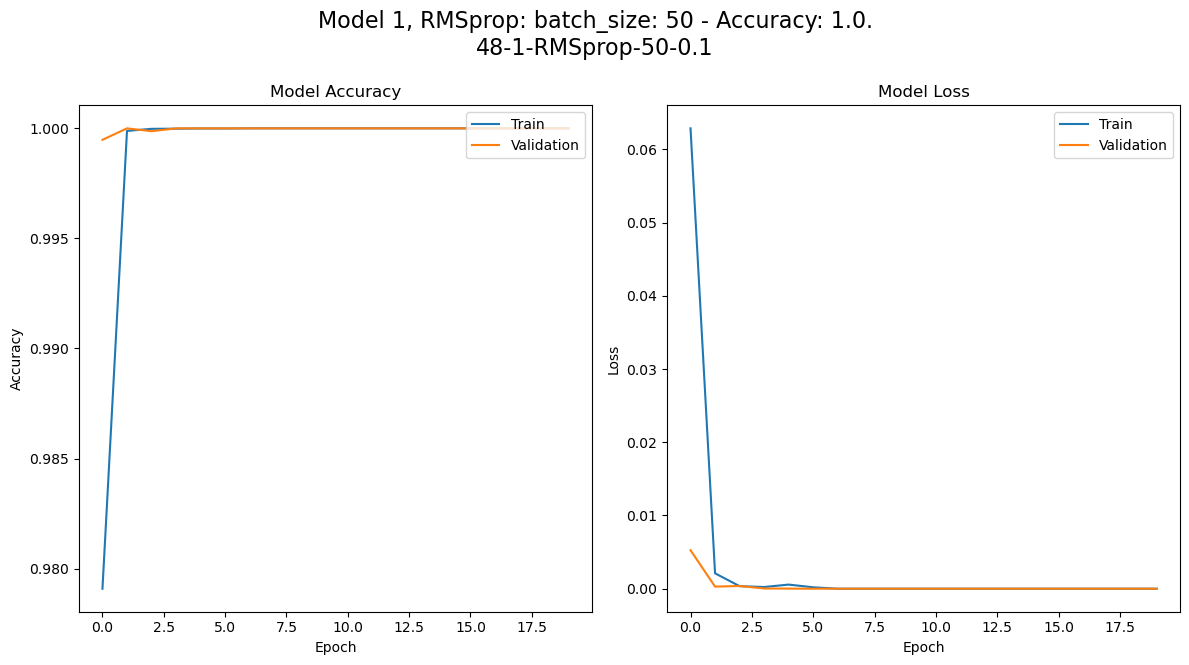

49-1-RMSprop-50-0.2
960/960 [==============================] - 0s 247us/step
49-1-RMSprop-50-0.2


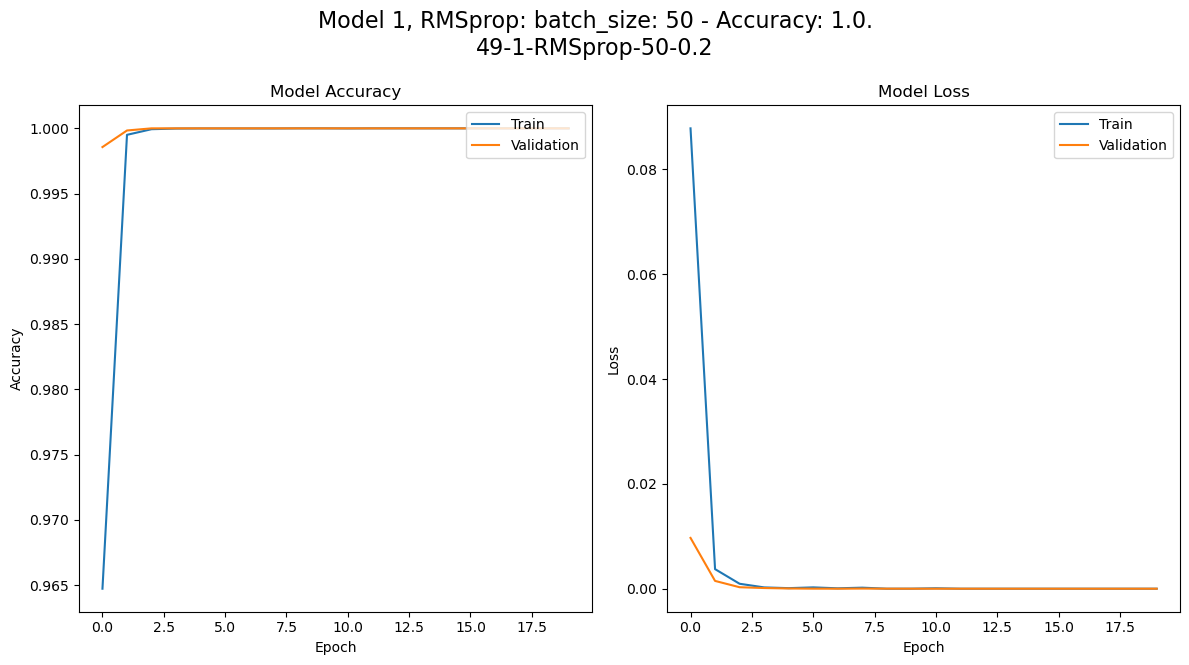

50-1-RMSprop-50-0.3
1439/1439 [==============================] - 0s 232us/step
50-1-RMSprop-50-0.3


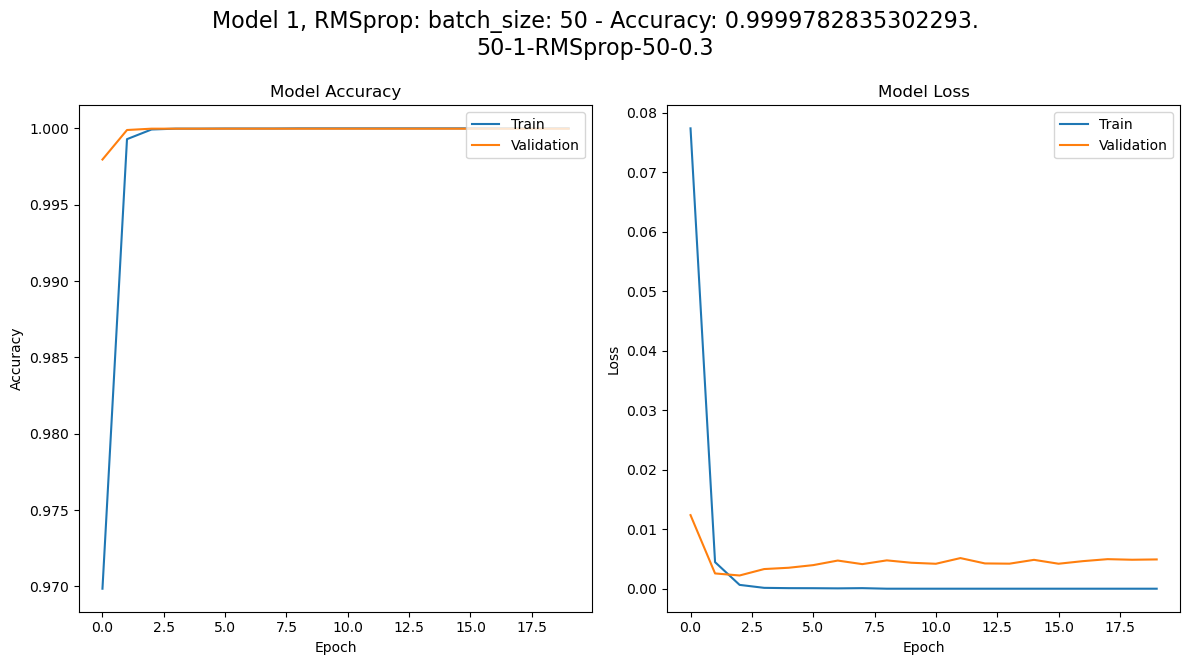

51-1-RMSprop-10-0.1
480/480 [==============================] - 0s 252us/step
51-1-RMSprop-10-0.1


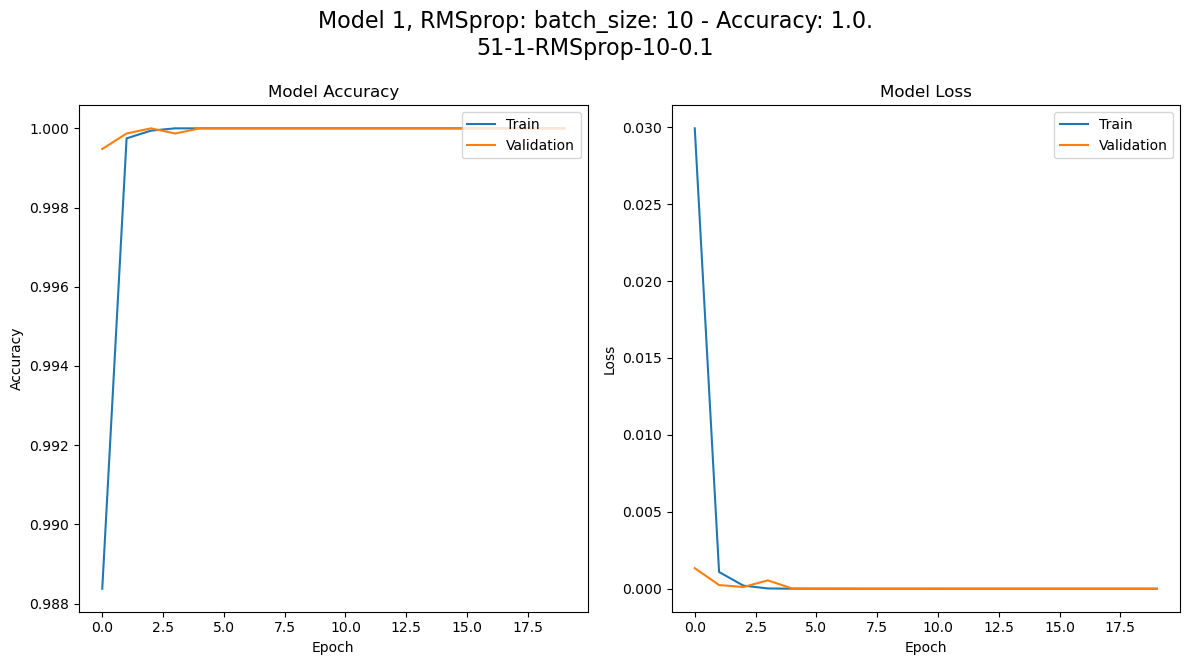

52-1-RMSprop-10-0.2
960/960 [==============================] - 0s 238us/step
52-1-RMSprop-10-0.2


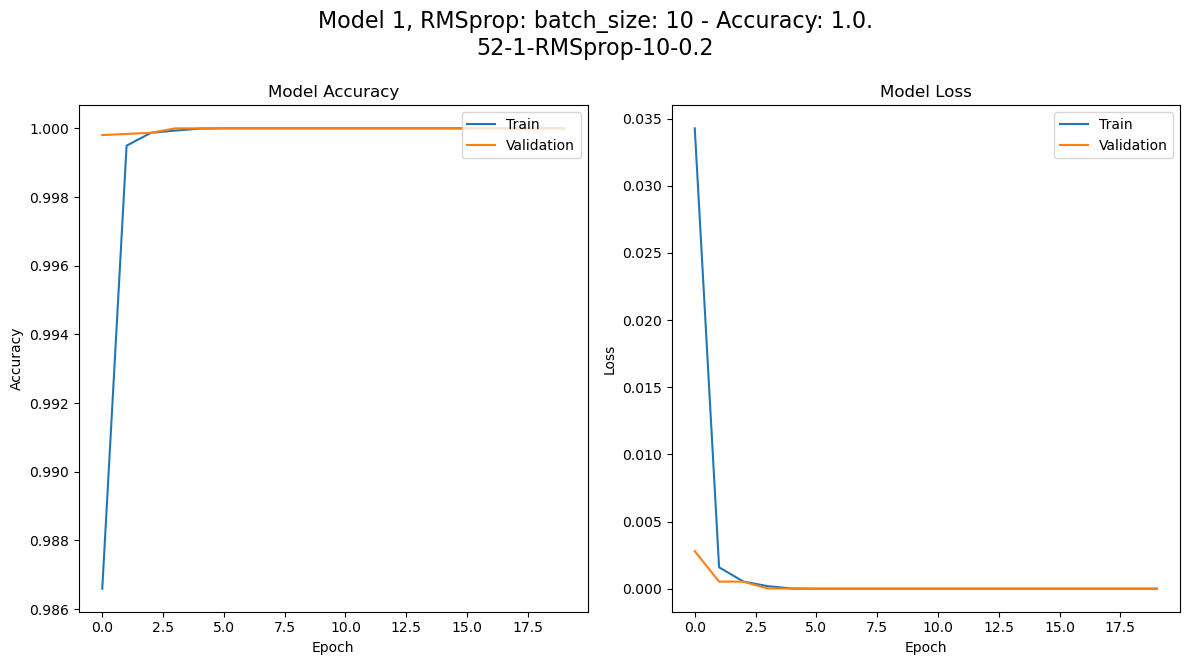

53-1-RMSprop-10-0.3
1439/1439 [==============================] - 0s 232us/step
53-1-RMSprop-10-0.3


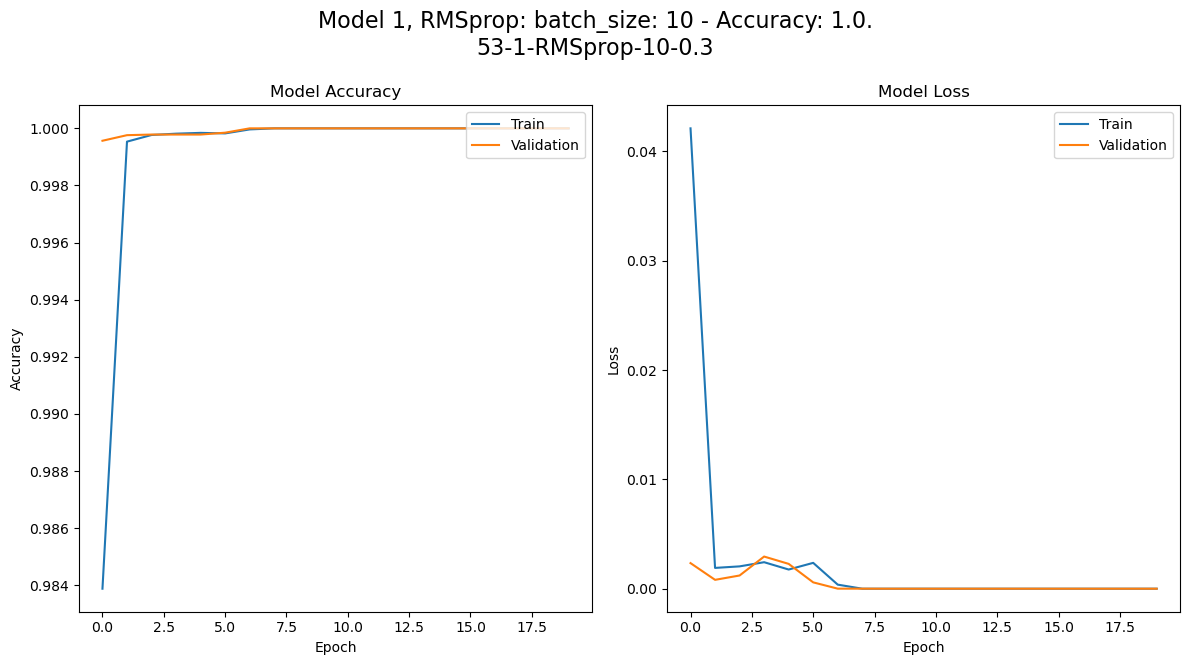

54-2-Adam-100-0.1
480/480 [==============================] - 0s 453us/step
54-2-Adam-100-0.1


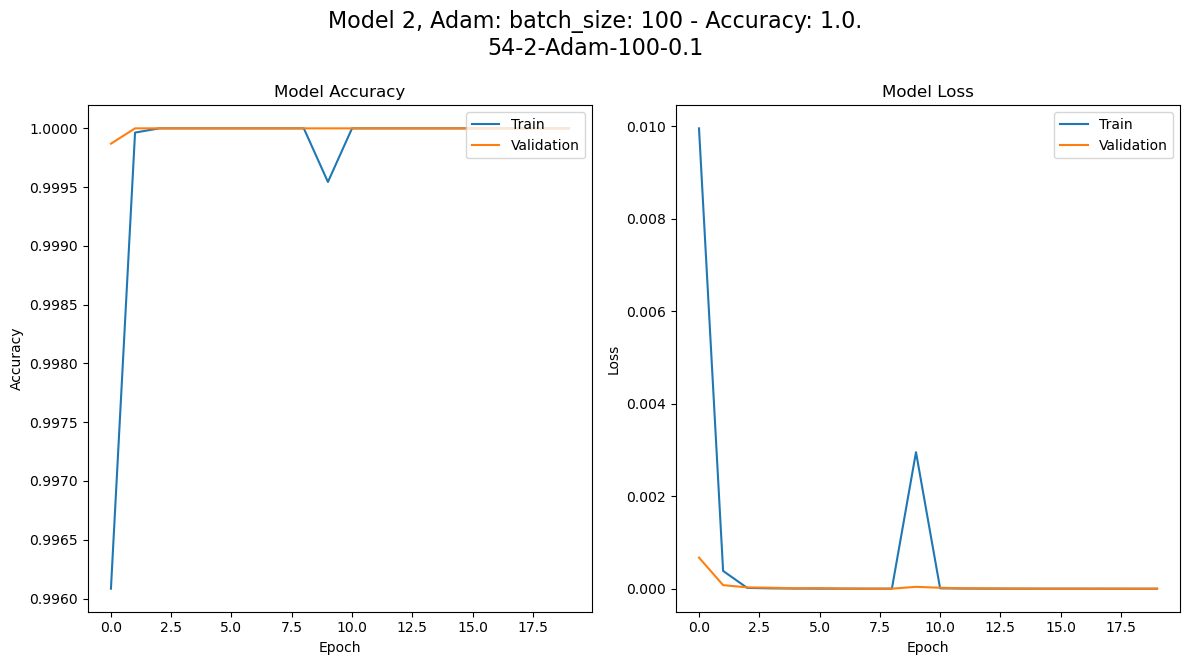

55-2-Adam-100-0.2
960/960 [==============================] - 0s 458us/step
55-2-Adam-100-0.2


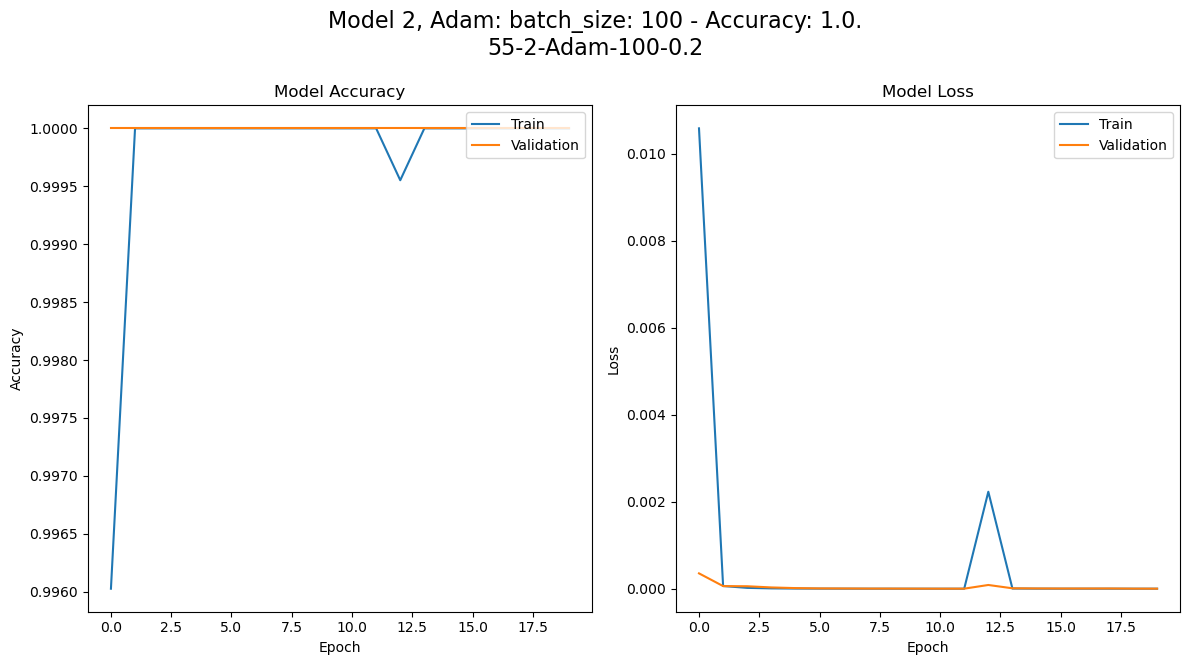

56-2-Adam-100-0.3
1439/1439 [==============================] - 1s 435us/step
56-2-Adam-100-0.3


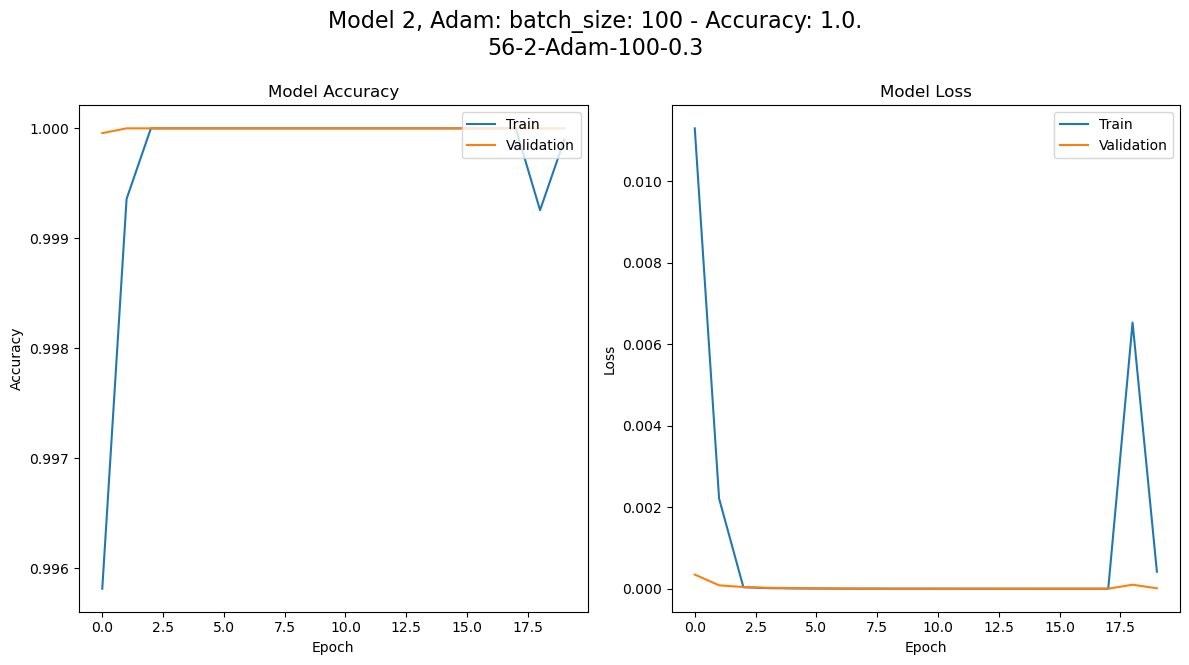

57-2-Adam-50-0.1
480/480 [==============================] - 0s 437us/step
57-2-Adam-50-0.1


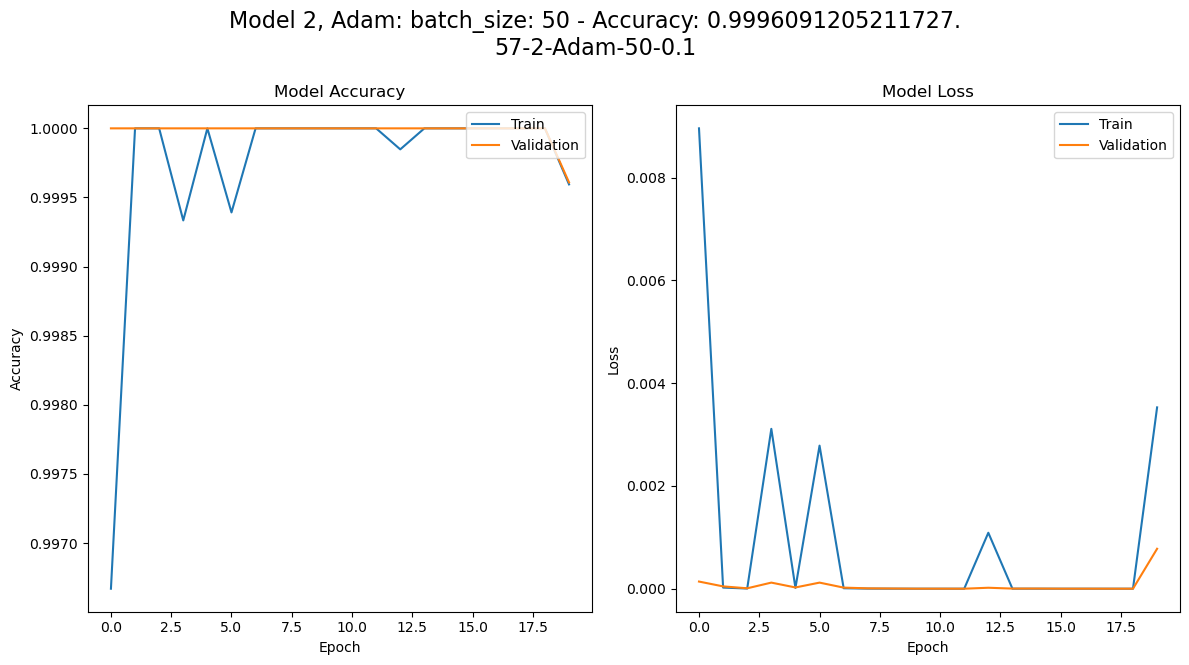

58-2-Adam-50-0.2
960/960 [==============================] - 0s 401us/step
58-2-Adam-50-0.2


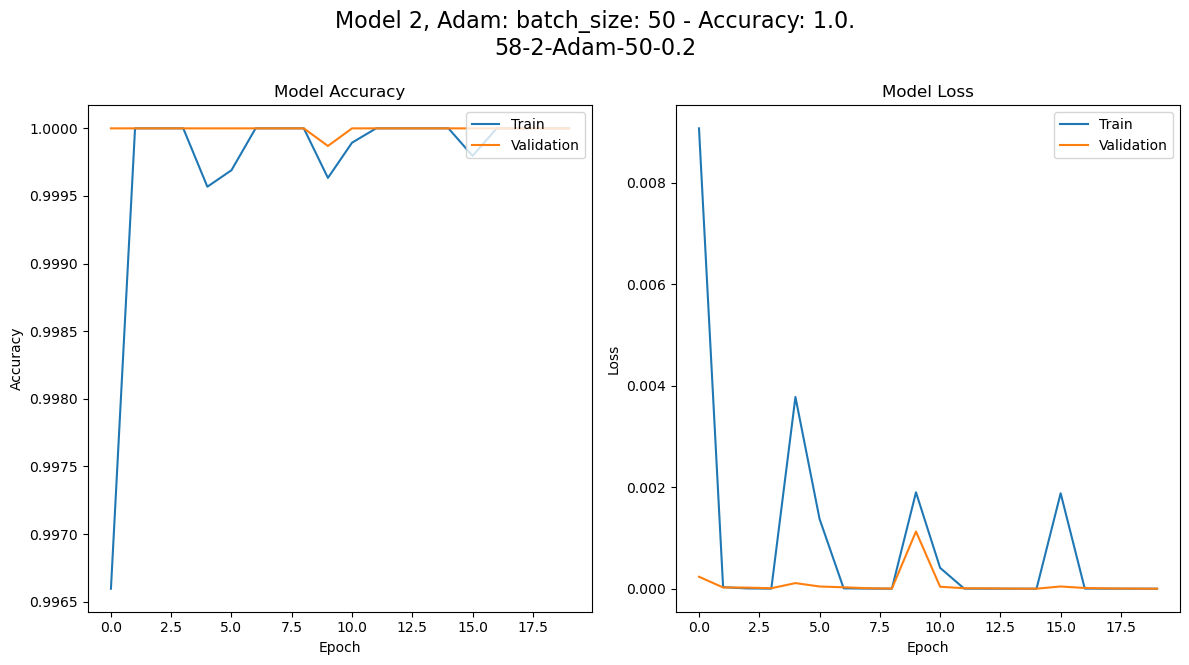

59-2-Adam-50-0.3
1439/1439 [==============================] - 1s 439us/step
59-2-Adam-50-0.3


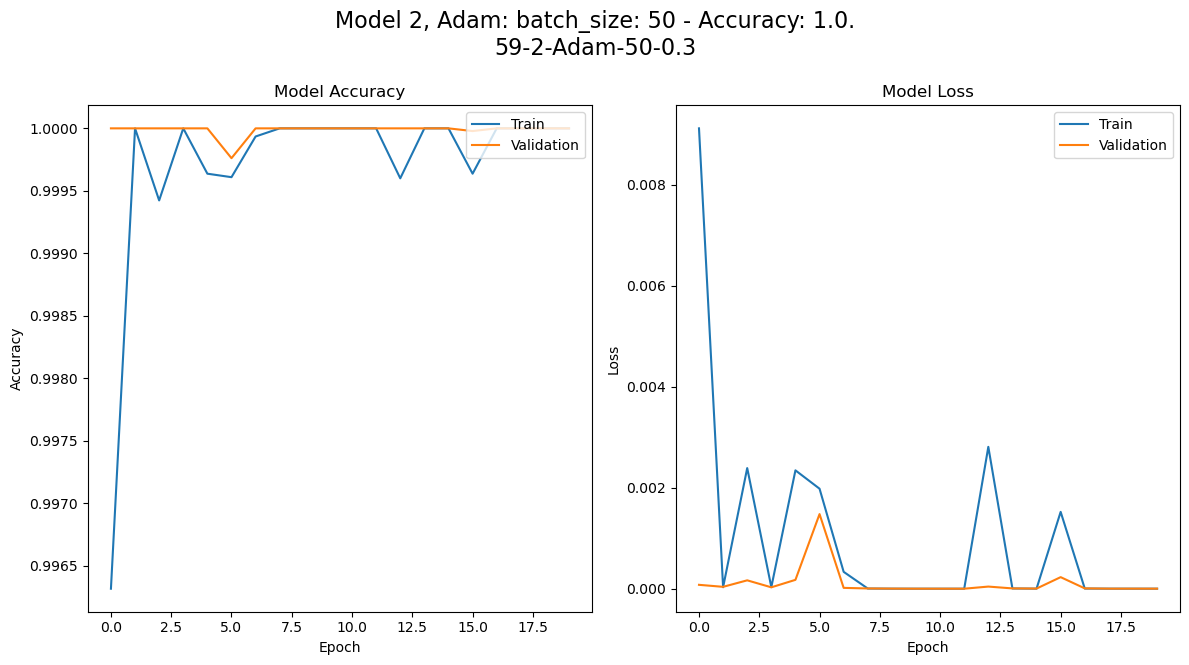

60-2-Adam-10-0.1
480/480 [==============================] - 0s 431us/step
60-2-Adam-10-0.1


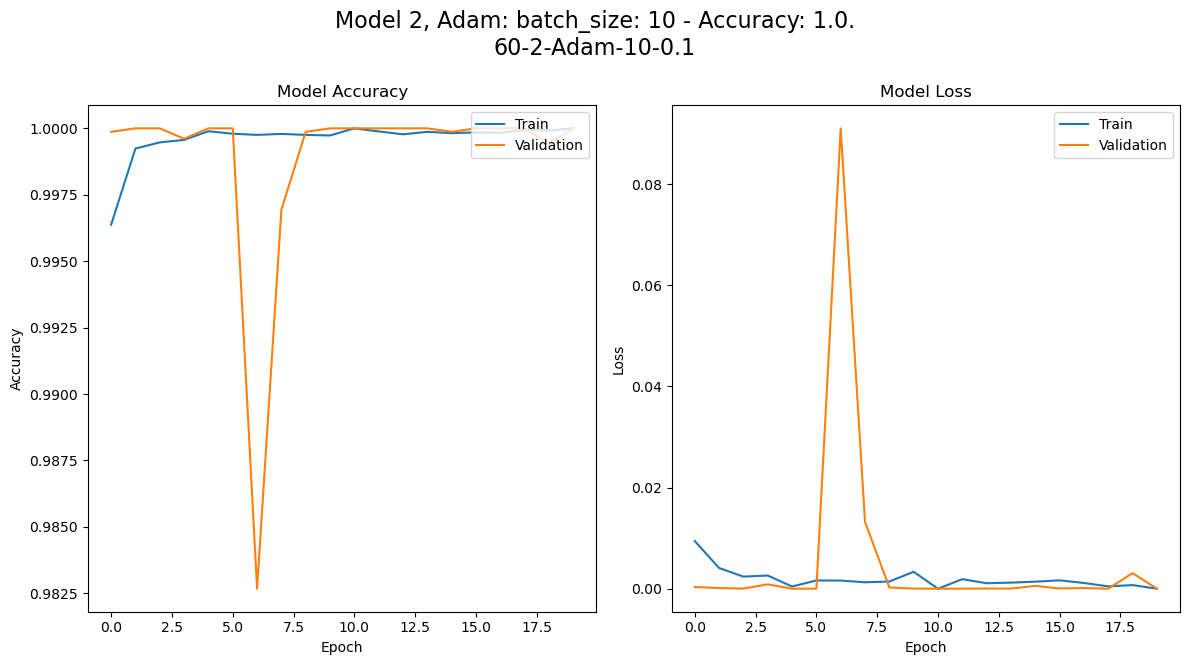

61-2-Adam-10-0.2
960/960 [==============================] - 0s 432us/step
61-2-Adam-10-0.2


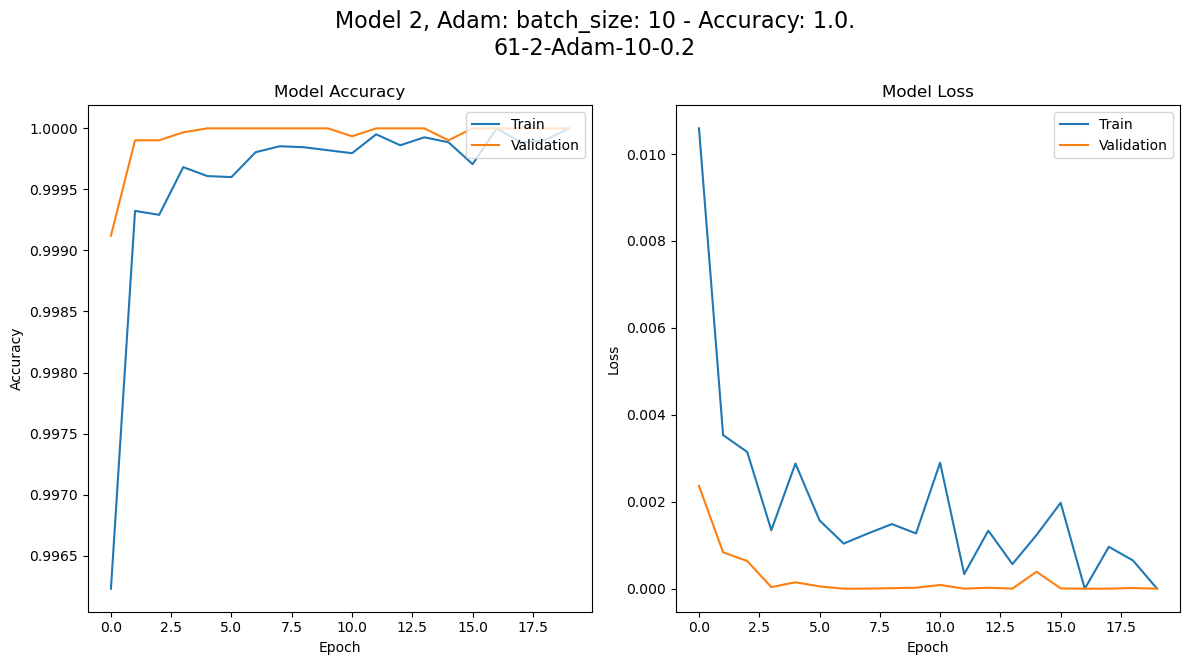

62-2-Adam-10-0.3
1439/1439 [==============================] - 1s 425us/step
62-2-Adam-10-0.3


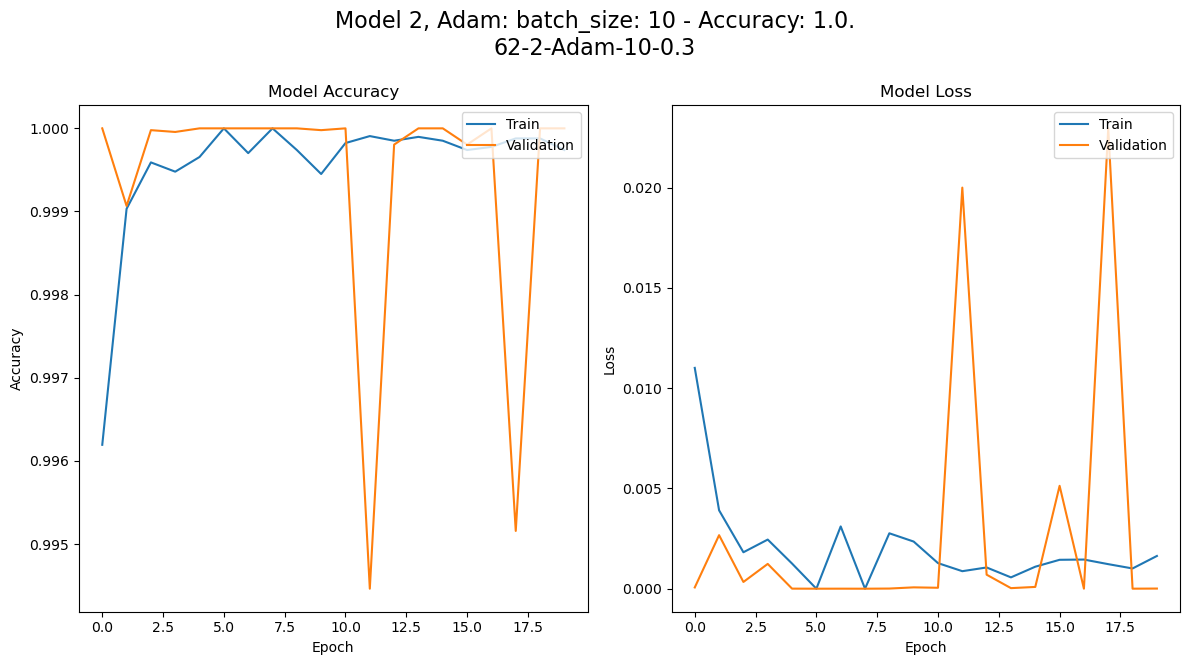

63-2-SGD-100-0.1
480/480 [==============================] - 0s 417us/step
63-2-SGD-100-0.1


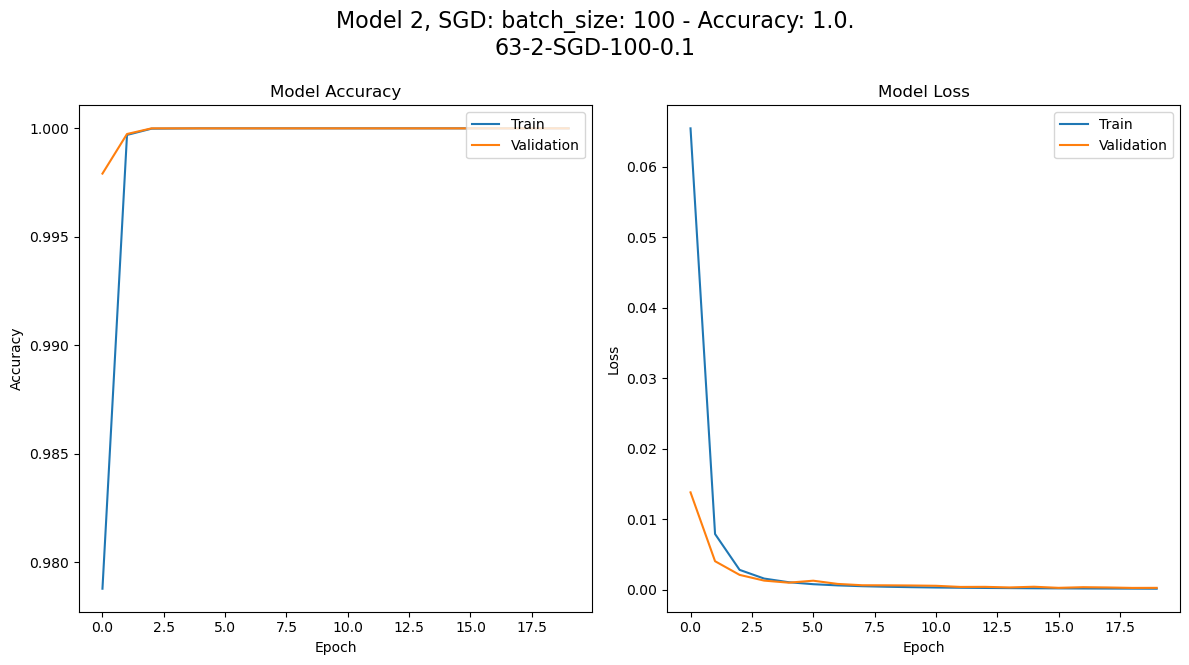

64-2-SGD-100-0.2
960/960 [==============================] - 0s 409us/step
64-2-SGD-100-0.2


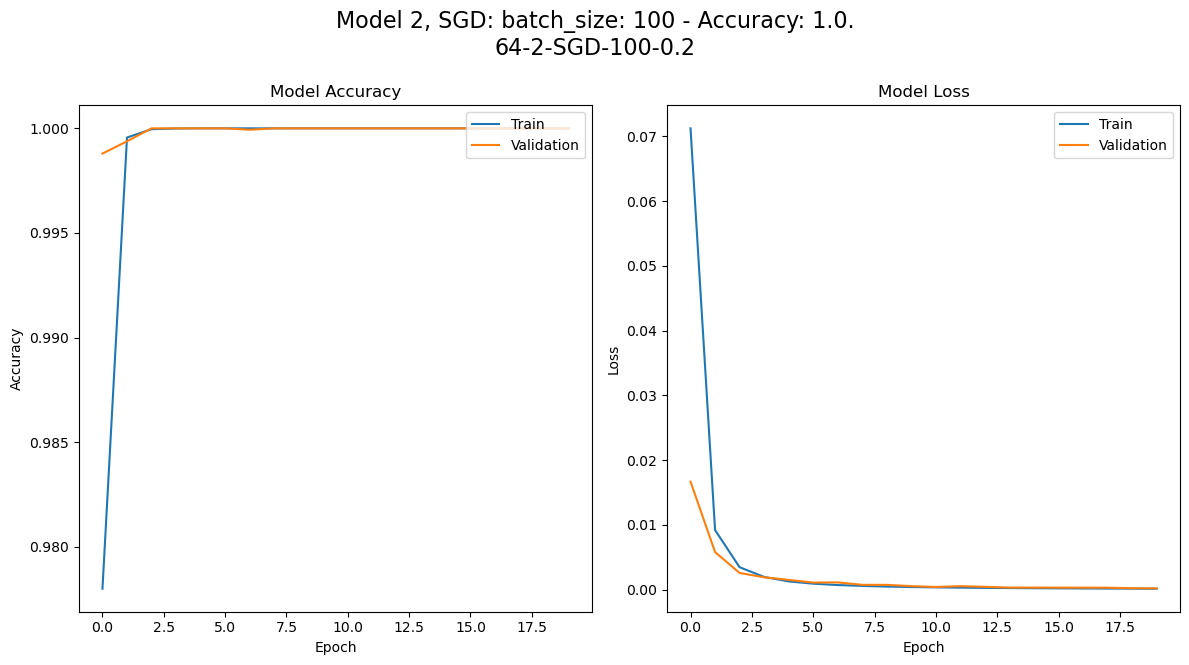

65-2-SGD-100-0.3
1439/1439 [==============================] - 1s 409us/step
65-2-SGD-100-0.3


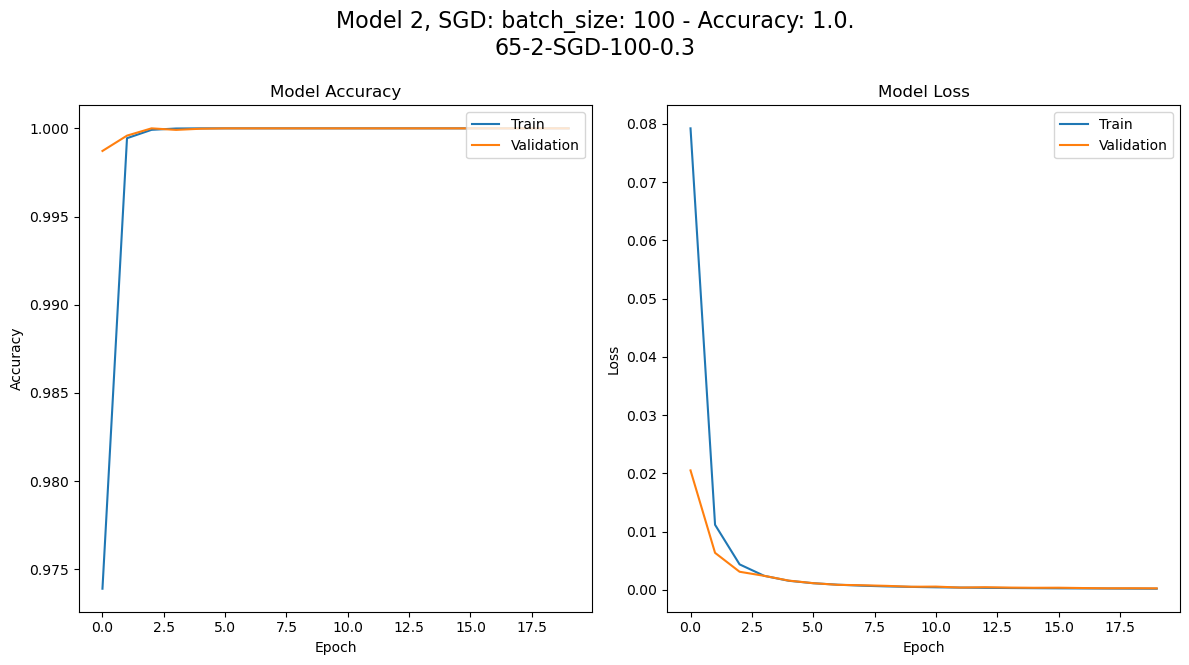

66-2-SGD-50-0.1
480/480 [==============================] - 0s 420us/step
66-2-SGD-50-0.1


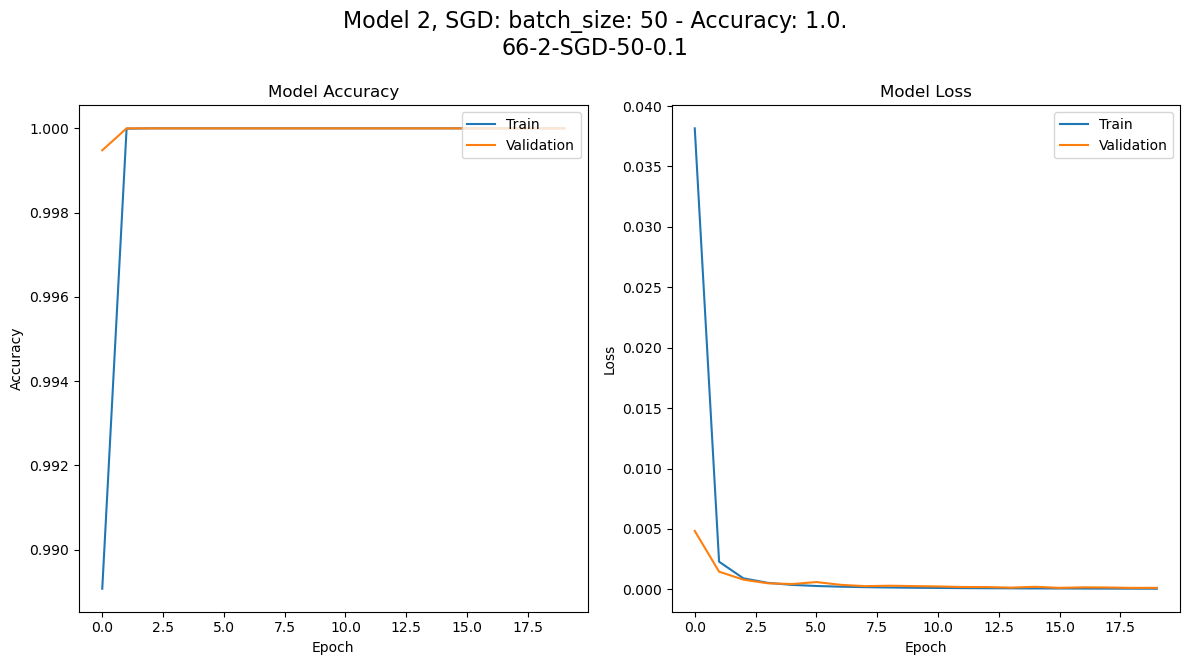

67-2-SGD-50-0.2
960/960 [==============================] - 0s 425us/step
67-2-SGD-50-0.2


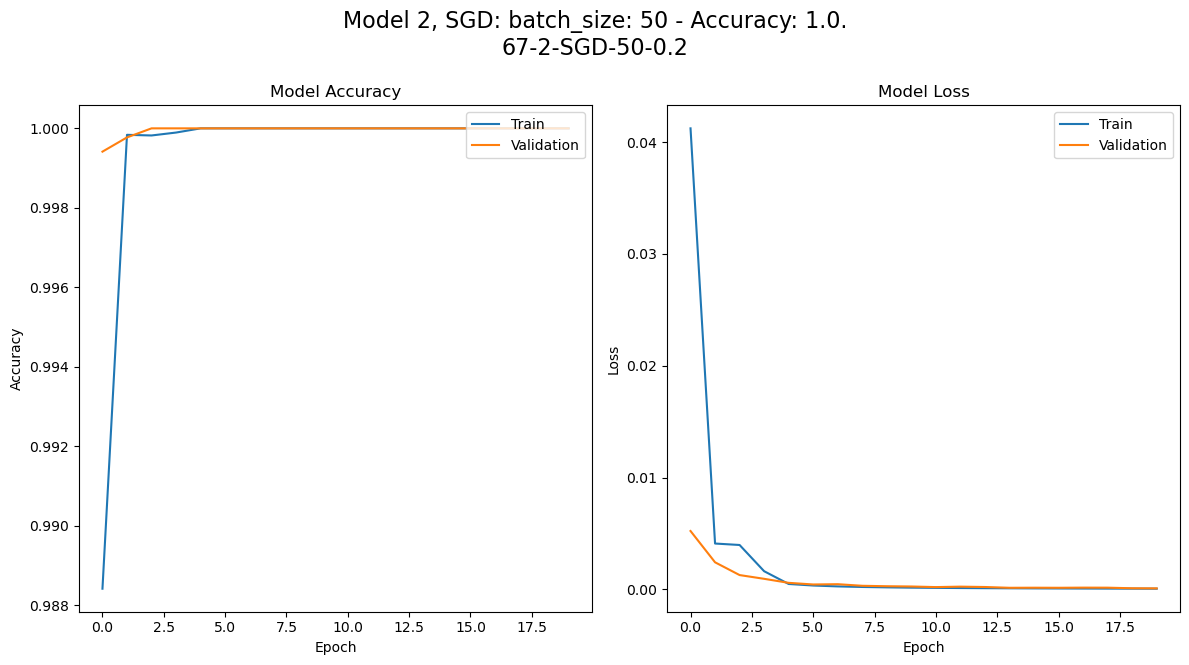

68-2-SGD-50-0.3
1439/1439 [==============================] - 1s 427us/step
68-2-SGD-50-0.3


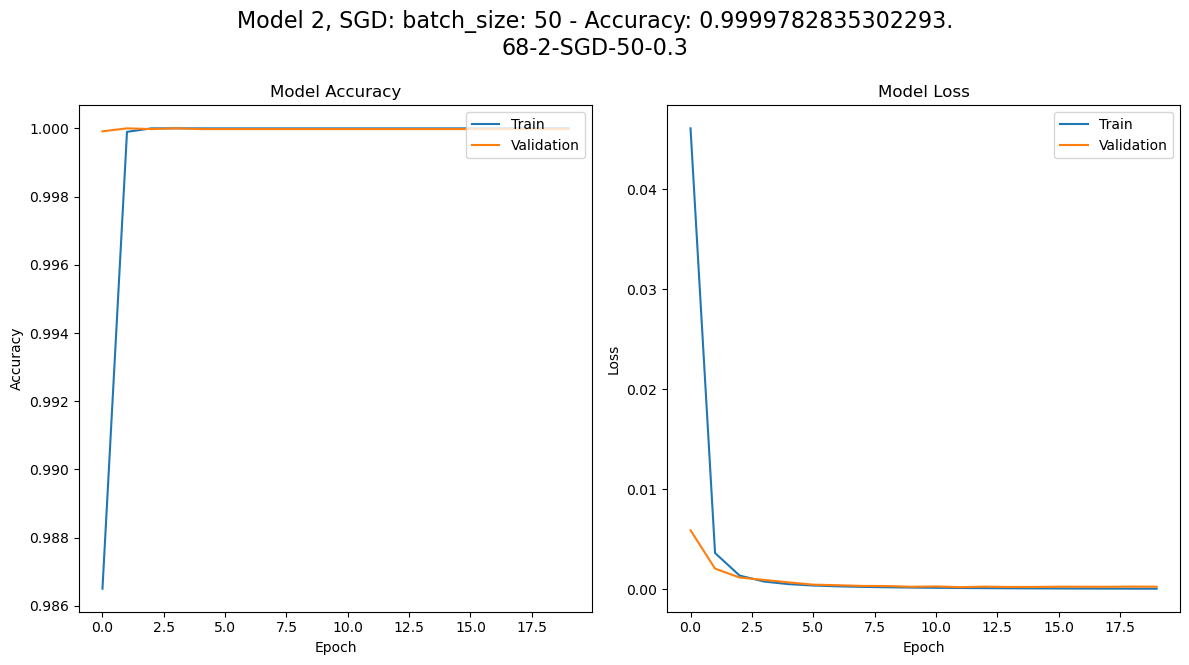

69-2-SGD-10-0.1
480/480 [==============================] - 0s 423us/step
69-2-SGD-10-0.1


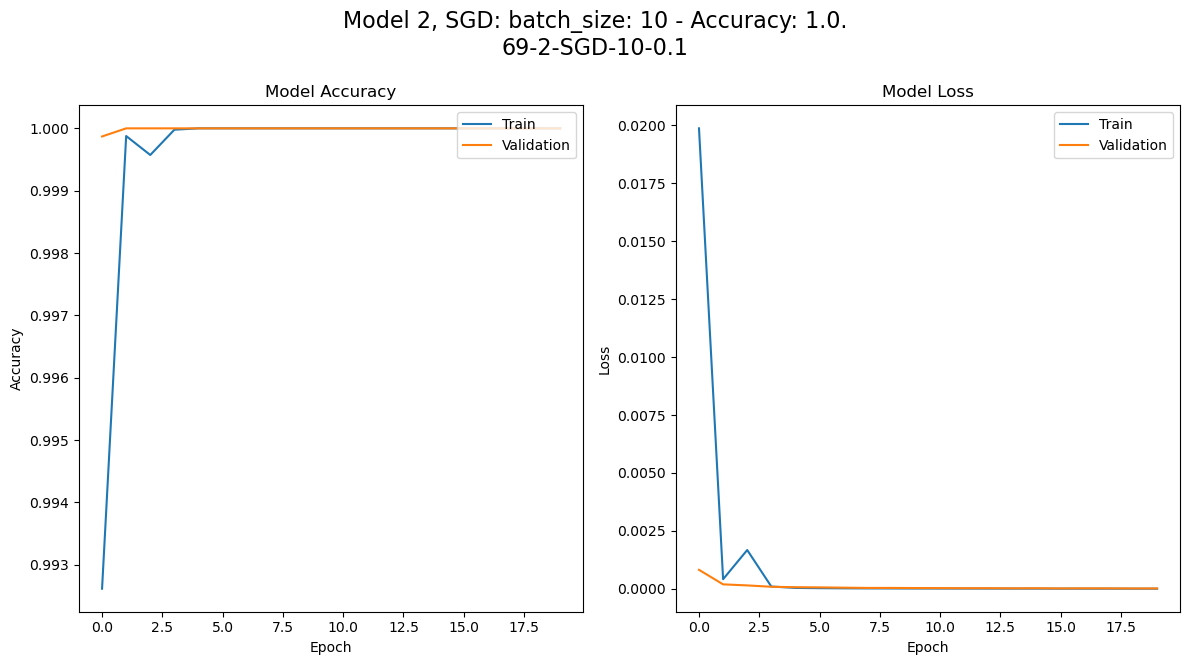

70-2-SGD-10-0.2
960/960 [==============================] - 0s 423us/step
70-2-SGD-10-0.2


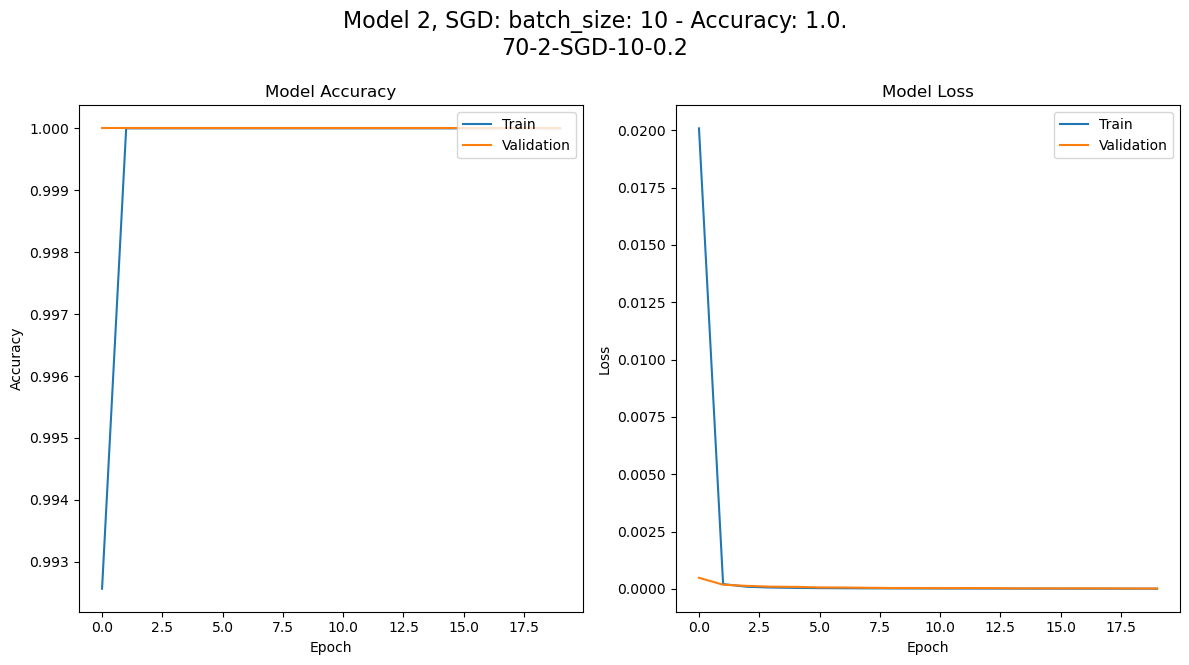

71-2-SGD-10-0.3
1439/1439 [==============================] - 1s 428us/step
71-2-SGD-10-0.3


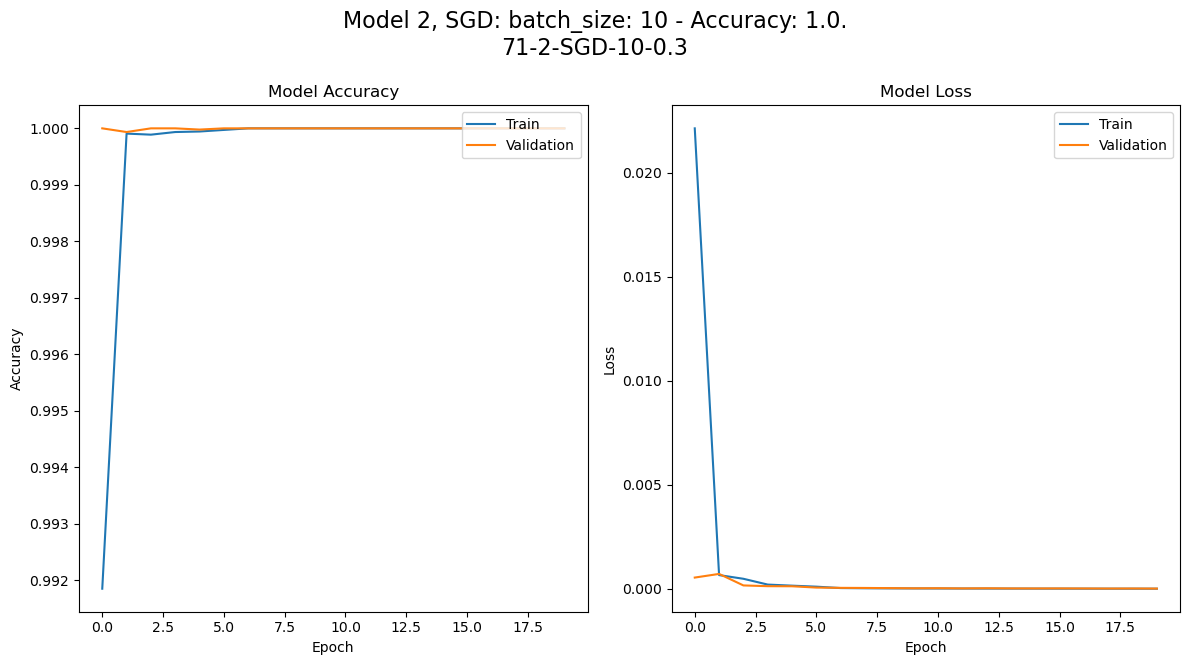

72-2-RMSprop-100-0.1
480/480 [==============================] - 0s 428us/step
72-2-RMSprop-100-0.1


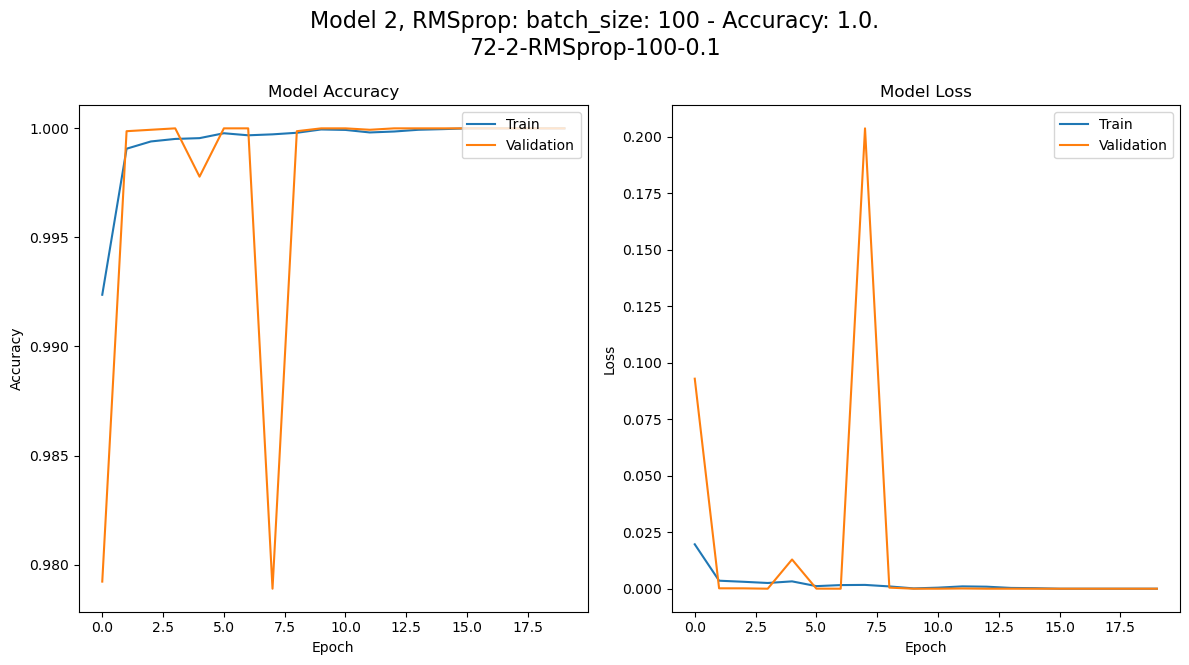

73-2-RMSprop-100-0.2
960/960 [==============================] - 0s 414us/step
73-2-RMSprop-100-0.2


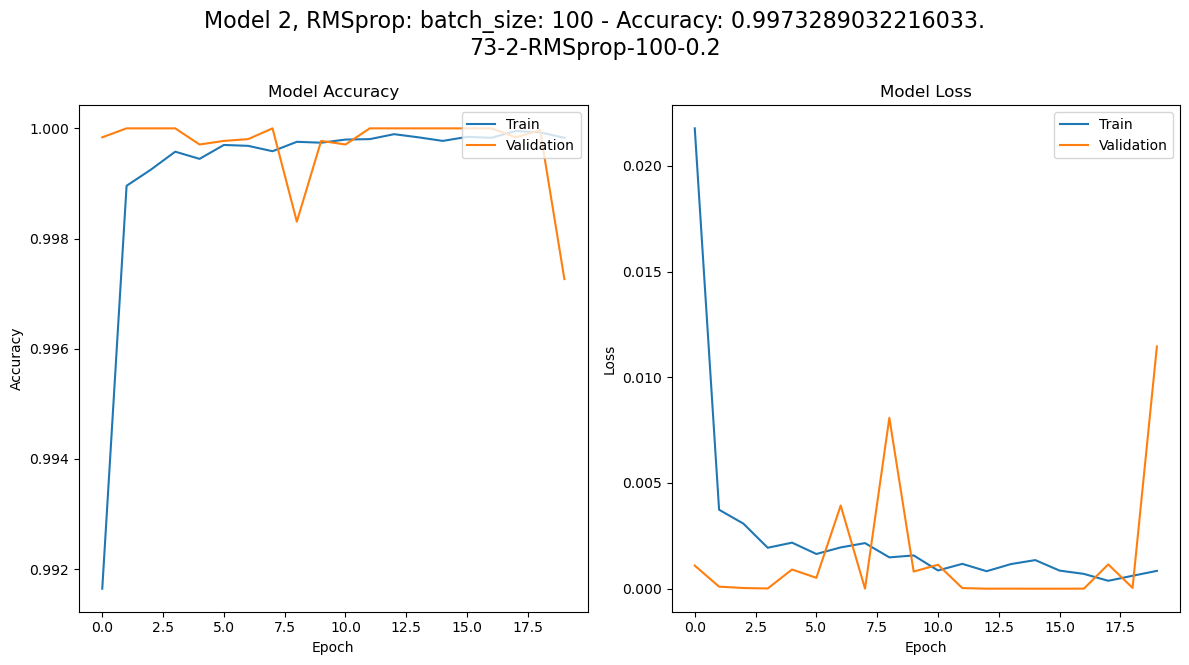

74-2-RMSprop-100-0.3
1439/1439 [==============================] - 1s 411us/step
74-2-RMSprop-100-0.3


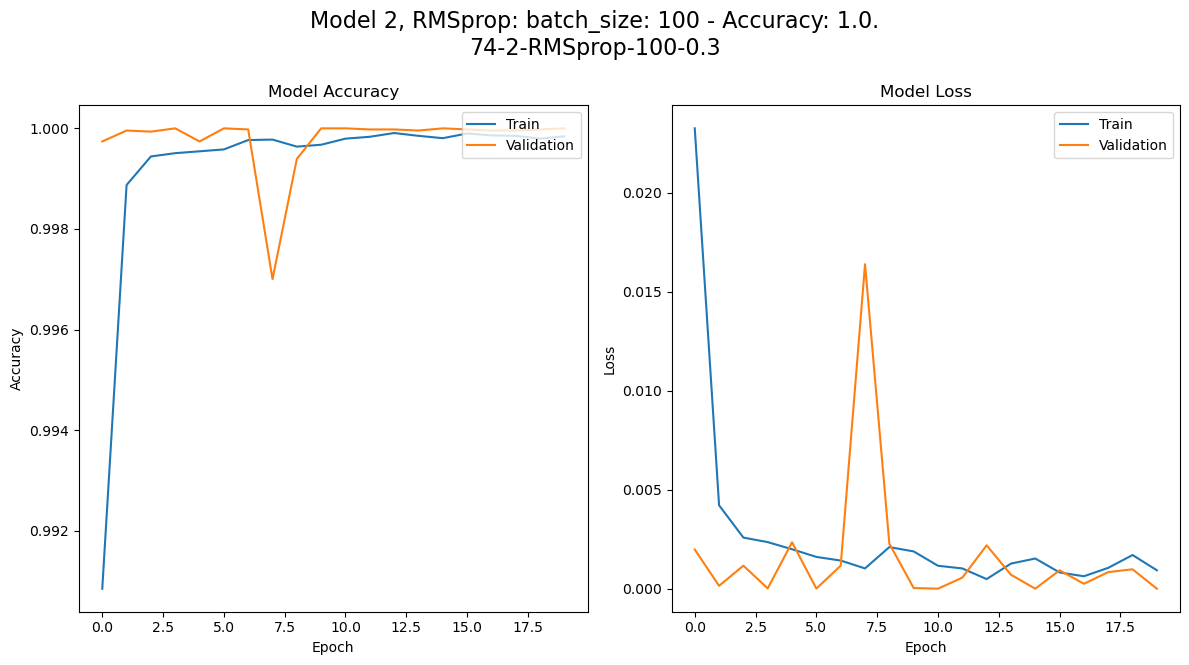

75-2-RMSprop-50-0.1
480/480 [==============================] - 0s 417us/step
75-2-RMSprop-50-0.1


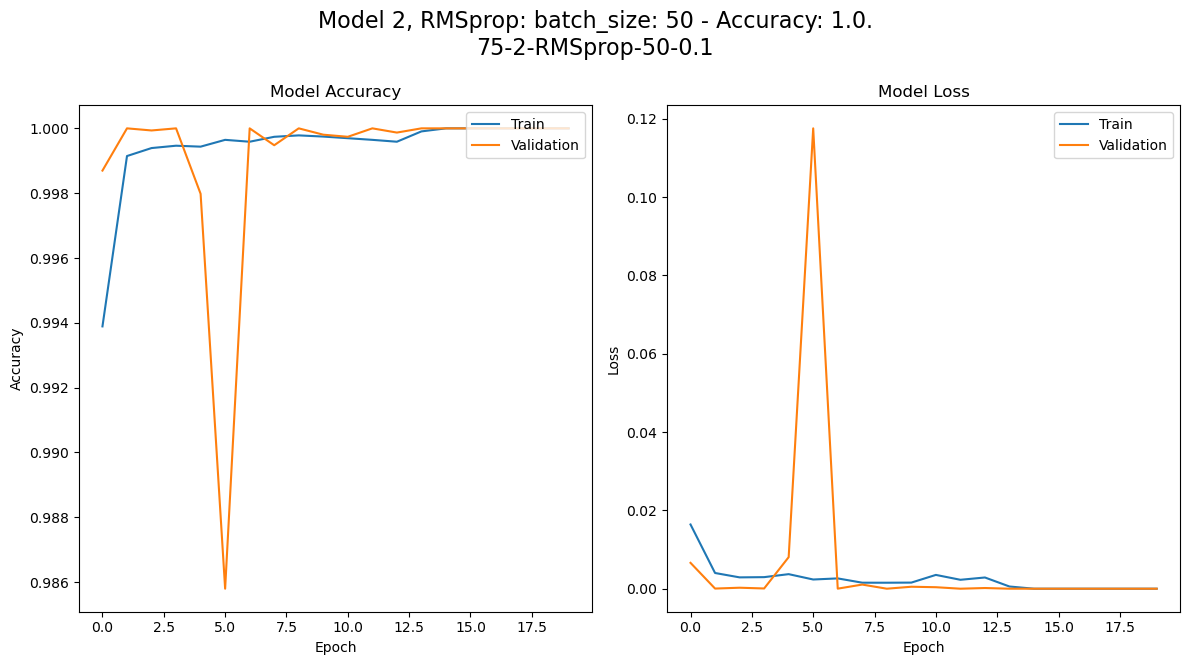

76-2-RMSprop-50-0.2
960/960 [==============================] - 0s 429us/step
76-2-RMSprop-50-0.2


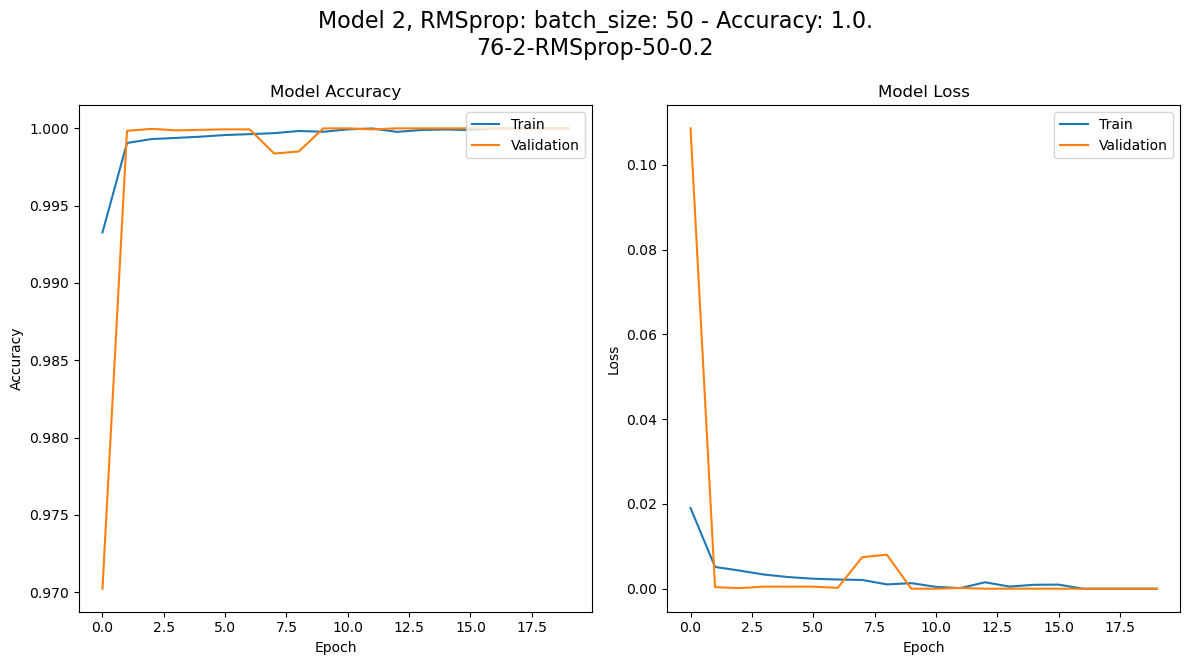

77-2-RMSprop-50-0.3
1439/1439 [==============================] - 1s 420us/step
77-2-RMSprop-50-0.3


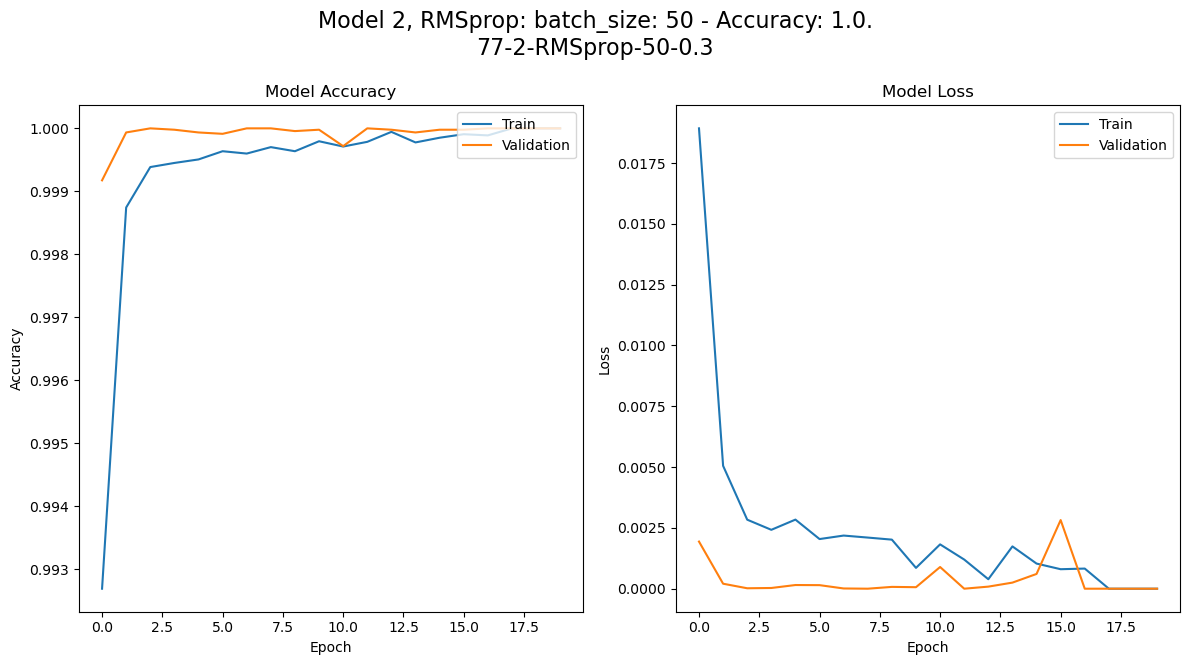

78-2-RMSprop-10-0.1
480/480 [==============================] - 0s 419us/step
78-2-RMSprop-10-0.1


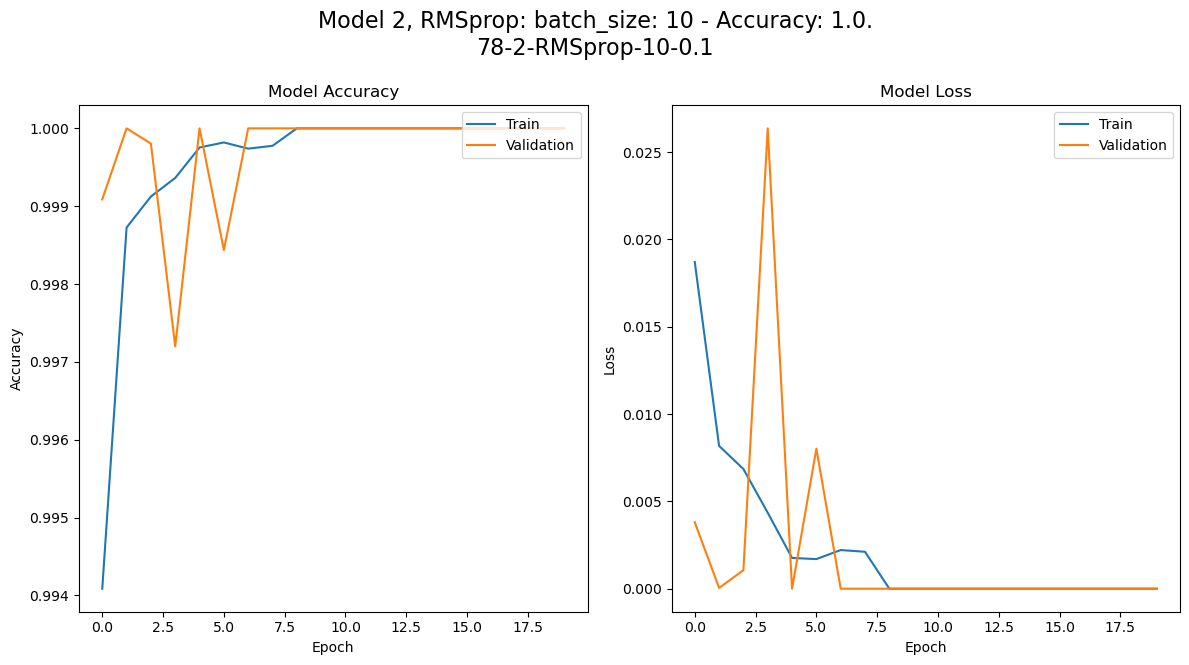

79-2-RMSprop-10-0.2
960/960 [==============================] - 0s 415us/step
79-2-RMSprop-10-0.2


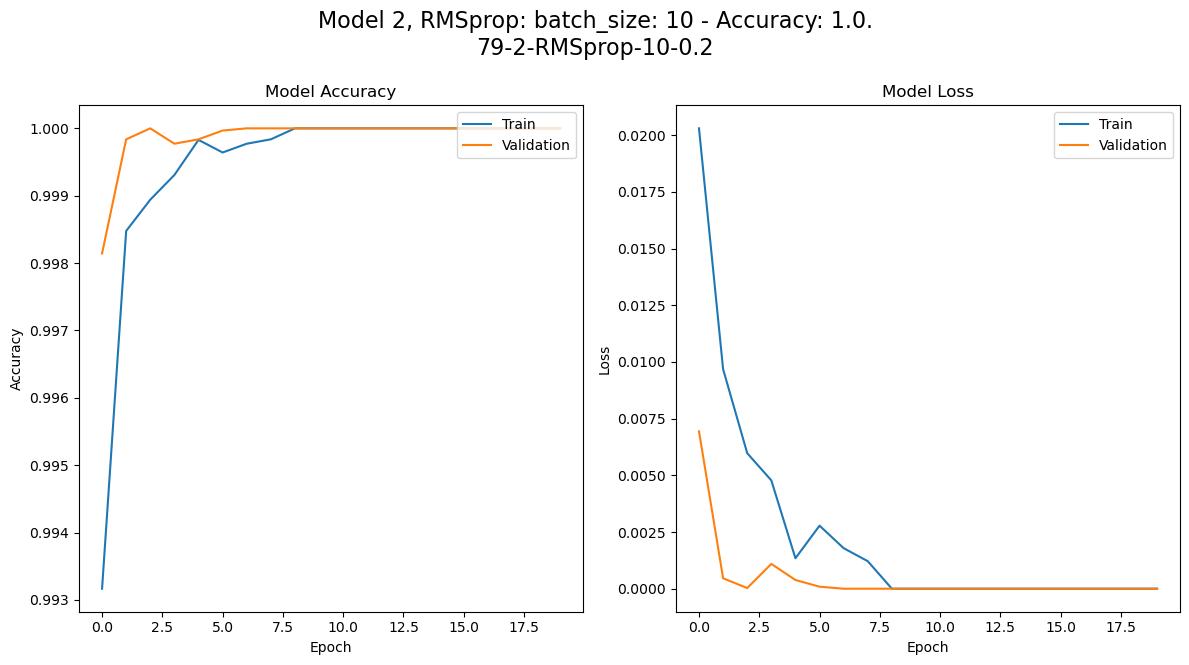

80-2-RMSprop-10-0.3
1439/1439 [==============================] - 1s 412us/step
80-2-RMSprop-10-0.3


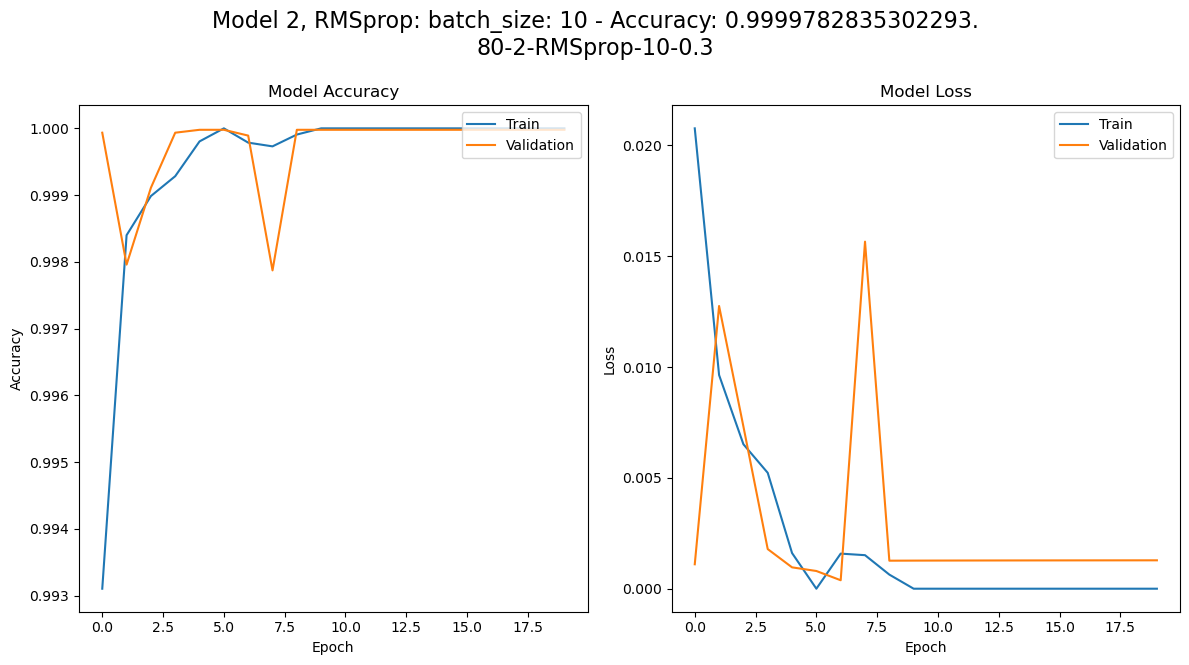

In [7]:
parameters_to_test = {
    'model__hidden_units': [4, 16, 512],
    'model__optimizer': [tf.keras.optimizers.legacy.Adam(),
                         tf.keras.optimizers.legacy.SGD(momentum=0.9),
                         tf.keras.optimizers.legacy.RMSprop()],
    'model__batch_size': [100, 50, 10],
    'test_size': [.1, .2, .3]
}
# Calling the function
all_history = find_best_arch(parameters_to_test, X, y)

As we can see, most of the curves are no good, especially after increasing number of neurons (units). 2-0-Adam-100-0.3 and 11-0-SGD-100-0.3 are looking okay, let's plot them together.

In [8]:
all_history

{'0-0-Adam-100-0.1': <keras.callbacks.History at 0x17e7ddf10>,
 '1-0-Adam-100-0.2': <keras.callbacks.History at 0x17fa388d0>,
 '2-0-Adam-100-0.3': <keras.callbacks.History at 0x17ebb8e10>,
 '3-0-Adam-50-0.1': <keras.callbacks.History at 0x28b12bd10>,
 '4-0-Adam-50-0.2': <keras.callbacks.History at 0x28b701410>,
 '5-0-Adam-50-0.3': <keras.callbacks.History at 0x28983eb50>,
 '6-0-Adam-10-0.1': <keras.callbacks.History at 0x160b3fa50>,
 '7-0-Adam-10-0.2': <keras.callbacks.History at 0x1661b9410>,
 '8-0-Adam-10-0.3': <keras.callbacks.History at 0x28f350990>,
 '9-0-SGD-100-0.1': <keras.callbacks.History at 0x1607f2f10>,
 '10-0-SGD-100-0.2': <keras.callbacks.History at 0x166240e10>,
 '11-0-SGD-100-0.3': <keras.callbacks.History at 0x17fcb8e10>,
 '12-0-SGD-50-0.1': <keras.callbacks.History at 0x17a3ab050>,
 '13-0-SGD-50-0.2': <keras.callbacks.History at 0x29ea5c650>,
 '14-0-SGD-50-0.3': <keras.callbacks.History at 0x17a5cbf90>,
 '15-0-SGD-10-0.1': <keras.callbacks.History at 0x2d0789f90>,
 '1

In [9]:
def plot_combined_metrics(history1, history2, metric1, metric2, title):
    plt.figure(figsize=(12, 6))
    # Plot training & validation metric1 values
    plt.subplot(1, 2, 1)
    plt.plot(history1.history[metric1], label=f'Training-Model 1', linestyle='-', color='blue')
    plt.plot(history1.history[f'val_{metric1}'], label=f'Validation-Model 1', linestyle='--', color='blue')
    plt.plot(history2.history[metric1], label=f'Training-Model 2', linestyle='-', color='red')
    plt.plot(history2.history[f'val_{metric1}'], label=f'Validation-Model 2', linestyle='--', color='red')
    plt.title(metric1)
    plt.xlabel('Epoch')
    plt.ylabel(metric1)
    plt.legend(loc='upper right')

    # Plot training & validation metric2 values
    plt.subplot(1, 2, 2)
    plt.plot(history1.history[metric2], label=f'Training-Model 1', linestyle='-', color='blue')
    plt.plot(history1.history[f'val_{metric2}'], label=f'Validation-Model 1', linestyle='--', color='blue')
    plt.plot(history2.history[metric2], label=f'Training-Model 2', linestyle='-', color='red')
    plt.plot(history2.history[f'val_{metric2}'], label=f'Validation-Model 2', linestyle='--', color='red')
    plt.title(metric2)
    plt.xlabel('Epoch')
    plt.ylabel(metric2)
    plt.legend(loc='upper right')
    
    plt.suptitle(title, fontsize=16, y=1.01)
    plt.tight_layout()
    plt.show()


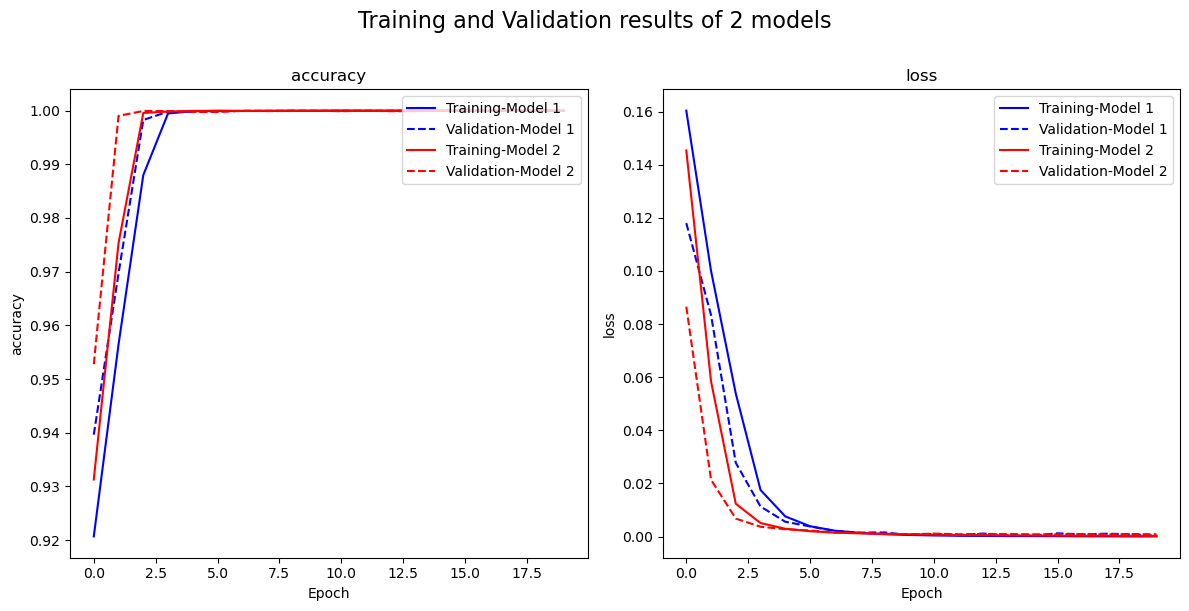

In [10]:
# Visualizing the results of 2 most suibale models
# 2-0-Adam-100-0.3, 11-0-SGD-100-0.3, 44-1-SGD-10-0.3
best_h = ['2-0-Adam-100-0.3', '11-0-SGD-100-0.3']

plot_combined_metrics(all_history[best_h[0]], all_history[best_h[1]], 'accuracy', 'loss', title='Training and Validation results of 2 models')

By looking in these curves, Model 1 learned with a bit more time. So let's take it as our main model.

## Define the learning rate

In [11]:
def lr_scheduler(epoch, lr):
    return 1e-8 * 10**(epoch / 20)

def tune_lr(X_train, y_train, epochs=50):
    model_tune = Sequential()
    model_tune.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model_tune.add(Dense(64, activation='relu'))
    model_tune.add(Dense(1, activation='sigmoid'))
    

    lr_schedule = LearningRateScheduler(lr_scheduler)
    optimizer = tf.keras.optimizers.legacy.Adam() # for M2 processor only
    # optimizer = tf.keras.optimizers.Adam()  
    model_tune.compile(loss='binary_crossentropy', optimizer=optimizer)

    history = model_tune.fit(X_train, y_train, epochs=epochs, callbacks=[lr_schedule], verbose=0)

    lrs = 1e-8 * (10 ** (np.arange(epochs) / 20))

    plt.figure(figsize=(10, 6))
    plt.grid(True)
    plt.semilogx(lrs, history.history["loss"])
    plt.axis([min(lrs), max(lrs), min(history.history["loss"]), max(history.history["loss"])])
    plt.xlabel('Learning Rate')
    plt.ylabel('binary_crossentropy')
    plt.tick_params('both', length=10, width=1, which='both')
    plt.show()

    optimal_lr_index = np.argmin(history.history["loss"])
    optimal_lr = lrs[optimal_lr_index]

    print(f'Optimal Learning Rate: {optimal_lr}')
    return optimal_lr

## Setting final hyperparameters and re-compile it

In [12]:
# 2-0-Adam-100-0.3
batch_size = 100
test_size = 0.3
units = 4

In [13]:
# Split the data according to found test_size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Scaling the Features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (107443, 9) (107443,)
Test shape: (46048, 9) (46048,)


In [14]:
optimal_lr = 2.8183829312644547e-06 # tune_lr(X_train, y_train, epochs=50)

In [15]:
# Initialize the optimizer with learning rate
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=optimal_lr)

# Create new model
new_model = Sequential([
    Dense(units, input_dim=X_train.shape[1], activation='relu'),
    Dense(units, activation='relu'),
    Dense(1, activation='sigmoid'),
                           ])
# Compile the model
new_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
new_model.summary()

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_243 (Dense)           (None, 4)                 40        
                                                                 
 dense_244 (Dense)           (None, 4)                 20        
                                                                 
 dense_245 (Dense)           (None, 1)                 5         
                                                                 
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


## Training final model

The custom callback class '*val_metrics_stop*' stops training when the validation loss falls below 0.01 or the validation accuracy exceeds 0.999, using a common patience parameter.

Also, we are increasing **number of epochs**, because we added *learning_rate* to optimizer, which will make learning process slower.

In [16]:
# Declare own callback class to stop training when conditions met 
class val_metrics_stop(tf.keras.callbacks.Callback):
    def __init__(self, patience=10):
        self.patience = patience
    def on_epoch_end(self, epoch, logs={}):
        """
        To stop the training when the val_loss or val_accuracy meets conditions.
        """
        self.stopped_epoch = 0
        if self.patience < epoch and (logs.get('val_loss') < 0.01 or logs.get('val_accuracy') > 0.9999):
                # Stop if threshold is met
                print("\nCancelling training!")
                self.model.stop_training = True
                self.stopped_epoch = epoch

In [17]:
# set EarlyStopping for both validation loss and accuracy
val_loss_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
val_accuracy_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
# Instantiate own callback class
val_metrics_stop_numbers = val_metrics_stop(patience=10)

# we are increasing no of epochs,
# because we added learning_rate to optimizer
epochs = 1000  
tm1 = time()
history = new_model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs, batch_size=batch_size,
                        callbacks=[val_loss_stop, val_accuracy_stop, val_metrics_stop_numbers],
                        verbose=1,)
tm2 = time()

Epoch 1/1000
1075/1075 [==============================] - 1s 519us/step - loss: 0.8669 - accuracy: 0.4000 - val_loss: 0.8633 - val_accuracy: 0.3975
Epoch 2/1000
1075/1075 [==============================] - 0s 458us/step - loss: 0.8565 - accuracy: 0.4001 - val_loss: 0.8531 - val_accuracy: 0.3977
Epoch 3/1000
1075/1075 [==============================] - 0s 460us/step - loss: 0.8465 - accuracy: 0.4003 - val_loss: 0.8432 - val_accuracy: 0.3984
Epoch 4/1000
1075/1075 [==============================] - 0s 458us/step - loss: 0.8369 - accuracy: 0.4006 - val_loss: 0.8337 - val_accuracy: 0.3983
Epoch 5/1000
1075/1075 [==============================] - 0s 458us/step - loss: 0.8275 - accuracy: 0.4010 - val_loss: 0.8245 - val_accuracy: 0.4003
Epoch 6/1000
1075/1075 [==============================] - 0s 459us/step - loss: 0.8185 - accuracy: 0.4019 - val_loss: 0.8155 - val_accuracy: 0.4008
Epoch 7/1000
1075/1075 [==============================] - 0s 458us/step - loss: 0.8097 - accuracy: 0.4032 - val_

1075/1075 [==============================] - 0s 457us/step - loss: 0.5701 - accuracy: 0.7901 - val_loss: 0.5696 - val_accuracy: 0.7938
Epoch 57/1000
1075/1075 [==============================] - 0s 459us/step - loss: 0.5669 - accuracy: 0.7956 - val_loss: 0.5665 - val_accuracy: 0.8010
Epoch 58/1000
1075/1075 [==============================] - 0s 460us/step - loss: 0.5638 - accuracy: 0.8012 - val_loss: 0.5634 - val_accuracy: 0.8082
Epoch 59/1000
1075/1075 [==============================] - 0s 457us/step - loss: 0.5606 - accuracy: 0.8106 - val_loss: 0.5603 - val_accuracy: 0.8109
Epoch 60/1000
1075/1075 [==============================] - 0s 458us/step - loss: 0.5575 - accuracy: 0.8159 - val_loss: 0.5572 - val_accuracy: 0.8228
Epoch 61/1000
1075/1075 [==============================] - 0s 459us/step - loss: 0.5545 - accuracy: 0.8229 - val_loss: 0.5542 - val_accuracy: 0.8240
Epoch 62/1000
1075/1075 [==============================] - 0s 460us/step - loss: 0.5514 - accuracy: 0.8249 - val_loss: 0

1075/1075 [==============================] - 0s 462us/step - loss: 0.4396 - accuracy: 0.8906 - val_loss: 0.4414 - val_accuracy: 0.8895
Epoch 112/1000
1075/1075 [==============================] - 0s 459us/step - loss: 0.4380 - accuracy: 0.8912 - val_loss: 0.4398 - val_accuracy: 0.8900
Epoch 113/1000
1075/1075 [==============================] - 0s 457us/step - loss: 0.4364 - accuracy: 0.8918 - val_loss: 0.4383 - val_accuracy: 0.8907
Epoch 114/1000
1075/1075 [==============================] - 0s 460us/step - loss: 0.4349 - accuracy: 0.8925 - val_loss: 0.4368 - val_accuracy: 0.8909
Epoch 115/1000
1075/1075 [==============================] - 0s 457us/step - loss: 0.4334 - accuracy: 0.8930 - val_loss: 0.4353 - val_accuracy: 0.8916
Epoch 116/1000
1075/1075 [==============================] - 0s 464us/step - loss: 0.4319 - accuracy: 0.8933 - val_loss: 0.4338 - val_accuracy: 0.8920
Epoch 117/1000
1075/1075 [==============================] - 0s 458us/step - loss: 0.4304 - accuracy: 0.8937 - val_l

Epoch 166/1000
1075/1075 [==============================] - 0s 459us/step - loss: 0.3787 - accuracy: 0.9078 - val_loss: 0.3811 - val_accuracy: 0.9069
Epoch 167/1000
1075/1075 [==============================] - 0s 459us/step - loss: 0.3779 - accuracy: 0.9081 - val_loss: 0.3803 - val_accuracy: 0.9068
Epoch 168/1000
1075/1075 [==============================] - 0s 458us/step - loss: 0.3771 - accuracy: 0.9082 - val_loss: 0.3795 - val_accuracy: 0.9069
Epoch 169/1000
1075/1075 [==============================] - 0s 459us/step - loss: 0.3763 - accuracy: 0.9084 - val_loss: 0.3787 - val_accuracy: 0.9072
Epoch 170/1000
1075/1075 [==============================] - 0s 458us/step - loss: 0.3755 - accuracy: 0.9088 - val_loss: 0.3779 - val_accuracy: 0.9077
Epoch 171/1000
1075/1075 [==============================] - 0s 455us/step - loss: 0.3747 - accuracy: 0.9090 - val_loss: 0.3771 - val_accuracy: 0.9084
Epoch 172/1000
1075/1075 [==============================] - 0s 458us/step - loss: 0.3739 - accuracy:

Epoch 275/1000
1075/1075 [==============================] - 0s 461us/step - loss: 0.3063 - accuracy: 0.9245 - val_loss: 0.3084 - val_accuracy: 0.9242
Epoch 276/1000
1075/1075 [==============================] - 0s 459us/step - loss: 0.3058 - accuracy: 0.9247 - val_loss: 0.3078 - val_accuracy: 0.9243
Epoch 277/1000
1075/1075 [==============================] - 0s 464us/step - loss: 0.3052 - accuracy: 0.9249 - val_loss: 0.3073 - val_accuracy: 0.9243
Epoch 278/1000
1075/1075 [==============================] - 0s 462us/step - loss: 0.3047 - accuracy: 0.9249 - val_loss: 0.3067 - val_accuracy: 0.9243
Epoch 279/1000
1075/1075 [==============================] - 0s 460us/step - loss: 0.3041 - accuracy: 0.9250 - val_loss: 0.3062 - val_accuracy: 0.9244
Epoch 280/1000
1075/1075 [==============================] - 0s 459us/step - loss: 0.3036 - accuracy: 0.9251 - val_loss: 0.3056 - val_accuracy: 0.9244
Epoch 281/1000
1075/1075 [==============================] - 0s 462us/step - loss: 0.3030 - accuracy:

Epoch 384/1000
1075/1075 [==============================] - 0s 460us/step - loss: 0.2530 - accuracy: 0.9388 - val_loss: 0.2550 - val_accuracy: 0.9375
Epoch 385/1000
1075/1075 [==============================] - 0s 459us/step - loss: 0.2526 - accuracy: 0.9388 - val_loss: 0.2545 - val_accuracy: 0.9375
Epoch 386/1000
1075/1075 [==============================] - 0s 458us/step - loss: 0.2522 - accuracy: 0.9389 - val_loss: 0.2541 - val_accuracy: 0.9375
Epoch 387/1000
1075/1075 [==============================] - 0s 461us/step - loss: 0.2517 - accuracy: 0.9389 - val_loss: 0.2537 - val_accuracy: 0.9376
Epoch 388/1000
1075/1075 [==============================] - 0s 458us/step - loss: 0.2513 - accuracy: 0.9389 - val_loss: 0.2533 - val_accuracy: 0.9376
Epoch 389/1000
1075/1075 [==============================] - 1s 491us/step - loss: 0.2509 - accuracy: 0.9390 - val_loss: 0.2529 - val_accuracy: 0.9376
Epoch 390/1000
1075/1075 [==============================] - 0s 459us/step - loss: 0.2505 - accuracy:

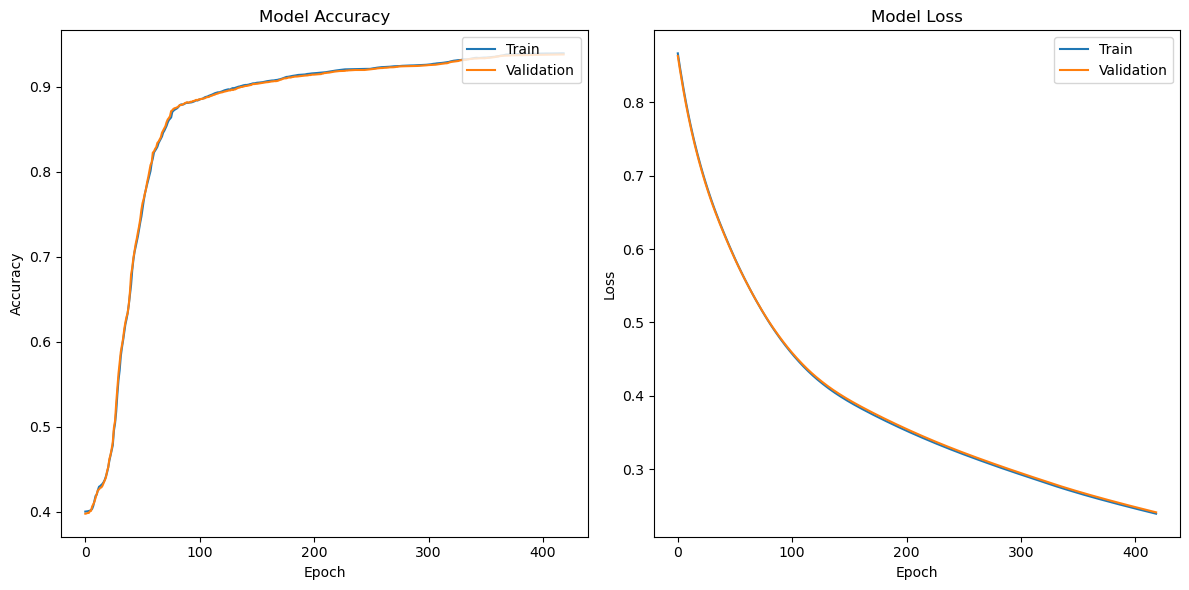

In [18]:
# Plot learning curves
plot_history(history)

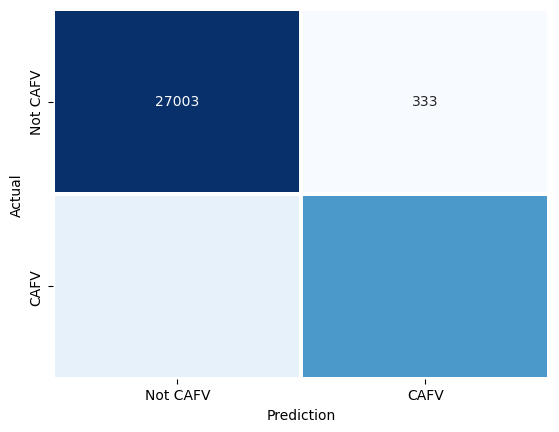

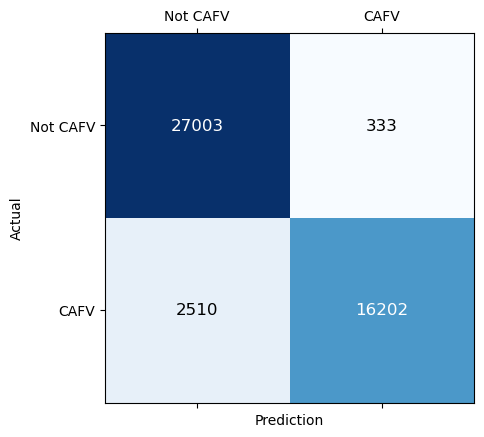

In [19]:
# Calculating and plotting confusion_matrix
y_test_pred = new_model.predict(X_test, verbose=0)
y_test_pred_new = np.where(y_test_pred.flatten().round(2) > 0.5, 1, 0)
c_matrix = confusion_matrix(y_test, y_test_pred_new)
labels = ['Not CAFV', 'CAFV']

plot_confusion_matrix(c_matrix, labels)
plot_confusion_matrix_alt(c_matrix, labels)

In [20]:
# Other metrics
# No of epochs
epochs_list = list({val_metrics_stop_numbers.stopped_epoch, val_accuracy_stop.stopped_epoch, val_loss_stop.stopped_epoch, epochs})
epochs_list.sort()
epochs_trained = min(epochs_list[1:])
print('Trained on', epochs_trained, 'epochs')

y_pred = new_model.predict(X_test, verbose=0)
y_pred = np.where(y_pred.flatten().round(2) > 0.5, 1, 0)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

scores_train = new_model.evaluate(X_train, y_train, verbose=0,)
scores_test = new_model.evaluate(X_test, y_test, verbose=0,)

# Print the metrics

print(f"Training Accuracy: {round(scores_train[1]*100, 4)}%")
print(f"Testing Accuracy: {round(scores_test[1]*100, 4)}%")
print(f"Precision: {precision:.4f}") # fraction of positive predictions which are correct
print(f"Recall: {recall:.4f}") # True positive rate 
print('Time spent on training:', round(tm2 - tm1), 'seconds.')

Trained on 418 epochs
Training Accuracy: 93.9531%
Testing Accuracy: 93.8369%
Precision: 0.9799
Recall: 0.8659
Time spent on training: 208 seconds.
